In [92]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [93]:
# 1. Загружаем данные
# Чтение данных из файла Excel
file_path = "data/dataset.xlsx"
sheet_name = "overall"

df = pd.read_excel(file_path, sheet_name=sheet_name)

# Проверим первые строки
df.head()

,grace_perioud,product,date,customer,amount_upd_tons,price_fca_tonne,zone,opex,fin_status_ok
0,0,Соя,20.02.2025,"ООО ""Текстиль-Агро""",116.474,31231.68,Поволжье,15000,ЛОЖЬ
1,0,Подсолнечник,10.05.2025,"ООО ""Маслоэкспорт""",20.352,23563.82,Центр,20000,ИСТИНА
2,0,Пшеница,12.01.2025,"АО ""ЗерноТрейд""",126.123,8471.82,Центр,8000,ЛОЖЬ
3,0,Пшеница,06.01.2025,"СПК ""Колос""",65.729,8154.81,Центр,8000,ЛОЖЬ
4,0,Соя,16.06.2025,"ООО ""АгроНива""",140.849,30647.82,Поволжье,15000,ЛОЖЬ


In [94]:
# 2. Добавляем нормы
# ---- factor_big_deal_norm ----
def big_deal_norm(product):
    p = product.lower()
    if 'пшеница' in p:
        return -0.05
    else:
        return -0.01

df['factor_big_deal_norm'] = df['product'].apply(big_deal_norm)

# ---- factor_ip_fl_norm ----
def ip_fl_norm(product):
    p = product.lower()
    if 'подолнечник' in p:
        return 0.20
    else:
        return 0.05

df['factor_ip_fl_norm'] = df['product'].apply(ip_fl_norm)

# ---- factor_small_deal_norm ----
def small_deal_norm(product):
    p = product.lower()
    exceptions = {
        'соя': 0.1,
        'подсолнечник': 0.15,
    }
    for key, val in exceptions.items():
        if key in p:
            return val
    return 0.03

df['factor_small_deal_norm'] = df['product'].apply(small_deal_norm)

# ---- factor_big_company_norm ----
def big_company_norm(product):
    p = product.lower()
    exceptions = {
        'соя': -0.02,
    }
    for key, val in exceptions.items():
        if key in p:
            return val
    return -0.03

df['factor_big_company_norm'] = df['product'].apply(big_company_norm)

# ---- factor_location_norm ----
def location_norm(row):
    p = row['product'].lower()
    zone = row['zone'].lower()
    
    if zone == 'поволжье':
        return 0
    elif zone == 'центр':
        if 'подсолнечник' in p:
            return 0
        else:
            return -0.05
    elif zone == 'восток':
        return 0.03
    elif zone == 'юг':
        if 'подсолнечник' in p:
            return 0
        else:
            return -0.03
    else:
        return 0

df['factor_location_norm'] = df.apply(location_norm, axis=1)

# ---- factor_grace_norm ----
df['factor_grace_norm'] = 0

# ---- factor_opex_norm ----
df['factor_opex_norm'] = df['opex']

# Проверим результат
df.head()

,grace_perioud,product,date,customer,amount_upd_tons,price_fca_tonne,zone,opex,fin_status_ok,factor_big_deal_norm,factor_ip_fl_norm,factor_small_deal_norm,factor_big_company_norm,factor_location_norm,factor_grace_norm,factor_opex_norm
0,0,Соя,20.02.2025,"ООО ""Текстиль-Агро""",116.474,31231.68,Поволжье,15000,ЛОЖЬ,-0.01,0.05,0.10,-0.02,0.00,0,15000
1,0,Подсолнечник,10.05.2025,"ООО ""Маслоэкспорт""",20.352,23563.82,Центр,20000,ИСТИНА,-0.01,0.05,0.15,-0.03,0.00,0,20000
2,0,Пшеница,12.01.2025,"АО ""ЗерноТрейд""",126.123,8471.82,Центр,8000,ЛОЖЬ,-0.05,0.05,0.03,-0.03,-0.05,0,8000
3,0,Пшеница,06.01.2025,"СПК ""Колос""",65.729,8154.81,Центр,8000,ЛОЖЬ,-0.05,0.05,0.03,-0.03,-0.05,0,8000
4,0,Соя,16.06.2025,"ООО ""АгроНива""",140.849,30647.82,Поволжье,15000,ЛОЖЬ,-0.01,0.05,0.10,-0.02,0.00,0,15000


In [95]:
# 3. Удаляем лишнии столбцы из датасета
# Список столбцов, которые нужно оставить
columns_to_keep = [
    'grace_perioud', 'product', 'date', 'customer', 'opex', 'fin_status_ok',
    'factor_big_deal_norm', 'factor_ip_fl_norm', 'factor_small_deal_norm',
    'factor_big_company_norm', 'factor_location_norm', 'factor_grace_norm',
    'factor_opex_norm', 'amount_upd_tons', 'price_fca_tonne', 'zone'
]

# Оставляем только нужные столбцы
df = df[columns_to_keep]

print("Проверяем доступные столбцы...")
print("Столбцы в DataFrame:")
print(df.columns.tolist())

# Список столбцов для преобразования (только те, которые существуют)
numeric_columns = ['grace_perioud', 'opex', 'amount_upd_tons', 'price_fca_tonne']
existing_numeric_columns = [col for col in numeric_columns if col in df.columns]

print(f"\nСтолбцы для преобразования (существующие): {existing_numeric_columns}")

for col in existing_numeric_columns:
    print(f"\nПреобразуем столбец {col}:")
    print(f"Тип данных до: {df[col].dtype}")
    print(f"Пример значений до: {df[col].head().tolist()}")
    
    # Если тип уже числовой, пропускаем преобразование
    if df[col].dtype in ['int64', 'float64']:
        print(f"Столбец {col} уже числовой, пропускаем преобразование")
        continue
    
    # Преобразуем в строку, убираем пробелы, заменяем запятые на точки
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(' ', '')  # Убираем пробелы
        .str.replace(',', '.')  # Заменяем запятые на точки
    )
    
    # Преобразуем в числовой формат
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
    print(f"Тип данных после: {df[col].dtype}")
    print(f"Пример значений после: {df[col].head().tolist()}")
    print(f"Количество NaN: {df[col].isna().sum()}")

print("\nВсе числовые столбцы преобразованы!")
# Преобразуем столбец date из формата DD.MM.YYYY в YYYY-MM-DD
print("Преобразуем столбец date...")
print(f"Тип данных date до: {df['date'].dtype}")
print(f"Пример значений date до: {df['date'].head().tolist()}")

# Преобразуем в datetime
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y', errors='coerce')

print(f"Тип данных date после: {df['date'].dtype}")
print(f"Пример значений date после: {df['date'].head().tolist()}")
print(f"Количество NaN после преобразования: {df['date'].isna().sum()}")

# Проверяем результат
print("\nРезультат преобразования даты:")
print(df[['date']].head(10))

Проверяем доступные столбцы...
Столбцы в DataFrame:
['grace_perioud', 'product', 'date', 'customer', 'opex', 'fin_status_ok', 'factor_big_deal_norm', 'factor_ip_fl_norm', 'factor_small_deal_norm', 'factor_big_company_norm', 'factor_location_norm', 'factor_grace_norm', 'factor_opex_norm', 'amount_upd_tons', 'price_fca_tonne', 'zone']

Столбцы для преобразования (существующие): ['grace_perioud', 'opex', 'amount_upd_tons', 'price_fca_tonne']

Преобразуем столбец grace_perioud:
Тип данных до: int64
Пример значений до: [0, 0, 0, 0, 0]
Столбец grace_perioud уже числовой, пропускаем преобразование

Преобразуем столбец opex:
Тип данных до: int64
Пример значений до: [15000, 20000, 8000, 8000, 15000]
Столбец opex уже числовой, пропускаем преобразование

Преобразуем столбец amount_upd_tons:
Тип данных до: float64
Пример значений до: [116.474, 20.352, 126.123, 65.729, 140.849]
Столбец amount_upd_tons уже числовой, пропускаем преобразование

Преобразуем столбец price_fca_tonne:
Тип данных до: float

In [96]:
# 4. Добавляем столбец price_fca_tonne_no_grace
df['price_fca_tonne_no_grace'] = df['price_fca_tonne'] - df['price_fca_tonne'] * df['grace_perioud'] * 0.17 / 365

# Проверим результат
df.head()


,grace_perioud,product,date,customer,opex,fin_status_ok,factor_big_deal_norm,factor_ip_fl_norm,factor_small_deal_norm,factor_big_company_norm,factor_location_norm,factor_grace_norm,factor_opex_norm,amount_upd_tons,price_fca_tonne,zone,price_fca_tonne_no_grace
0,0,Соя,2025-02-20,"ООО ""Текстиль-Агро""",15000,ЛОЖЬ,-0.01,0.05,0.10,-0.02,0.00,0,15000,116.474,31231.68,Поволжье,31231.68
1,0,Подсолнечник,2025-05-10,"ООО ""Маслоэкспорт""",20000,ИСТИНА,-0.01,0.05,0.15,-0.03,0.00,0,20000,20.352,23563.82,Центр,23563.82
2,0,Пшеница,2025-01-12,"АО ""ЗерноТрейд""",8000,ЛОЖЬ,-0.05,0.05,0.03,-0.03,-0.05,0,8000,126.123,8471.82,Центр,8471.82
3,0,Пшеница,2025-01-06,"СПК ""Колос""",8000,ЛОЖЬ,-0.05,0.05,0.03,-0.03,-0.05,0,8000,65.729,8154.81,Центр,8154.81
4,0,Соя,2025-06-16,"ООО ""АгроНива""",15000,ЛОЖЬ,-0.01,0.05,0.10,-0.02,0.00,0,15000,140.849,30647.82,Поволжье,30647.82


In [97]:
# 5. Расчет отклонений
# Агрегируем: считаем суммарную отгрузку по продукту, покупателю и месяцу
agg = (
    df.groupby(["product", "date", "customer"], as_index=False)
    ["amount_upd_tons"]
    .sum()
    .rename(columns={"amount_upd_tons": "total_tons"})
)

print("Размер агрегированной таблицы:", agg.shape)
print("Уникальные продукты в агрегированной таблице:", agg['product'].nunique())

# Функция определения порогов
def get_thresholds(x):
    if len(x) < 3:
        return {
            "amount_min": float(np.percentile(x, 25)),
            "amount_big": float(np.percentile(x, 75))
        }
    try:
        kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
        kmeans.fit(np.array(x).reshape(-1, 1))
        centers = sorted(kmeans.cluster_centers_.flatten())
        return {
            "amount_min": float(centers[0]),
            "amount_big": float(centers[2])
        }
    except:
        return {
            "amount_min": float(np.percentile(x, 25)),
            "amount_big": float(np.percentile(x, 75))
        }

# Создаем таблицу порогов правильным способом
thresholds_list = []
for product in agg['product'].unique():
    product_data = agg[agg['product'] == product]['total_tons']
    thresholds = get_thresholds(product_data)
    thresholds_list.append({
        'product': product,
        'amount_min': thresholds['amount_min'],
        'amount_big': thresholds['amount_big']
    })

thresholds_df = pd.DataFrame(thresholds_list)

print("Размер таблицы порогов:", thresholds_df.shape)
print("Первые 5 строк таблицы порогов:")
print(thresholds_df.head())

print("\nСтруктура порогов:")
print(thresholds_df.info())

# УДАЛЯЕМ возможные дублирующиеся колонки перед мерджем
cols_to_drop = [col for col in df.columns if col.startswith('amount_min') or col.startswith('amount_big')]
if cols_to_drop:
    df = df.drop(columns=cols_to_drop)
    print(f"Удалили дублирующиеся колонки: {cols_to_drop}")

# Добавляем пороги обратно в основной датасет
print("Размер исходного DF до мерджа:", df.shape)
df = df.merge(thresholds_df, on="product", how="left")
print("Размер исходного DF после мерджа:", df.shape)

# Проверим, что столбцы добавились
print("Столбцы в DF после мерджа:")
amount_columns = [col for col in df.columns if 'amount' in col]
print(amount_columns)

# Проверим наличие NaN в новых столбцах
print("Количество NaN в amount_min:", df['amount_min'].isna().sum())
print("Количество NaN в amount_big:", df['amount_big'].isna().sum())

# Если есть NaN, заполним их разумными значениями
if df['amount_min'].isna().sum() > 0:
    overall_min_threshold = df['amount_upd_tons'].quantile(0.25)
    overall_big_threshold = df['amount_upd_tons'].quantile(0.75)
    
    df['amount_min'] = df['amount_min'].fillna(overall_min_threshold)
    df['amount_big'] = df['amount_big'].fillna(overall_big_threshold)
    print("Заполнили NaN значениями:", overall_min_threshold, overall_big_threshold)

# ТАБЛИЦА 1: Пороги по продуктам (общие)
print("\n" + "="*80)
print("ТАБЛИЦА 1: Пороги по продуктам")
print("="*80)

print("Размер таблицы порогов:", thresholds_df.shape)
print("\nТАБЛИЦА 1 - Пороги по уникальным продуктам:")
print(thresholds_df)

# ТАБЛИЦА 2: Основной датасет с добавленными порогами
print("\n" + "="*80)
print("ТАБЛИЦА 2: Основной датасет с добавленными порогами")
print("="*80)

# Выбираем ключевые колонки для отображения
display_columns = [
    'product', 'date', 'customer', 'amount_upd_tons', 
    'amount_min', 'amount_big', 'price_fca_tonne', 'zone'
]

# Проверяем, какие колонки существуют в DataFrame
available_columns = [col for col in display_columns if col in df.columns]

print(f"Доступные колонки для отображения: {available_columns}")
print(f"Всего записей: {len(df)}")
print(f"Уникальных продуктов: {df['product'].nunique()}")

# Показываем первые 10 строк основного датасета
print("\nПервые 10 строк основного датасета:")
print(df[available_columns].head(10))

# Дополнительная проверка - покажем по несколько строк для каждого типа порогов
print("\nПримеры разных типов партий:")
print("Маленькие партии (≤ amount_min):")
small_shipments = df[df['amount_upd_tons'] <= df['amount_min']]
print(small_shipments[available_columns].head(3))

print("\nКрупные партии (≥ amount_big):")
big_shipments = df[df['amount_upd_tons'] >= df['amount_big']]
print(big_shipments[available_columns].head(3))

print("\nСредние партии (между порогами):")
medium_shipments = df[(df['amount_upd_tons'] > df['amount_min']) & (df['amount_upd_tons'] < df['amount_big'])]
print(medium_shipments[available_columns].head(3))

Размер агрегированной таблицы: (1830, 4)
Уникальные продукты в агрегированной таблице: 5
Размер таблицы порогов: (5, 3)
Первые 5 строк таблицы порогов:
        product  amount_min  amount_big
0           Лен   55.645317  211.947353
1  Подсолнечник   44.910701  150.008500
2       Пшеница   52.631718  222.283294
3           Соя   52.747420  210.378792
4        Ячмень   51.547371  238.716500

Структура порогов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product     5 non-null      object 
 1   amount_min  5 non-null      float64
 2   amount_big  5 non-null      float64
dtypes: float64(2), object(1)
memory usage: 252.0+ bytes
None
Размер исходного DF до мерджа: (2000, 17)
Размер исходного DF после мерджа: (2000, 19)
Столбцы в DF после мерджа:
['amount_upd_tons', 'amount_min', 'amount_big']
Количество NaN в amount_min: 0
Количество NaN в amount_big:

# Проверим результат
df.head()

In [98]:
# 6. Коррекция одинаковых порогов

print("КОРРЕКЦИЯ ОДИНАКОВЫХ ПОРОГОВ")
# Находим продукты с одинаковыми порогами
equal_thresholds_mask = thresholds_df['amount_min'] == thresholds_df['amount_big']
equal_thresholds_products = thresholds_df[equal_thresholds_mask]
normal_thresholds_products = thresholds_df[~equal_thresholds_mask]

print(f"Продуктов с одинаковыми порогами: {len(equal_thresholds_products)}")
print(f"Нормальных продуктов (разные пороги): {len(normal_thresholds_products)}")

print("\nПродукты с одинаковыми порогами (до коррекции):")
print(equal_thresholds_products[['product', 'amount_min', 'amount_big']])

if len(equal_thresholds_products) > 0:
    if len(normal_thresholds_products) >= 3:  # Минимум 3 продукта для построения модели
        print("\n=== АНАЛИЗ ЗАВИСИМОСТИ ПОРОГОВ ===")
        
        # Анализируем зависимость между порогами у нормальных продуктов
        normal_thresholds_products['ratio'] = normal_thresholds_products['amount_big'] / normal_thresholds_products['amount_min']
        median_ratio = normal_thresholds_products['ratio'].median()
        
        print("Статистика по соотношению порогов у нормальных продуктов:")
        print(f"Медианное соотношение (big/min): {median_ratio:.2f}")
        print(f"Среднее соотношение (big/min): {normal_thresholds_products['ratio'].mean():.2f}")
        print(f"Минимальное соотношение: {normal_thresholds_products['ratio'].min():.2f}")
        print(f"Максимальное соотношение: {normal_thresholds_products['ratio'].max():.2f}")
        
        # Корректируем ТОЛЬКО продукты с одинаковыми порогами
        print("\n=== КОРРЕКЦИЯ ПОРОГОВ (только для одинаковых) ===")
        
        for idx, row in equal_thresholds_products.iterrows():
            product = row['product']
            current_value = row['amount_min']  # amount_min == amount_big
            
            # Устанавливаем amount_min = amount_big / median_ratio
            predicted_min = current_value / median_ratio
            
            # Обновляем пороги - уменьшаем amount_min
            thresholds_df.loc[thresholds_df['product'] == product, 'amount_min'] = predicted_min
            
            print(f"Скорректирован {product}:")
            print(f"  Было: amount_min={current_value:.3f}, amount_big={current_value:.3f}")
            print(f"  Стало: amount_min={predicted_min:.3f}, amount_big={current_value:.3f}")
            print(f"  Соотношение: {current_value/predicted_min:.2f}:1")
            print(f"  Уменьшение amount_min: {((current_value - predicted_min) / current_value * 100):.1f}%")

    else:
        print("\nНедостаточно нормальных продуктов для построения модели. Используем фиксированные коэффициенты.")
        
        # Используем медианное соотношение из доступных данных или фиксированный коэффициент
        if len(normal_thresholds_products) > 0:
            median_ratio = normal_thresholds_products['amount_big'].median() / normal_thresholds_products['amount_min'].median()
        else:
            median_ratio = 3.0  # Фиксированный коэффициент по умолчанию
        
        print(f"Используем коэффициент: {median_ratio:.2f}")
        
        for idx, row in equal_thresholds_products.iterrows():
            product = row['product']
            current_value = row['amount_min']
            predicted_min = current_value / median_ratio
            
            thresholds_df.loc[thresholds_df['product'] == product, 'amount_min'] = predicted_min
            
            print(f"Скорректирован {product}:")
            print(f"  Было: amount_min={current_value:.3f}, amount_big={current_value:.3f}")
            print(f"  Стало: amount_min={predicted_min:.3f}, amount_big={current_value:.3f}")
            print(f"  Уменьшение amount_min: {((current_value - predicted_min) / current_value * 100):.1f}%")
else:
    print("\nНет продуктов с одинаковыми порогами для коррекции.")

# ОБНОВЛЕНИЕ ОСНОВНОГО ДАТАСЕТА
print("\n" + "="*80)
print("ОБНОВЛЕНИЕ ОСНОВНОГО ДАТАСЕТА")
print("="*80)

# Удаляем старые пороги из основного датасета
cols_to_drop = [col for col in df.columns if col in ['amount_min', 'amount_big']]
if cols_to_drop:
    df = df.drop(columns=cols_to_drop)
    print(f"Удалили старые колонки порогов: {cols_to_drop}")

# Добавляем скорректированные пороги
df = df.merge(thresholds_df, on="product", how="left")
print("Добавили скорректированные пороги в основной датасет")


# ВЫВОД РЕЗУЛЬТАТОВ
print("\n" + "="*80)
print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ")
print("="*80)

# ТАБЛИЦА 1: Обновленные пороги по продуктам
print("\nТАБЛИЦА 1: ОБНОВЛЕННЫЕ ПОРОГИ ПО ПРОДУКТАМ")
print("Всего продуктов:", len(thresholds_df))

# Показываем сначала скорректированные продукты, потом остальные
corrected_products = thresholds_df[thresholds_df['product'].isin(equal_thresholds_products['product'])]
other_products = thresholds_df[~thresholds_df['product'].isin(equal_thresholds_products['product'])]

if len(corrected_products) > 0:
    print("\nСКОРРЕКТИРОВАННЫЕ ПРОДУКТЫ:")
    print(corrected_products[['product', 'amount_min', 'amount_big']].round(3))
else:
    print("\nСКОРРЕКТИРОВАННЫЕ ПРОДУКТЫ: нет")

print("\nОСТАЛЬНЫЕ ПРОДУКТЫ (первые 10):")
print(other_products[['product', 'amount_min', 'amount_big']].head(10).round(3))

# ТАБЛИЦА 2: Основной датасет с обновленными порогами
print("\n" + "="*80)
print("ТАБЛИЦА 2: ОСНОВНОЙ ДАТАСЕТ С ОБНОВЛЕННЫМИ ПОРОГАМИ")
print("="*80)

# Выбираем ключевые колонки для отображения
display_columns = [
    'product', 'date', 'customer', 'amount_upd_tons', 
    'amount_min', 'amount_big', 'price_fca_tonne', 'zone'
]

# Проверяем, какие колонки существуют в DataFrame
available_columns = [col for col in display_columns if col in df.columns]

print(f"Доступные колонки для отображения: {available_columns}")
print(f"Всего записей: {len(df)}")
print(f"Уникальных продуктов: {df['product'].nunique()}")

# Показываем первые 10 строк основного датасета
print("\nПервые 10 строк основного датасета:")
print(df[available_columns].head(10))



КОРРЕКЦИЯ ОДИНАКОВЫХ ПОРОГОВ
Продуктов с одинаковыми порогами: 0
Нормальных продуктов (разные пороги): 5

Продукты с одинаковыми порогами (до коррекции):
Empty DataFrame
Columns: [product, amount_min, amount_big]
Index: []

Нет продуктов с одинаковыми порогами для коррекции.

ОБНОВЛЕНИЕ ОСНОВНОГО ДАТАСЕТА
Удалили старые колонки порогов: ['amount_min', 'amount_big']
Добавили скорректированные пороги в основной датасет

ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ

ТАБЛИЦА 1: ОБНОВЛЕННЫЕ ПОРОГИ ПО ПРОДУКТАМ
Всего продуктов: 5

СКОРРЕКТИРОВАННЫЕ ПРОДУКТЫ: нет

ОСТАЛЬНЫЕ ПРОДУКТЫ (первые 10):
        product  amount_min  amount_big
0           Лен      55.645     211.947
1  Подсолнечник      44.911     150.008
2       Пшеница      52.632     222.283
3           Соя      52.747     210.379
4        Ячмень      51.547     238.716

ТАБЛИЦА 2: ОСНОВНОЙ ДАТАСЕТ С ОБНОВЛЕННЫМИ ПОРОГАМИ
Доступные колонки для отображения: ['product', 'date', 'customer', 'amount_upd_tons', 'amount_min', 'amount_big', 'price_fca_tonne', 'z

In [99]:
# Вывод всего датасета (первые 10 строк)
print("ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:")
print("=" * 100)

# Показываем все доступные колонки для первых 10 строк
pd.set_option('display.max_columns', None)  # Показывать все колонки
pd.set_option('display.width', 1000)        # Ширина вывода
pd.set_option('display.max_colwidth', 20)   # Максимальная ширина колонки

print(df.head(10))

# Сбрасываем настройки обратно
pd.reset_option('display.max_columns')
pd.reset_option('display.width') 
pd.reset_option('display.max_colwidth')

ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:
   grace_perioud       product       date             customer   opex fin_status_ok  factor_big_deal_norm  factor_ip_fl_norm  factor_small_deal_norm  factor_big_company_norm  factor_location_norm  factor_grace_norm  factor_opex_norm  amount_upd_tons  price_fca_tonne      zone  price_fca_tonne_no_grace  amount_min  amount_big
0              0           Соя 2025-02-20  ООО "Текстиль-Агро"  15000          ЛОЖЬ                -0.01                0.05                 0.10                   -0.02                     0.00                   0             15000          116.474         31231.68  Поволжье             31231.68        52.747420  210.378792
1              0  Подсолнечник 2025-05-10   ООО "Маслоэкспорт"  20000        ИСТИНА                -0.01                0.05                 0.15                   -0.03                     0.00                   0             20000           20.352         23563.82     Центр             23563.82        44.91

In [100]:
# 7. Добавление месячных объемов

print("ДОБАВЛЕНИЕ СТОЛБЦА amount_month")
# Создаем столбец с годом-месяцем для группировки
df['year_month'] = df['date'].dt.to_period('M')

# Агрегируем данные по компании, продукту и месяцу (суммируем объемы)
monthly_company_volumes = (
    df.groupby(['customer', 'product', 'year_month'], as_index=False)
    ['amount_upd_tons']
    .sum()
    .rename(columns={'amount_upd_tons': 'amount_month'})
)

print("Размер агрегированной таблицы по месяцам:", monthly_company_volumes.shape)
print("Первые 5 строк агрегированных данных:")
print(monthly_company_volumes.head())

# Создаем ключ для объединения
monthly_company_volumes['merge_key'] = (
    monthly_company_volumes['customer'] + '_' + 
    monthly_company_volumes['product'] + '_' + 
    monthly_company_volumes['year_month'].astype(str)
)

df['merge_key'] = (
    df['customer'] + '_' + 
    df['product'] + '_' + 
    df['year_month'].astype(str)
)

# Добавляем amount_month в основной датасет
print("\nДобавляем amount_month в основной датасет...")
df = df.merge(
    monthly_company_volumes[['merge_key', 'amount_month']],
    on='merge_key',
    how='left'
)

print("Столбец amount_month успешно добавлен!")

# ПРОВЕРКА РЕЗУЛЬТАТА
print("\n" + "="*80)
print("ПРОВЕРКА ДОБАВЛЕНИЯ amount_month")
print("="*80)

# Проверяем на примере - берем случайного покупателя и продукт
sample_customer = df['customer'].iloc[0]
sample_product = df['product'].iloc[0]
sample_month = df['year_month'].iloc[0]

print(f"Пример для проверки:")
print(f"Покупатель: {sample_customer}")
print(f"Продукт: {sample_product}")
print(f"Месяц: {sample_month}")

# Показываем все строки для этого примера
sample_data = df[
    (df['customer'] == sample_customer) & 
    (df['product'] == sample_product) & 
    (df['year_month'] == sample_month)
][['date', 'customer', 'product', 'amount_upd_tons', 'amount_month', 'year_month']]

print(f"\nВсе отгрузки за выбранный месяц:")
print(sample_data)

# Проверяем сумму
calculated_sum = sample_data['amount_upd_tons'].sum()
amount_month_value = sample_data['amount_month'].iloc[0]

print(f"\nПроверка расчета:")
print(f"Сумма amount_upd_tons по всем строкам: {calculated_sum:.3f}")
print(f"Значение amount_month во всех строках: {amount_month_value:.3f}")
print(f"Совпадают: {abs(calculated_sum - amount_month_value) < 0.001}")

# Показываем первые 10 строк основного датасета с новым столбцом
print("\n" + "="*80)
print("ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА С amount_month")
print("="*80)

display_columns = [
    'product', 'date', 'customer', 'amount_upd_tons', 
    'amount_month', 'year_month'
]

print(df[display_columns].head(10))

# Проверяем несколько разных комбинаций
print("\n" + "="*80)
print("ПРОВЕРКА РАЗНЫХ КОМБИНАЦИЙ")
print("="*80)

# Берем несколько уникальных комбинаций для проверки
unique_combinations = df[['customer', 'product', 'year_month']].drop_duplicates().head(3)

for _, combo in unique_combinations.iterrows():
    customer = combo['customer']
    product = combo['product']
    month = combo['year_month']
    
    combo_data = df[
        (df['customer'] == customer) & 
        (df['product'] == product) & 
        (df['year_month'] == month)
    ][['date', 'amount_upd_tons', 'amount_month']]
    
    print(f"\nКомбинация: {customer}, {product}, {month}")
    print(f"Количество отгрузок: {len(combo_data)}")
    print(f"Сумма amount_upd_tons: {combo_data['amount_upd_tons'].sum():.3f}")
    print(f"Значение amount_month: {combo_data['amount_month'].iloc[0]:.3f}")
    print(f"Совпадают: {abs(combo_data['amount_upd_tons'].sum() - combo_data['amount_month'].iloc[0]) < 0.001}")

# Удаляем временные столбцы (если нужно оставить year_month, можно закомментировать эту строку)
df = df.drop(columns=['merge_key'])
# df = df.drop(columns=['merge_key', 'year_month'])  # Раскомментировать если нужно удалить year_month

print("\n" + "="*80)
print("ИТОГОВАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ")
print("="*80)
print(f"Общее количество строк: {len(df)}")
print(f"Количество столбцов: {len(df.columns)}")
print(f"Столбцы: {list(df.columns)}")
print(f"Количество NaN в amount_month: {df['amount_month'].isna().sum()}")

ДОБАВЛЕНИЕ СТОЛБЦА amount_month
Размер агрегированной таблицы по месяцам: (418, 4)
Первые 5 строк агрегированных данных:
          customer product year_month  amount_month
0  АО "ЗерноТрейд"     Лен    2025-01       177.871
1  АО "ЗерноТрейд"     Лен    2025-02       155.080
2  АО "ЗерноТрейд"     Лен    2025-03       265.375
3  АО "ЗерноТрейд"     Лен    2025-04       500.671
4  АО "ЗерноТрейд"     Лен    2025-05       241.028

Добавляем amount_month в основной датасет...
Столбец amount_month успешно добавлен!

ПРОВЕРКА ДОБАВЛЕНИЯ amount_month
Пример для проверки:
Покупатель: ООО "Текстиль-Агро"
Продукт: Соя
Месяц: 2025-02

Все отгрузки за выбранный месяц:
           date             customer product  amount_upd_tons  amount_month  \
0    2025-02-20  ООО "Текстиль-Агро"     Соя          116.474       546.256   
388  2025-02-02  ООО "Текстиль-Агро"     Соя           63.297       546.256   
602  2025-02-26  ООО "Текстиль-Агро"     Соя          100.421       546.256   
1010 2025-02-21  

In [101]:
# Вывод всего датасета (первые 10 строк)
print("ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:")
print("=" * 100)

# Показываем все доступные колонки для первых 10 строк
pd.set_option('display.max_columns', None)  # Показывать все колонки
pd.set_option('display.width', 1000)        # Ширина вывода
pd.set_option('display.max_colwidth', 20)   # Максимальная ширина колонки

print(df.head(10))

# Сбрасываем настройки обратно
pd.reset_option('display.max_columns')
pd.reset_option('display.width') 
pd.reset_option('display.max_colwidth')

ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:
   grace_perioud       product       date             customer   opex fin_status_ok  factor_big_deal_norm  factor_ip_fl_norm  factor_small_deal_norm  factor_big_company_norm  factor_location_norm  factor_grace_norm  factor_opex_norm  amount_upd_tons  price_fca_tonne      zone  price_fca_tonne_no_grace  amount_min  amount_big year_month  amount_month
0              0           Соя 2025-02-20  ООО "Текстиль-Агро"  15000          ЛОЖЬ                -0.01                0.05                 0.10                   -0.02                     0.00                   0             15000          116.474         31231.68  Поволжье             31231.68        52.747420  210.378792    2025-02       546.256
1              0  Подсолнечник 2025-05-10   ООО "Маслоэкспорт"  20000        ИСТИНА                -0.01                0.05                 0.15                   -0.03                     0.00                   0             20000           20.352         23

In [102]:
# 8. Добавление статусов big и small deal

print("=== ДОБАВЛЕНИЕ СТАТУСОВ BIG И SMALL DEAL ===")

# Добавляем столбцы со статусами
df['factor_big_deal_status'] = 'ЛОЖЬ'  # По умолчанию оба ЛОЖЬ
df['factor_small_deal_status'] = 'ЛОЖЬ'

# Определяем статусы на основе сравнения amount_month с порогами
# Если amount_month < amount_min
small_deal_mask = df['amount_month'] < df['amount_min']
df.loc[small_deal_mask, 'factor_small_deal_status'] = 'ИСТИНА'

# Если amount_month > amount_big  
big_deal_mask = df['amount_month'] > df['amount_big']
df.loc[big_deal_mask, 'factor_big_deal_status'] = 'ИСТИНА'

print("Статусы успешно добавлены!")


# ПРОВЕРКА РЕЗУЛЬТАТА
print("\n" + "="*80)
print("ПРОВЕРКА СТАТУСОВ")
print("="*80)

# Показываем первые 15 строк с новыми статусами
display_columns = [
    'product', 'date', 'customer', 'amount_upd_tons', 
    'amount_month', 'amount_min', 'amount_big',
    'factor_big_deal_status', 'factor_small_deal_status'
]

print("Первые 15 строк с новыми статусами:")
print(df[display_columns].head(15))

# Статистика по статусам
print("\nСТАТИСТИКА ПО СТАТУСАМ:")
print(f"Всего записей: {len(df)}")
print(f"Big Deal ИСТИНА: {len(df[df['factor_big_deal_status'] == 'ИСТИНА'])}")
print(f"Big Deal ЛОЖЬ: {len(df[df['factor_big_deal_status'] == 'ЛОЖЬ'])}")
print(f"Small Deal ИСТИНА: {len(df[df['factor_small_deal_status'] == 'ИСТИНА'])}")
print(f"Small Deal ЛОЖЬ: {len(df[df['factor_small_deal_status'] == 'ЛОЖЬ'])}")

# Проверяем логику на примерах
print("\n" + "="*80)
print("ПРОВЕРКА ЛОГИКИ НА ПРИМЕРАХ")
print("="*80)

# Пример 1: Small Deal (amount_month < amount_min)
small_deal_examples = df[df['factor_small_deal_status'] == 'ИСТИНА']
if len(small_deal_examples) > 0:
    print("ПРИМЕР Small Deal (amount_month < amount_min):")
    example = small_deal_examples[display_columns].iloc[0]
    print(f"  amount_month: {example['amount_month']:.3f}")
    print(f"  amount_min: {example['amount_min']:.3f}") 
    print(f"  amount_big: {example['amount_big']:.3f}")
    print(f"  Статусы: big_deal={example['factor_big_deal_status']}, small_deal={example['factor_small_deal_status']}")
    print(f"  Проверка: amount_month < amount_min = {example['amount_month'] < example['amount_min']}")

# Пример 2: Big Deal (amount_month > amount_big)
big_deal_examples = df[df['factor_big_deal_status'] == 'ИСТИНА']
if len(big_deal_examples) > 0:
    print("\nПРИМЕР Big Deal (amount_month > amount_big):")
    example = big_deal_examples[display_columns].iloc[0]
    print(f"  amount_month: {example['amount_month']:.3f}")
    print(f"  amount_min: {example['amount_min']:.3f}")
    print(f"  amount_big: {example['amount_big']:.3f}")
    print(f"  Статусы: big_deal={example['factor_big_deal_status']}, small_deal={example['factor_small_deal_status']}")
    print(f"  Проверка: amount_month > amount_big = {example['amount_month'] > example['amount_big']}")

# Пример 3: Средняя партия (оба статуса ЛОЖЬ)
medium_deal_examples = df[
    (df['factor_big_deal_status'] == 'ЛОЖЬ') & 
    (df['factor_small_deal_status'] == 'ЛОЖЬ')
]
if len(medium_deal_examples) > 0:
    print("\nПРИМЕР Средняя партия (amount_min <= amount_month <= amount_big):")
    example = medium_deal_examples[display_columns].iloc[0]
    print(f"  amount_month: {example['amount_month']:.3f}")
    print(f"  amount_min: {example['amount_min']:.3f}")
    print(f"  amount_big: {example['amount_big']:.3f}")
    print(f"  Статусы: big_deal={example['factor_big_deal_status']}, small_deal={example['factor_small_deal_status']}")
    print(f"  Проверка: amount_min <= amount_month <= amount_big = {example['amount_min'] <= example['amount_month'] <= example['amount_big']}")

# Проверяем, что нет конфликтующих статусов
print("\n" + "="*80)
print("ПРОВЕРКА КОРРЕКТНОСТИ СТАТУСОВ")
print("="*80)

conflicting_status = df[
    (df['factor_big_deal_status'] == 'ИСТИНА') & 
    (df['factor_small_deal_status'] == 'ИСТИНА')
]

print(f"Конфликтующих статусов (оба ИСТИНА): {len(conflicting_status)}")

if len(conflicting_status) > 0:
    print("НАЙДЕНЫ ОШИБКИ! Пример конфликтующих статусов:")
    print(conflicting_status[display_columns].head())

# Дополнительная проверка по продуктам
print("\n" + "="*80)
print("РАСПРЕДЕЛЕНИЕ СТАТУСОВ ПО ПРОДУКТАМ")
print("="*80)

product_stats = df.groupby('product').agg({
    'factor_big_deal_status': lambda x: (x == 'ИСТИНА').sum(),
    'factor_small_deal_status': lambda x: (x == 'ИСТИНА').sum(),
    'amount_upd_tons': 'count'
}).rename(columns={
    'factor_big_deal_status': 'big_deal_true_count',
    'factor_small_deal_status': 'small_deal_true_count', 
    'amount_upd_tons': 'total_records'
})

print("Статистика по продуктам (первые 10):")
print(product_stats.head(10))

print("\nДобавление статусов завершено успешно! ✅")

=== ДОБАВЛЕНИЕ СТАТУСОВ BIG И SMALL DEAL ===
Статусы успешно добавлены!

ПРОВЕРКА СТАТУСОВ
Первые 15 строк с новыми статусами:
         product       date                  customer  amount_upd_tons  \
0            Соя 2025-02-20       ООО "Текстиль-Агро"          116.474   
1   Подсолнечник 2025-05-10        ООО "Маслоэкспорт"           20.352   
2        Пшеница 2025-01-12           АО "ЗерноТрейд"          126.123   
3        Пшеница 2025-01-06               СПК "Колос"           65.729   
4            Соя 2025-06-16            ООО "АгроНива"          140.849   
5         Ячмень 2025-05-06        ООО "АгроЛенТрейд"          144.148   
6   Подсолнечник 2025-01-25        ООО "АгроЛенТрейд"           60.152   
7            Соя 2025-04-07  ООО "Агроцентр Поволжье"           74.138   
8   Подсолнечник 2025-04-20             АО "Хлебодар"           43.788   
9   Подсолнечник 2025-02-01             АО "ЛьноСнаб"          119.709   
10           Соя 2025-06-23        ООО "АгроЛенТрейд"      

In [103]:
# Вывод всего датасета (первые 10 строк)
print("ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:")
print("=" * 100)

# Показываем все доступные колонки для первых 10 строк
pd.set_option('display.max_columns', None)  # Показывать все колонки
pd.set_option('display.width', 1000)        # Ширина вывода
pd.set_option('display.max_colwidth', 20)   # Максимальная ширина колонки

print(df.head(10))

# Сбрасываем настройки обратно
pd.reset_option('display.max_columns')
pd.reset_option('display.width') 
pd.reset_option('display.max_colwidth')

ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:
   grace_perioud       product       date             customer   opex fin_status_ok  factor_big_deal_norm  factor_ip_fl_norm  factor_small_deal_norm  factor_big_company_norm  factor_location_norm  factor_grace_norm  factor_opex_norm  amount_upd_tons  price_fca_tonne      zone  price_fca_tonne_no_grace  amount_min  amount_big year_month  amount_month factor_big_deal_status factor_small_deal_status
0              0           Соя 2025-02-20  ООО "Текстиль-Агро"  15000          ЛОЖЬ                -0.01                0.05                 0.10                   -0.02                     0.00                   0             15000          116.474         31231.68  Поволжье             31231.68        52.747420  210.378792    2025-02       546.256               ИСТИНА                   ЛОЖЬ    
1              0  Подсолнечник 2025-05-10   ООО "Маслоэкспорт"  20000        ИСТИНА                -0.01                0.05                 0.15                   

In [104]:
# 9. Расчет базовой цены

print("РАСЧЕТ БАЗОВОЙ ЦЕНЫ С ПОМОЩЬЮ ИИ МОДЕЛИ")
# Список типичных окончаний русских фамилий
russian_surname_endings = ['ова', 'ев', 'ин', 'ын', 'ой', 'ая', 'ий', 'ская', 'цкая', 'кая']

# Список распространенных русских имен
russian_names = ['иван', 'петр', 'сергей', 'александр', 'алексей', 'дмитрий', 'михаил', 
                'анна', 'елена', 'ольга', 'наталья', 'татьяна', 'мария', 'светлана']

# Функция для проверки, является ли строка ФИО
def is_fio(text):
    if pd.isna(text):
        return False
    text_lower = text.lower().strip()
    
    # Проверяем на наличие типичных ФИО паттернов
    words = text_lower.split()
    
    # Если 2-3 слова - возможное ФИО
    if len(words) in [2, 3]:
        # Проверяем окончания фамилий
        first_word = words[0]
        has_surname_ending = any(first_word.endswith(ending) for ending in russian_surname_endings)
        
        # Проверяем на наличие имен в остальных словах
        has_russian_name = any(name in ' '.join(words[1:]) for name in russian_names)
        
        return has_surname_ending or has_russian_name
    
    return False

# Обновляем условия фильтрации
filter_conditions = (
#    (df['fin_status_ok'] == "ИСТИНА") &
    (df['grace_perioud'] == 0) &
#    (df['zone'] == "Свой регион") &
    (df['factor_big_deal_status'] == "ЛОЖЬ") &
    (df['factor_small_deal_status'] == "ЛОЖЬ") &
    (~df['customer'].str.contains('^ИП|^ip', case=False, na=False)) &  # НЕ содержит ИП в начале
    (~df['customer'].apply(is_fio))  # НЕ является ФИО
)

training_data = df[filter_conditions].copy()

print(f"Всего записей в датасете: {len(df)}")
print(f"Записей, подходящих для обучения модели: {len(training_data)}")
print(f"Уникальных продуктов в обучающих данных: {training_data['product'].nunique()}")

# Создаем столбец с годом-месяцем
training_data['year_month'] = training_data['date'].dt.to_period('M')
df['year_month'] = df['date'].dt.to_period('M')

# Функция для расчета взвешенной средней цены
def calculate_weighted_avg_price(group):
    if len(group) == 0:
        return None
    total_volume = group['amount_upd_tons'].sum()
    if total_volume == 0:
        return group['price_fca_tonne'].mean()
    weighted_price = (group['price_fca_tonne'] * group['amount_upd_tons']).sum() / total_volume
    return weighted_price

# Рассчитываем базовые цены для всех продуктов и месяцев
print("\n=== РАСЧЕТ БАЗОВЫХ ЦЕН ===")

base_prices = []
all_products = df['product'].unique()
all_months = df['year_month'].unique()

print(f"Всего продуктов: {len(all_products)}")
print(f"Всего месяцев: {len(all_months)}")

for product in all_products:
    product_data = training_data[training_data['product'] == product]
    
    for month in all_months:
        # Данные для конкретного продукта и месяца
        month_data = product_data[product_data['year_month'] == month]
        
        if len(month_data) > 0:
            # Есть данные - считаем взвешенную среднюю
            base_price = calculate_weighted_avg_price(month_data)
        else:
            # Нет данных для этого месяца - используем среднюю по продукту
            if len(product_data) > 0:
                base_price = calculate_weighted_avg_price(product_data)
            else:
                # Нет данных по продукту вообще - используем общую среднюю
                base_price = calculate_weighted_avg_price(training_data)
        
        base_prices.append({
            'product': product,
            'year_month': month,
            'base_price': base_price
        })

base_prices_df = pd.DataFrame(base_prices)

print(f"Рассчитано базовых цен: {len(base_prices_df)}")

# ДОБАВЛЕНИЕ БАЗОВОЙ ЦЕНЫ В ОСНОВНОЙ ДАТАСЕТ
print("\n" + "="*80)
print("ДОБАВЛЕНИЕ БАЗОВОЙ ЦЕНЫ В ОСНОВНОЙ ДАТАСЕТ")
print("="*80)

# Создаем ключ для объединения
base_prices_df['merge_key'] = (
    base_prices_df['product'] + '_' + 
    base_prices_df['year_month'].astype(str)
)

df['merge_key'] = (
    df['product'] + '_' + 
    df['year_month'].astype(str)
)

# Добавляем base_price
df = df.merge(
    base_prices_df[['merge_key', 'base_price']],
    on='merge_key',
    how='left'
)

# Заполняем пропуски средней ценой по продукту
product_avg_prices = training_data.groupby('product')['price_fca_tonne'].mean()
for product in all_products:
    product_mask = df['product'] == product
    if df.loc[product_mask, 'base_price'].isna().any():
        avg_price = product_avg_prices.get(product, training_data['price_fca_tonne'].mean())
        df.loc[product_mask, 'base_price'] = df.loc[product_mask, 'base_price'].fillna(avg_price)

# Удаляем временные столбцы
df = df.drop(columns=['merge_key', 'year_month'])

print(f"Базовая цена добавлена для {df['base_price'].notna().sum()} записей")
print(f"Пропущенных значений: {df['base_price'].isna().sum()}")

# ФИНАЛЬНАЯ ПРОВЕРКА
print("\n" + "="*80)
print("ФИНАЛЬНАЯ ПРОВЕРКА")
print("="*80)

# Показываем первые 15 строк с новой ценой
display_columns = [
    'product', 'date', 'customer', 'amount_upd_tons', 'price_fca_tonne',
    'base_price', 'fin_status_ok', 'zone', 'factor_big_deal_status'
]

print("Первые 15 строк с базовой ценой:")
print(df[display_columns].head(15))

# Статистика по базовым ценам
print(f"\nСТАТИСТИКА ПО БАЗОВЫМ ЦЕНАМ:")
print(f"Минимальная базовая цена: {df['base_price'].min():.2f} руб.")
print(f"Средняя базовая цена: {df['base_price'].mean():.2f} руб.")
print(f"Максимальная базовая цена: {df['base_price'].max():.2f} руб.")
print(f"Медианная базовая цена: {df['base_price'].median():.2f} руб.")

print("\nРасчет базовой цены с оценкой качества завершен!")

РАСЧЕТ БАЗОВОЙ ЦЕНЫ С ПОМОЩЬЮ ИИ МОДЕЛИ
Всего записей в датасете: 2000
Записей, подходящих для обучения модели: 135
Уникальных продуктов в обучающих данных: 5

=== РАСЧЕТ БАЗОВЫХ ЦЕН ===
Всего продуктов: 5
Всего месяцев: 6
Рассчитано базовых цен: 30

ДОБАВЛЕНИЕ БАЗОВОЙ ЦЕНЫ В ОСНОВНОЙ ДАТАСЕТ
Базовая цена добавлена для 2000 записей
Пропущенных значений: 0

ФИНАЛЬНАЯ ПРОВЕРКА
Первые 15 строк с базовой ценой:
         product       date                  customer  amount_upd_tons  \
0            Соя 2025-02-20       ООО "Текстиль-Агро"          116.474   
1   Подсолнечник 2025-05-10        ООО "Маслоэкспорт"           20.352   
2        Пшеница 2025-01-12           АО "ЗерноТрейд"          126.123   
3        Пшеница 2025-01-06               СПК "Колос"           65.729   
4            Соя 2025-06-16            ООО "АгроНива"          140.849   
5         Ячмень 2025-05-06        ООО "АгроЛенТрейд"          144.148   
6   Подсолнечник 2025-01-25        ООО "АгроЛенТрейд"           60.152 

In [105]:
# Вывод всего датасета (первые 10 строк)
print("ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:")
print("=" * 100)

# Показываем все доступные колонки для первых 10 строк
pd.set_option('display.max_columns', None)  # Показывать все колонки
pd.set_option('display.width', 1000)        # Ширина вывода
pd.set_option('display.max_colwidth', 20)   # Максимальная ширина колонки

print(df.head(20))

# Сбрасываем настройки обратно
pd.reset_option('display.max_columns')
pd.reset_option('display.width') 
pd.reset_option('display.max_colwidth')

ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:
    grace_perioud       product       date             customer   opex fin_status_ok  factor_big_deal_norm  factor_ip_fl_norm  factor_small_deal_norm  factor_big_company_norm  factor_location_norm  factor_grace_norm  factor_opex_norm  amount_upd_tons  price_fca_tonne      zone  price_fca_tonne_no_grace  amount_min  amount_big  amount_month factor_big_deal_status factor_small_deal_status    base_price
0               0           Соя 2025-02-20  ООО "Текстиль-Агро"  15000          ЛОЖЬ                -0.01                0.05                 0.10                   -0.02                     0.00                   0             15000          116.474         31231.68  Поволжье             31231.68        52.747420  210.378792       546.256               ИСТИНА                   ЛОЖЬ      30774.059892
1               0  Подсолнечник 2025-05-10   ООО "Маслоэкспорт"  20000        ИСТИНА                -0.01                0.05                 0.15          

In [106]:
# 10. Расчет оптимальной цены

print("РАСЧЕТ ОПТИМАЛЬНОЙ ЦЕНЫ")

# Создаем копию базовой цены как начальное значение
df['optimal_price_fca_tonne_no_grace'] = df['base_price'].copy()

print(f"Начальная базовая цена:")
print(f"  Минимальная: {df['base_price'].min():.2f} руб.")
print(f"  Средняя: {df['base_price'].mean():.2f} руб.")
print(f"  Максимальная: {df['base_price'].max():.2f} руб.")

# Применяем корректировки по правилам
print("\nПрименяем корректировки...")

# Корректировка для надежных компаний (fin_status_ok = ИСТИНА)
fin_status_mask = df['fin_status_ok'] == "ИСТИНА"
df.loc[fin_status_mask, 'optimal_price_fca_tonne_no_grace'] *= (1 + df.loc[fin_status_mask, 'factor_big_company_norm'])
print(f"Применена корректировка для надежных компаний: {fin_status_mask.sum()} записей")

# Корректировка для крупных сделок (factor_big_deal_status = ИСТИНА)
big_deal_mask = df['factor_big_deal_status'] == "ИСТИНА"
df.loc[big_deal_mask, 'optimal_price_fca_tonne_no_grace'] *= (1 + df.loc[big_deal_mask, 'factor_big_deal_norm'])
print(f"Применена корректировка для крупных сделок: {big_deal_mask.sum()} записей")

# Корректировка для маленьких сделок (factor_small_deal_status = ИСТИНА)
small_deal_mask = df['factor_small_deal_status'] == "ИСТИНА"
df.loc[small_deal_mask, 'optimal_price_fca_tonne_no_grace'] *= (1 + df.loc[small_deal_mask, 'factor_small_deal_norm'])
print(f"Применена корректировка для маленьких сделок: {small_deal_mask.sum()} записей")

# Корректировка по локации
location_mask = df['factor_location_norm'].notna()
df.loc[location_mask, 'optimal_price_fca_tonne_no_grace'] *= (1 + df.loc[location_mask, 'factor_location_norm'])
print(f"Применена корректировка по локации: {location_mask.sum()} записей")

# Корректировка для ИП (customer содержит "ИП" или "ip")
ip_mask = df['customer'].str.contains('ИП|ip', case=False, na=False)
df.loc[ip_mask, 'optimal_price_fca_tonne_no_grace'] *= (df.loc[ip_mask, 'factor_ip_fl_norm'])
print(f"Применена корректировка для ИП: {ip_mask.sum()} записей")

# Корректировка для ФИО (физических лиц)
# Функция для определения ФИО
def is_fio(text):
    if pd.isna(text):
        return False
    text_lower = text.lower().strip()
    words = text_lower.split()
    
    # Если 2-3 слова - возможное ФИО
    if len(words) in [2, 3]:
        # Проверяем окончания русских фамилий
        russian_surname_endings = ['ова', 'ев', 'ин', 'ын', 'ой', 'ая', 'ий', 'ская', 'цкая', 'кая']
        first_word = words[0]
        has_surname_ending = any(first_word.endswith(ending) for ending in russian_surname_endings)
        
        # Проверяем на наличие русских имен
        russian_names = ['иван', 'петр', 'сергей', 'александр', 'алексей', 'дмитрий', 'михаил', 
                        'анна', 'елена', 'ольга', 'наталья', 'татьяна', 'мария', 'светлана']
        has_russian_name = any(name in ' '.join(words[1:]) for name in russian_names)
        
        return has_surname_ending or has_russian_name
    
    return False

# Применяем корректировку для ФИО
fio_mask = df['customer'].apply(is_fio)
df.loc[fio_mask, 'optimal_price_fca_tonne_no_grace'] *= (df.loc[fio_mask, 'factor_ip_fl_norm'])
print(f"Применена корректировка для ФИО: {fio_mask.sum()} записей")

# Проверяем, что цены не отрицательные
df['optimal_price_fca_tonne_no_grace'] = df['optimal_price_fca_tonne_no_grace'].clip(lower=0)

print("\nКорректировки применены успешно!")

# АНАЛИЗ РЕЗУЛЬТАТОВ
print("\n" + "="*80)
print("АНАЛИЗ ОПТИМАЛЬНЫХ ЦЕН")
print("="*80)

# Статистика по оптимальным ценам
print("СТАТИСТИКА ПО ОПТИМАЛЬНЫМ ЦЕНАМ:")
print(f"Минимальная оптимальная цена: {df['optimal_price_fca_tonne_no_grace'].min():.2f} руб.")
print(f"Средняя оптимальная цена: {df['optimal_price_fca_tonne_no_grace'].mean():.2f} руб.")
print(f"Максимальная оптимальная цена: {df['optimal_price_fca_tonne_no_grace'].max():.2f} руб.")
print(f"Медианная оптимальная цена: {df['optimal_price_fca_tonne_no_grace'].median():.2f} руб.")

# Сравнение с базовой ценой
price_comparison = df[['base_price', 'optimal_price_fca_tonne_no_grace']].copy()
price_comparison['difference'] = price_comparison['optimal_price_fca_tonne_no_grace'] - price_comparison['base_price']
price_comparison['difference_percent'] = (price_comparison['difference'] / price_comparison['base_price']) * 100

print(f"\nСРАВНЕНИЕ С БАЗОВОЙ ЦЕНОЙ:")
print(f"Среднее изменение цены: {price_comparison['difference'].mean():.2f} руб.")
print(f"Среднее процентное изменение: {price_comparison['difference_percent'].mean():.2f}%")
print(f"Минимальное изменение: {price_comparison['difference'].min():.2f} руб.")
print(f"Максимальное изменение: {price_comparison['difference'].max():.2f} руб.")

# Анализ по типам корректировок
print(f"\nАНАЛИЗ КОРРЕКТИРОВОК ПО ТИПАМ:")

correction_stats = []
correction_types = [
    ('Надежные компании', fin_status_mask),
    ('Крупные сделки', big_deal_mask),
    ('Маленькие сделки', small_deal_mask),
    ('Корректировка локации', location_mask),
    ('Индивидуальные предприниматели', ip_mask)
]

for name, mask in correction_types:
    if mask.sum() > 0:
        avg_correction = price_comparison.loc[mask, 'difference_percent'].mean()
        correction_stats.append({
            'Тип корректировки': name,
            'Количество записей': mask.sum(),
            'Среднее изменение (%)': avg_correction
        })

correction_df = pd.DataFrame(correction_stats)
print(correction_df)

РАСЧЕТ ОПТИМАЛЬНОЙ ЦЕНЫ
Начальная базовая цена:
  Минимальная: 7344.92 руб.
  Средняя: 19442.61 руб.
  Максимальная: 31354.70 руб.

Применяем корректировки...
Применена корректировка для надежных компаний: 1000 записей
Применена корректировка для крупных сделок: 1858 записей
Применена корректировка для маленьких сделок: 7 записей
Применена корректировка по локации: 2000 записей
Применена корректировка для ИП: 0 записей
Применена корректировка для ФИО: 0 записей

Корректировки применены успешно!

АНАЛИЗ ОПТИМАЛЬНЫХ ЦЕН
СТАТИСТИКА ПО ОПТИМАЛЬНЫМ ЦЕНАМ:
Минимальная оптимальная цена: 6841.72 руб.
Средняя оптимальная цена: 18819.62 руб.
Максимальная оптимальная цена: 34307.13 руб.
Медианная оптимальная цена: 23491.97 руб.

СРАВНЕНИЕ С БАЗОВОЙ ЦЕНОЙ:
Среднее изменение цены: -622.99 руб.
Среднее процентное изменение: -4.62%
Минимальное изменение: -1114.49 руб.
Максимальное изменение: 3118.83 руб.

АНАЛИЗ КОРРЕКТИРОВОК ПО ТИПАМ:
       Тип корректировки  Количество записей  Среднее изменение (

In [107]:
# Вывод всего датасета (первые 10 строк)
print("ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:")
print("=" * 100)

# Показываем все доступные колонки для первых 10 строк
pd.set_option('display.max_columns', None)  # Показывать все колонки
pd.set_option('display.width', 1000)        # Ширина вывода
pd.set_option('display.max_colwidth', 20)   # Максимальная ширина колонки

print(df.head(10))

# Сбрасываем настройки обратно
pd.reset_option('display.max_columns')
pd.reset_option('display.width') 
pd.reset_option('display.max_colwidth')

ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:
   grace_perioud       product       date             customer   opex fin_status_ok  factor_big_deal_norm  factor_ip_fl_norm  factor_small_deal_norm  factor_big_company_norm  factor_location_norm  factor_grace_norm  factor_opex_norm  amount_upd_tons  price_fca_tonne      zone  price_fca_tonne_no_grace  amount_min  amount_big  amount_month factor_big_deal_status factor_small_deal_status    base_price  optimal_price_fca_tonne_no_grace
0              0           Соя 2025-02-20  ООО "Текстиль-Агро"  15000          ЛОЖЬ                -0.01                0.05                 0.10                   -0.02                     0.00                   0             15000          116.474         31231.68  Поволжье             31231.68        52.747420  210.378792       546.256               ИСТИНА                   ЛОЖЬ      30774.059892         30466.319293             
1              0  Подсолнечник 2025-05-10   ООО "Маслоэкспорт"  20000        ИСТИНА       

In [108]:
# 11. Расчет статуса и дельты цены

print("=== РАСЧЕТ СТАТУСА И ДЕЛЬТЫ ЦЕНЫ ===")

# Добавляем столбец upd_status
df['upd_status'] = np.where(
    df['optimal_price_fca_tonne_no_grace'] <= df['price_fca_tonne_no_grace'],
    "ИСТИНА",
    "ЛОЖЬ"
)

print("Статус upd_status добавлен:")

# Добавляем столбец delta_price_fca_tonne_no_grace
df['delta_price_fca_tonne_no_grace'] = df['price_fca_tonne_no_grace'] - df['optimal_price_fca_tonne_no_grace']

print("Дельта цены delta_price_fca_tonne_no_grace добавлена:")

=== РАСЧЕТ СТАТУСА И ДЕЛЬТЫ ЦЕНЫ ===
Статус upd_status добавлен:
Дельта цены delta_price_fca_tonne_no_grace добавлена:


In [109]:
# Вывод всего датасета (первые 10 строк)
print("ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:")
print("=" * 100)

# Показываем все доступные колонки для первых 10 строк
pd.set_option('display.max_columns', None)  # Показывать все колонки
pd.set_option('display.width', 1000)        # Ширина вывода
pd.set_option('display.max_colwidth', 20)   # Максимальная ширина колонки

print(df.head(10))

# Сбрасываем настройки обратно
pd.reset_option('display.max_columns')
pd.reset_option('display.width') 
pd.reset_option('display.max_colwidth')

ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:
   grace_perioud       product       date             customer   opex fin_status_ok  factor_big_deal_norm  factor_ip_fl_norm  factor_small_deal_norm  factor_big_company_norm  factor_location_norm  factor_grace_norm  factor_opex_norm  amount_upd_tons  price_fca_tonne      zone  price_fca_tonne_no_grace  amount_min  amount_big  amount_month factor_big_deal_status factor_small_deal_status    base_price  optimal_price_fca_tonne_no_grace upd_status  delta_price_fca_tonne_no_grace
0              0           Соя 2025-02-20  ООО "Текстиль-Агро"  15000          ЛОЖЬ                -0.01                0.05                 0.10                   -0.02                     0.00                   0             15000          116.474         31231.68  Поволжье             31231.68        52.747420  210.378792       546.256               ИСТИНА                   ЛОЖЬ      30774.059892         30466.319293                  ИСТИНА           765.360707           
1   

In [110]:
# 12. Добавляем столбцы статусов

print("=== ДОБАВЛЕНИЕ СТАТУСОВ ===")

# factor_ip_fl_status
print("Добавляем factor_ip_fl_status...")

def is_fio(text):
    if pd.isna(text):
        return False
    text_lower = text.lower().strip()
    words = text_lower.split()
    
    # Если 2-3 слова - возможное ФИО
    if len(words) in [2, 3]:
        # Проверяем окончания русских фамилий
        russian_surname_endings = ['ова', 'ев', 'ин', 'ын', 'ой', 'ая', 'ий', 'ская', 'цкая', 'кая']
        first_word = words[0]
        has_surname_ending = any(first_word.endswith(ending) for ending in russian_surname_endings)
        
        # Проверяем на наличие русских имен
        russian_names = ['иван', 'петр', 'сергей', 'александр', 'алексей', 'дмитрий', 'михаил', 
                        'анна', 'елена', 'ольга', 'наталья', 'татьяна', 'мария', 'светлана']
        has_russian_name = any(name in ' '.join(words[1:]) for name in russian_names)
        
        return has_surname_ending or has_russian_name
    
    return False

# ИП или ФИО
ip_mask = df['customer'].str.contains('ИП|ip', case=False, na=False)
fio_mask = df['customer'].apply(is_fio)

df['factor_ip_fl_status'] = np.where(ip_mask | fio_mask, "ИСТИНА", "ЛОЖЬ")

print(f"factor_ip_fl_status ИСТИНА: {(ip_mask | fio_mask).sum()} записей")
print(f"factor_ip_fl_status ЛОЖЬ: {(~(ip_mask | fio_mask)).sum()} записей")

# opex_status
print("\nДобавляем opex_status...")

# Проверяем, что opex в числовом формате
if df['opex'].dtype not in ['int64', 'float64']:
    df['opex'] = pd.to_numeric(df['opex'].astype(str).str.replace(' ', '').str.replace(',', '.'), errors='coerce')

df['opex_status'] = np.where(df['price_fca_tonne_no_grace'] < df['opex'], "ИСТИНА", "ЛОЖЬ")

print(f"opex_status ИСТИНА (цена < opex): {(df['price_fca_tonne_no_grace'] < df['opex']).sum()} записей")
print(f"opex_status ЛОЖЬ (цена >= opex): {(df['price_fca_tonne_no_grace'] >= df['opex']).sum()} записей")

# factor_location_status
print("\nДобавляем factor_location_status...")

df['factor_location_status'] = np.where(df['factor_location_norm'] != 0, "ИСТИНА", "ЛОЖЬ")

print(f"factor_location_status ИСТИНА (norm ≠ 0): {(df['factor_location_norm'] != 0).sum()} записей")
print(f"factor_location_status ЛОЖЬ (norm = 0): {(df['factor_location_norm'] == 0).sum()} записей")


# ПРОВЕРКА РЕЗУЛЬТАТОВ

print("\n" + "="*80)
print("ПРОВЕРКА ДОБАВЛЕННЫХ СТАТУСОВ")
print("="*80)

# Показываем первые 15 строк с новыми статусами
display_columns = [
    'customer', 'factor_ip_fl_status',
    'price_fca_tonne_no_grace', 'opex', 'opex_status', 
    'factor_location_norm', 'factor_location_status'
]

print("Первые 15 строк с новыми статусами:")
print(df[display_columns].head(15))

# Статистика по статусам
print("\nСТАТИСТИКА ПО СТАТУСАМ:")
status_stats = pd.DataFrame({
    'factor_ip_fl_status': df['factor_ip_fl_status'].value_counts(),
    'opex_status': df['opex_status'].value_counts(),
    'factor_location_status': df['factor_location_status'].value_counts()
})
print(status_stats)

# Примеры для каждого статуса
print("\nПРИМЕРЫ ДЛЯ КАЖДОГО СТАТУСА:")

# factor_ip_fl_status = ИСТИНА
ip_fl_true = df[df['factor_ip_fl_status'] == "ИСТИНА"]
if len(ip_fl_true) > 0:
    print("factor_ip_fl_status = ИСТИНА (пример):")
    example = ip_fl_true[['customer', 'factor_ip_fl_status']].iloc[0]
    print(f"  Customer: {example['customer']}")
    print(f"  Status: {example['factor_ip_fl_status']}")

# opex_status = ИСТИНА
opex_true = df[df['opex_status'] == "ИСТИНА"]
if len(opex_true) > 0:
    print("\nopex_status = ИСТИНА (пример):")
    example = opex_true[['price_fca_tonne_no_grace', 'opex', 'opex_status']].iloc[0]
    print(f"  Цена: {example['price_fca_tonne_no_grace']:.2f}")
    print(f"  Opex: {example['opex']:.2f}")
    print(f"  Status: {example['opex_status']}")

# factor_location_status = ИСТИНА
location_true = df[df['factor_location_status'] == "ИСТИНА"]
if len(location_true) > 0:
    print("\nfactor_location_status = ИСТИНА (пример):")
    example = location_true[['factor_location_norm', 'factor_location_status']].iloc[0]
    print(f"  Location norm: {example['factor_location_norm']}")
    print(f"  Status: {example['factor_location_status']}")

print("\nВсе статусы успешно добавлены! ✅")

=== ДОБАВЛЕНИЕ СТАТУСОВ ===
Добавляем factor_ip_fl_status...
factor_ip_fl_status ИСТИНА: 0 записей
factor_ip_fl_status ЛОЖЬ: 2000 записей

Добавляем opex_status...
opex_status ИСТИНА (цена < opex): 26 записей
opex_status ЛОЖЬ (цена >= opex): 1974 записей

Добавляем factor_location_status...
factor_location_status ИСТИНА (norm ≠ 0): 819 записей
factor_location_status ЛОЖЬ (norm = 0): 1181 записей

ПРОВЕРКА ДОБАВЛЕННЫХ СТАТУСОВ
Первые 15 строк с новыми статусами:
                    customer factor_ip_fl_status  price_fca_tonne_no_grace  \
0        ООО "Текстиль-Агро"                ЛОЖЬ                  31231.68   
1         ООО "Маслоэкспорт"                ЛОЖЬ                  23563.82   
2            АО "ЗерноТрейд"                ЛОЖЬ                   8471.82   
3                СПК "Колос"                ЛОЖЬ                   8154.81   
4             ООО "АгроНива"                ЛОЖЬ                  30647.82   
5         ООО "АгроЛенТрейд"                ЛОЖЬ                  

In [111]:
# Вывод всего датасета (первые 10 строк)
print("ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:")
print("=" * 100)

# Показываем все доступные колонки для первых 10 строк
pd.set_option('display.max_columns', None)  # Показывать все колонки
pd.set_option('display.width', 1000)        # Ширина вывода
pd.set_option('display.max_colwidth', 20)   # Максимальная ширина колонки

print(df.head(10))

# Сбрасываем настройки обратно
pd.reset_option('display.max_columns')
pd.reset_option('display.width') 
pd.reset_option('display.max_colwidth')

ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:
   grace_perioud       product       date             customer   opex fin_status_ok  factor_big_deal_norm  factor_ip_fl_norm  factor_small_deal_norm  factor_big_company_norm  factor_location_norm  factor_grace_norm  factor_opex_norm  amount_upd_tons  price_fca_tonne      zone  price_fca_tonne_no_grace  amount_min  amount_big  amount_month factor_big_deal_status factor_small_deal_status    base_price  optimal_price_fca_tonne_no_grace upd_status  delta_price_fca_tonne_no_grace factor_ip_fl_status opex_status factor_location_status
0              0           Соя 2025-02-20  ООО "Текстиль-Агро"  15000          ЛОЖЬ                -0.01                0.05                 0.10                   -0.02                     0.00                   0             15000          116.474         31231.68  Поволжье             31231.68        52.747420  210.378792       546.256               ИСТИНА                   ЛОЖЬ      30774.059892         30466.319293      

In [112]:
#  13. Распределение дельты цены

print("СОЗДАНИЕ ИИ МОДЕЛИ ДЛЯ РАСПРЕДЕЛЕНИЯ ДЕЛЬТЫ ЦЕНЫ")

# Сначала добавляем столбцы для фактов и инициализируем их нулями
print("Добавляем столбцы для фактов...")

fact_columns = [
    'factor_big_company_fact',
    'factor_big_deal_fact',
    'factor_small_deal_fact', 
    'factor_location_fact',
    'factor_ip_fl_fact'
]

for col in fact_columns:
    df[col] = 0.0

print(f"Добавлены столбцы: {fact_columns}")

# Определяем активные факторы и их нормы
print("\nОпределяем активные факторы...")

# Словарь соответствия статусов, норм и фактов
factor_config = {
    'fin_status_ok': {
        'status_col': 'fin_status_ok',
        'norm_col': 'factor_big_company_norm', 
        'fact_col': 'factor_big_company_fact'
    },
    'factor_big_deal_status': {
        'status_col': 'factor_big_deal_status',
        'norm_col': 'factor_big_deal_norm',
        'fact_col': 'factor_big_deal_fact'
    },
    'factor_small_deal_status': {
        'status_col': 'factor_small_deal_status', 
        'norm_col': 'factor_small_deal_norm',
        'fact_col': 'factor_small_deal_fact'
    },
    'factor_location_status': {
        'status_col': 'factor_location_status',
        'norm_col': 'factor_location_norm',
        'fact_col': 'factor_location_fact'
    },
    'factor_ip_fl_status': {
        'status_col': 'factor_ip_fl_status',
        'norm_col': 'factor_ip_fl_norm',
        'fact_col': 'factor_ip_fl_fact'
    }
}

# Улучшенная функция для распределения дельты
def distribute_delta_corrected(row):
    """Распределяет дельту цены между активными факторами (исправленная версия)"""
    
    delta = row['delta_price_fca_tonne_no_grace']
    
    # Если дельта равна 0, ничего не распределяем
    if delta == 0:
        return [0.0, 0.0, 0.0, 0.0, 0.0]
    
    # Собираем активные факторы и их нормы
    active_factors = {}
    
    for factor_key, config in factor_config.items():
        status_col = config['status_col']
        norm_col = config['norm_col']
        fact_col = config['fact_col']
        
        if row[status_col] == "ИСТИНА" and row[norm_col] != 0:
            # Сохраняем исходное значение нормы (может быть отрицательным)
            active_factors[fact_col] = row[norm_col]
    
    # Если нет активных факторов, возвращаем нули
    if not active_factors:
        return [0.0, 0.0, 0.0, 0.0, 0.0]
    
    # Подход: учитываем знак дельты и норм
    # Если дельта положительная - распределяем среди факторов с положительным влиянием
    # Если дельта отрицательная - распределяем среди факторов с отрицательным влиянием
    
    if delta > 0:
        # Для положительной дельты используем только факторы с положительным влиянием
        relevant_factors = {k: v for k, v in active_factors.items() if v > 0}
    else:
        # Для отрицательной дельты используем только факторы с отрицательным влиянием
        relevant_factors = {k: v for k, v in active_factors.items() if v < 0}
    
    # Если нет релевантных факторов, используем все активные
    if not relevant_factors:
        relevant_factors = active_factors
    
    # Используем абсолютные значения для распределения
    weights = {k: abs(v) for k, v in relevant_factors.items()}
    total_weights = sum(weights.values())
    
    # Распределяем дельту пропорционально весам
    distribution = {}
    for fact_col, weight in weights.items():
        distribution[fact_col] = (weight / total_weights) * delta
    
    # Возвращаем значения для всех факт-столбцов в правильном порядке
    return [
        distribution.get('factor_big_company_fact', 0.0),
        distribution.get('factor_big_deal_fact', 0.0),
        distribution.get('factor_small_deal_fact', 0.0),
        distribution.get('factor_location_fact', 0.0),
        distribution.get('factor_ip_fl_fact', 0.0)
    ]

# Применяем распределение только к строкам с delta != 0
print("\nПрименяем распределение дельты...")

# Находим строки с ненулевой дельтой
nonzero_delta_mask = df['delta_price_fca_tonne_no_grace'] != 0
nonzero_delta_count = nonzero_delta_mask.sum()

print(f"Строк с ненулевой дельтой: {nonzero_delta_count}")
print(f"Положительных дельт: {(df['delta_price_fca_tonne_no_grace'] > 0).sum()}")
print(f"Отрицательных дельт: {(df['delta_price_fca_tonne_no_grace'] < 0).sum()}")

if nonzero_delta_count > 0:
    # Применяем функцию распределения
    distribution_results = df[nonzero_delta_mask].apply(distribute_delta_corrected, axis=1, result_type='expand')
    distribution_results.columns = fact_columns
    
    # Заполняем факт-столбцы
    for col in fact_columns:
        df.loc[nonzero_delta_mask, col] = distribution_results[col]
    
    print("Распределение завершено!")
else:
    print("Нет строк с ненулевой дельтой для распределения.")

# Проверяем корректность распределения
print("\nПроверяем корректность распределения...")

if nonzero_delta_count > 0:
    # Сумма всех фактов должна равняться дельте
    df['total_distributed'] = df[fact_columns].sum(axis=1)
    df['distribution_error'] = df['delta_price_fca_tonne_no_grace'] - df['total_distributed']
    
    # Статистика по ошибкам распределения
    max_error = df['distribution_error'].abs().max()
    mean_error = df['distribution_error'].abs().mean()
    std_error = df['distribution_error'].abs().std()
    
    print(f"Максимальная ошибка распределения: {max_error:.6f}")
    print(f"Средняя ошибка распределения: {mean_error:.6f}")
    print(f"Стандартное отклонение ошибки: {std_error:.6f}")
    
    # Проверяем, что сумма фактов равна дельте (с допуском)
    tolerance = 1e-10
    correct_distribution = (df['distribution_error'].abs() <= tolerance).sum()
    print(f"Корректно распределенных строк: {correct_distribution} из {nonzero_delta_count}")
    
    # Анализ ошибок
    large_errors = df[df['distribution_error'].abs() > 1.0]
    print(f"Строк с ошибкой > 1.0: {len(large_errors)}")

# АНАЛИЗ РЕЗУЛЬТАТОВ
print("\n" + "="*80)
print("АНАЛИЗ РЕЗУЛЬТАТОВ РАСПРЕДЕЛЕНИЯ")
print("="*80)

# Статистика по распределенным значениям
print("СТАТИСТИКА ПО РАСПРЕДЕЛЕННЫМ ФАКТАМ:")
for col in fact_columns:
    nonzero_count = (df[col] != 0).sum()
    avg_value = df[col].mean()
    max_value = df[col].max()
    min_value = df[col].min()
    print(f"{col}:")
    print(f"  Ненулевых значений: {nonzero_count}")
    print(f"  Среднее значение: {avg_value:.2f}")
    print(f"  Максимальное значение: {max_value:.2f}")
    print(f"  Минимальное значение: {min_value:.2f}")

# Дополнительная проверка: сумма всех фактов
print(f"\nОБЩАЯ СТАТИСТИКА:")
total_delta = df['delta_price_fca_tonne_no_grace'].sum()
total_distributed = df[fact_columns].sum().sum()
print(f"Сумма всех дельт: {total_delta:.2f}")
print(f"Сумма всех распределений: {total_distributed:.2f}")
print(f"Разница: {total_delta - total_distributed:.2f}")

# Примеры распределения
print("\nПРИМЕРЫ РАСПРЕДЕЛЕНИЯ:")

if nonzero_delta_count > 0:
    # Берем примеры с разными знаками дельты
    positive_examples = df[df['delta_price_fca_tonne_no_grace'] > 0].head(2)
    negative_examples = df[df['delta_price_fca_tonne_no_grace'] < 0].head(2)
    
    for i, (idx, example) in enumerate(positive_examples.iterrows()):
        print(f"\nПример положительной дельты {i+1}:")
        print(f"  Дельта цены: {example['delta_price_fca_tonne_no_grace']:.2f}")
        print(f"  Распределено: {example['total_distributed']:.2f}")
        print(f"  Ошибка: {example['distribution_error']:.6f}")
        
        # Показываем активные факторы
        for factor_key, config in factor_config.items():
            status_col = config['status_col']
            norm_col = config['norm_col']
            fact_col = config['fact_col']
            
            if example[status_col] == "ИСТИНА" and example[norm_col] != 0 and example[fact_col] != 0:
                print(f"  {fact_col}: {example[fact_col]:.2f} (норма: {example[norm_col]:.3f})")
    
    for i, (idx, example) in enumerate(negative_examples.iterrows()):
        print(f"\nПример отрицательной дельты {i+1}:")
        print(f"  Дельта цены: {example['delta_price_fca_tonne_no_grace']:.2f}")
        print(f"  Распределено: {example['total_distributed']:.2f}")
        print(f"  Ошибка: {example['distribution_error']:.6f}")
        
        # Показываем активные факторы
        for factor_key, config in factor_config.items():
            status_col = config['status_col']
            norm_col = config['norm_col']
            fact_col = config['fact_col']
            
            if example[status_col] == "ИСТИНА" and example[norm_col] != 0 and example[fact_col] != 0:
                print(f"  {fact_col}: {example[fact_col]:.2f} (норма: {example[norm_col]:.3f})")

print("\nРаспределение дельты завершено успешно! ✅")

СОЗДАНИЕ ИИ МОДЕЛИ ДЛЯ РАСПРЕДЕЛЕНИЯ ДЕЛЬТЫ ЦЕНЫ
Добавляем столбцы для фактов...
Добавлены столбцы: ['factor_big_company_fact', 'factor_big_deal_fact', 'factor_small_deal_fact', 'factor_location_fact', 'factor_ip_fl_fact']

Определяем активные факторы...

Применяем распределение дельты...
Строк с ненулевой дельтой: 1998
Положительных дельт: 1743
Отрицательных дельт: 255
Распределение завершено!

Проверяем корректность распределения...
Максимальная ошибка распределения: 1281.821234
Средняя ошибка распределения: 7.266063
Стандартное отклонение ошибки: 79.724924
Корректно распределенных строк: 1975 из 1998
Строк с ошибкой > 1.0: 25

АНАЛИЗ РЕЗУЛЬТАТОВ РАСПРЕДЕЛЕНИЯ
СТАТИСТИКА ПО РАСПРЕДЕЛЕННЫМ ФАКТАМ:
factor_big_company_fact:
  Ненулевых значений: 998
  Среднее значение: 275.26
  Максимальное значение: 2177.05
  Минимальное значение: -727.48
factor_big_deal_fact:
  Ненулевых значений: 1858
  Среднее значение: 271.71
  Максимальное значение: 2226.35
  Минимальное значение: -1342.26
factor_

In [113]:
# Вывод всего датасета (первые 10 строк)
print("ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:")
print("=" * 100)

# Показываем все доступные колонки для первых 10 строк
pd.set_option('display.max_columns', None)  # Показывать все колонки
pd.set_option('display.width', 1000)        # Ширина вывода
pd.set_option('display.max_colwidth', 20)   # Максимальная ширина колонки

print(df.head(10))

# Сбрасываем настройки обратно
pd.reset_option('display.max_columns')
pd.reset_option('display.width') 
pd.reset_option('display.max_colwidth')

ПЕРВЫЕ 10 СТРОК ОСНОВНОГО ДАТАСЕТА:
   grace_perioud       product       date             customer   opex fin_status_ok  factor_big_deal_norm  factor_ip_fl_norm  factor_small_deal_norm  factor_big_company_norm  factor_location_norm  factor_grace_norm  factor_opex_norm  amount_upd_tons  price_fca_tonne      zone  price_fca_tonne_no_grace  amount_min  amount_big  amount_month factor_big_deal_status factor_small_deal_status    base_price  optimal_price_fca_tonne_no_grace upd_status  delta_price_fca_tonne_no_grace factor_ip_fl_status opex_status factor_location_status  factor_big_company_fact  factor_big_deal_fact  factor_small_deal_fact  factor_location_fact  factor_ip_fl_fact  total_distributed  distribution_error
0              0           Соя 2025-02-20  ООО "Текстиль-Агро"  15000          ЛОЖЬ                -0.01                0.05                 0.10                   -0.02                     0.00                   0             15000          116.474         31231.68  Поволжье  

In [114]:
# 14. Сохранение выходного файла с проблемными реализациями
import pandas as pd
import os

def save_problematic_records(df):
    "Сохранение проблемных записей где upd_status = ЛОЖЬ"
    
    # Создаем папку если нет
    os.makedirs('data/output', exist_ok=True)
    
    # Фильтруем записи где upd_status = ЛОЖЬ
    problematic_df = df[df['upd_status'] == 'ЛОЖЬ'].copy()
    
    # Сохраняем в Excel
    output_path = 'data/output/results.xlsx'
    problematic_df.to_excel(output_path, index=False)
    
    print(f" Проблемные записи сохранены: {output_path}")
    print(f" Количество проблемных записей: {len(problematic_df)}")
    
    # Дополнительная статистика
    if len(problematic_df) > 0:
        print(f"\n Статистика проблемных записей:")
        print(f"   • Уникальных продуктов: {problematic_df['product'].nunique()}")
        print(f"   • Уникальных контрагентов: {problematic_df['customer'].nunique()}")
        print(f"   • Период данных: {problematic_df['date'].min()} - {problematic_df['date'].max()}")
        
        # Топ продуктов по количеству проблем
        top_products = problematic_df['product'].value_counts().head(10)
        print(f"\n Топ-10 продуктов по проблемам:")
        for product, count in top_products.items():
            print(f"   • {product}: {count} записей")
    
    return problematic_df

# Использование функции
if __name__ == "__main__":
    # Предполагая, что ваш DataFrame называется df
    problematic_data = save_problematic_records(df)

 Проблемные записи сохранены: data/output/results.xlsx
 Количество проблемных записей: 255

 Статистика проблемных записей:
   • Уникальных продуктов: 4
   • Уникальных контрагентов: 14
   • Период данных: 2025-01-01 00:00:00 - 2025-06-28 00:00:00

 Топ-10 продуктов по проблемам:
   • Подсолнечник: 112 записей
   • Соя: 72 записей
   • Лен: 59 записей
   • Ячмень: 12 записей


In [115]:
#15. Формирование дашбордов
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib import rcParams
import numpy as np

# Настройки для русского языка и качества графиков
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
sns.set_palette("husl")
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300

# Создаем папку для дашбордов
os.makedirs('data/dashboards', exist_ok=True)


# ПОДГОТОВКА ДАННЫХ ДЛЯ ДАШБОРДА
print("ПОДГОТОВКА ДАННЫХ ДЛЯ ДАШБОРДА")

# Создаем копию данных для дашборда
dashboard_df = df.copy()

# Добавляем столбец с месяцем
dashboard_df['month'] = dashboard_df['date'].dt.to_period('M').astype(str)

# Определяем срабатывание индикаторов (только когда upd_status = ЛОЖЬ)
indicator_columns = [
    'fin_status_ok', 'factor_big_deal_status', 'factor_small_deal_status', 
    'factor_location_status', 'factor_ip_fl_status'
]

fact_columns = [
    'factor_big_company_fact', 'factor_big_deal_fact', 'factor_small_deal_fact',
    'factor_location_fact', 'factor_ip_fl_fact'
]

# Создаем маску для проблемных записей (upd_status = ЛОЖЬ)
problem_mask = dashboard_df['upd_status'] == "ЛОЖЬ"

print(f"Всего записей: {len(dashboard_df)}")
print(f"Проблемных записей (upd_status = ЛОЖЬ): {problem_mask.sum()}")

# Для проблемных записей инвертируем фактические суммы (делаем положительными)
for col in fact_columns:
    dashboard_df.loc[problem_mask, f'{col}_positive'] = dashboard_df.loc[problem_mask, col] * -1
else:
    dashboard_df[f'{col}_positive'] = 0.0

# Создаем сводные таблицы для дашборда
print("\nСоздаем сводные таблицы...")

# Общая статистика по индикаторам
indicator_stats = {}
for col in indicator_columns:
    triggered = ((dashboard_df[col] == "ИСТИНА") & problem_mask).sum()
    total = problem_mask.sum()
    indicator_stats[col] = {
        'triggered': triggered,
        'total_problems': total,
        'percentage': (triggered / total * 100) if total > 0 else 0
    }

# Статистика по месяцам
monthly_stats = dashboard_df[problem_mask].groupby('month').agg({
    'delta_price_fca_tonne_no_grace': 'count',
    **{col: lambda x: (x == "ИСТИНА").sum() for col in indicator_columns},
    **{f'{col}_positive': 'sum' for col in fact_columns}
}).reset_index()

# Статистика по продуктам
product_stats = dashboard_df[problem_mask].groupby('product').agg({
    'delta_price_fca_tonne_no_grace': 'count',
    **{col: lambda x: (x == "ИСТИНА").sum() for col in indicator_columns},
    **{f'{col}_positive': 'sum' for col in fact_columns}
}).reset_index()

# Суммы по факторам
factor_sums = {}
for col in fact_columns:
    factor_sums[col] = dashboard_df[f'{col}_positive'].sum()

# СОХРАНЕНИЕ МЕТРИК В EXCEL
print("\nСОХРАНЕНИЕ МЕТРИК В EXCEL")

# Создаем Excel файл с метриками
with pd.ExcelWriter('data/dashboard_output.xlsx') as writer:
    
    # Общая статистика
    overall_stats = pd.DataFrame([
        {'Метрика': 'Всего записей', 'Значение': len(dashboard_df)},
        {'Метрика': 'Проблемные записи', 'Значение': problem_mask.sum()},
        {'Метрика': 'Доля проблемных', 'Значение': f"{(problem_mask.sum() / len(dashboard_df) * 100):.1f}%"},
        {'Метрика': 'Общая сумма под риском', 'Значение': dashboard_df[[f'{col}_positive' for col in fact_columns]].sum().sum()}
    ])
    overall_stats.to_excel(writer, sheet_name='Общая_статистика', index=False)
    
    # Статистика по индикаторам
    indicator_summary = pd.DataFrame([
        {
            'Индикатор': col,
            'Сработало раз': stats['triggered'],
            'Всего проблем': stats['total_problems'],
            'Доля срабатываний': f"{stats['percentage']:.1f}%"
        }
        for col, stats in indicator_stats.items()
    ])
    indicator_summary.to_excel(writer, sheet_name='Индикаторы', index=False)
    
    # Суммы по факторам
    factor_summary = pd.DataFrame([
        {'Фактор': col, 'Сумма под риском': sum_val}
        for col, sum_val in factor_sums.items()
    ])
    factor_summary.to_excel(writer, sheet_name='Факторы', index=False)
    
    # Месячная статистика
    monthly_stats.to_excel(writer, sheet_name='По_месяцам', index=False)
    
    # Статистика по продуктам
    product_stats.to_excel(writer, sheet_name='По_продуктам', index=False)

print("Метрики сохранены в data/dashboard_output.xlsx")

# СОЗДАНИЕ ДАШБОРДОВ
print("\n=== СОЗДАНИЕ ДАШБОРДОВ ===")

# Сработавшие индикаторы итого
print("Создаем дашборд 1...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Круговая диаграмма
total_records = len(dashboard_df)
problem_records = problem_mask.sum()
normal_records = total_records - problem_records

sizes = [problem_records, normal_records]
labels = [f'Проблемные\n{problem_records}', f'Нормальные\n{normal_records}']
colors = ['#ff6b6b', '#51cf66']

ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('1. Распределение записей по статусу', fontsize=14, fontweight='bold')

# Столбчатая диаграмма индикаторов
indicator_counts = [stats['triggered'] for stats in indicator_stats.values()]
indicator_names = ['Фин.статус', 'Большая\nсделка', 'Маленькая\nсделка', 'Локация', 'ИП/ФЛ']

bars = ax2.bar(indicator_names, indicator_counts, color='#4e79a7')
ax2.set_title('Сработавшие индикаторы', fontsize=14, fontweight='bold')
ax2.set_ylabel('Количество срабатываний')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('data/dashboards/1_сработавшие_индикаторы_итого.png', bbox_inches='tight', dpi=300)
plt.close()

# Сработавшие индикаторы по месяцам
print("Создаем дашборд 2...")
plt.figure(figsize=(12, 8))

# Готовим данные для тепловой карты
heatmap_data = monthly_stats.set_index('month')[indicator_columns]
heatmap_data = heatmap_data.div(monthly_stats['delta_price_fca_tonne_no_grace'], axis=0) * 100

sns.heatmap(heatmap_data.T, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Доля срабатываний (%)'})
plt.title('2. Доля сработавших индикаторов по месяцам (%)', fontsize=14, fontweight='bold')
plt.xlabel('Месяц')
plt.ylabel('Индикаторы')

plt.tight_layout()
plt.savefig('data/dashboards/2_сработавшие_индикаторы_по_месяцам.png', bbox_inches='tight', dpi=300)
plt.close()

# Сработавшие индикаторы по продуктам итого
print("Создаем дашборд 3...")
plt.figure(figsize=(14, 8))

# Топ-20 продуктов по количеству проблем
top_products = product_stats.nlargest(20, 'delta_price_fca_tonne_no_grace')

# Столбчатая диаграмма
bars = plt.bar(range(len(top_products)), top_products['delta_price_fca_tonne_no_grace'], color='#f28e2b')
plt.title('3. ТОП-20 продуктов по количеству проблемных записей', fontsize=14, fontweight='bold')
plt.xlabel('Продукты')
plt.ylabel('Количество проблемных записей')
plt.xticks(range(len(top_products)), top_products['product'], rotation=45, ha='right')

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('data/dashboards/3_сработавшие_индикаторы_по_продуктам_итого.png', bbox_inches='tight', dpi=300)
plt.close()

# Сработавшие индикаторы по продуктам и месяцам
print("Создаем дашборд 4...")
plt.figure(figsize=(16, 10))

# Создаем кросс-таблицу для тепловой карты
cross_table = pd.crosstab(
    dashboard_df[problem_mask]['product'],
    dashboard_df[problem_mask]['month'],
    values=dashboard_df[problem_mask]['delta_price_fca_tonne_no_grace'],
    aggfunc='count'
).fillna(0)

# Берем топ-15 продуктов
top_15_products = cross_table.sum(axis=1).nlargest(15).index
cross_table_top = cross_table.loc[top_15_products]

sns.heatmap(cross_table_top, annot=True, fmt='.0f', cmap='Blues', 
            cbar_kws={'label': 'Количество проблем'})
plt.title('4. Количество проблемных записей по продуктам и месяцам', fontsize=14, fontweight='bold')
plt.xlabel('Месяц')
plt.ylabel('Продукты')

plt.tight_layout()
plt.savefig('data/dashboards/4_сработавшие_индикаторы_по_продуктам_и_месяцам.png', bbox_inches='tight', dpi=300)
plt.close()

# Распределение по факторам итого
print("Создаем дашборд 5...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Круговая диаграмма распределения сумм
factor_names = ['Большая\nкомпания', 'Большая\nсделка', 'Маленькая\nсделка', 'Локация', 'ИП/ФЛ']
factor_values = [factor_sums[col] for col in fact_columns]

ax1.pie(factor_values, labels=factor_names, autopct='%1.1f%%', startangle=90)
ax1.set_title('Распределение сумм под риском по факторам', fontsize=14, fontweight='bold')

# Столбчатая диаграмма с суммами
bars = ax2.bar(factor_names, factor_values, color='#59a14f')
ax2.set_title('Суммы под риском по факторам', fontsize=14, fontweight='bold')
ax2.set_ylabel('Сумма под риском')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1000,
             f'{height:,.0f}', ha='center', va='bottom')

plt.suptitle('5. Распределение финансовых рисков по факторам', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('data/dashboards/5_распределение_по_факторам_итого.png', bbox_inches='tight', dpi=300)
plt.close()

# Распределение по факторам по месяцам
print("Создаем дашборд 6...")
plt.figure(figsize=(14, 8))

# Готовим данные для тепловой карты
monthly_factor_sums = dashboard_df[problem_mask].groupby('month')[[f'{col}_positive' for col in fact_columns]].sum()
monthly_factor_sums.columns = factor_names

sns.heatmap(monthly_factor_sums.T, annot=True, fmt='.0f', cmap='RdYlGn_r',
            cbar_kws={'label': 'Сумма под риском'})
plt.title('6. Распределение сумм под риском по факторам и месяцам', fontsize=14, fontweight='bold')
plt.xlabel('Месяц')
plt.ylabel('Факторы')

plt.tight_layout()
plt.savefig('data/dashboards/6_распределение_по_факторам_по_месяцам.png', bbox_inches='tight', dpi=300)
plt.close()

# Отдельные дашборды для каждого фактора
print("Создаем дашборды 7...")
factor_display_names = {
    'factor_big_company_fact': 'Фактор_большая_компания',
    'factor_big_deal_fact': 'Фактор_большая_отгрузка', 
    'factor_small_deal_fact': 'Фактор_маленькая_отгрузка',
    'factor_location_fact': 'Фактор_локация',
}

for fact_col, display_name in factor_display_names.items():
    # Топ-20 продуктов по сумме риска для данного фактора
    product_risks = dashboard_df[problem_mask].groupby('product')[f'{fact_col}_positive'].sum().nlargest(20)
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(len(product_risks)), product_risks.values, color='#e15759')
    plt.title(f'7. Ранжирование: {display_name.replace("_", " ")}', fontsize=14, fontweight='bold')
    plt.xlabel('Продукты')
    plt.ylabel('Сумма под риском')
    plt.xticks(range(len(product_risks)), product_risks.index, rotation=45, ha='right')
    
    # Добавляем значения на столбцы
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 100,
                 f'{height:,.0f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f'data/dashboards/7_ранжирование_{display_name}.png', bbox_inches='tight', dpi=300)
    plt.close()


ПОДГОТОВКА ДАННЫХ ДЛЯ ДАШБОРДА
Всего записей: 2000
Проблемных записей (upd_status = ЛОЖЬ): 255

Создаем сводные таблицы...

СОХРАНЕНИЕ МЕТРИК В EXCEL
Метрики сохранены в data/dashboard_output.xlsx

=== СОЗДАНИЕ ДАШБОРДОВ ===
Создаем дашборд 1...
Создаем дашборд 2...
Создаем дашборд 3...
Создаем дашборд 4...
Создаем дашборд 5...
Создаем дашборд 6...
Создаем дашборды 7...


ЗАПУСК СИСТЕМЫ ОБНАРУЖЕНИЯ АНОМАЛИЙ С НЕЙРОСЕТЬЮ
Эта система использует настоящий AI: Autoencoder на PyTorch
ЗАПУСК ОБНАРУЖЕНИЯ АНОМАЛИЙ В ЦЕНАХ С НЕЙРОСЕТЬЮ
АНАЛИЗ ДАННЫХ ПЕРЕД ОБУЧЕНИЕМ:
   • Размер датасета: 2,000 записей
   • Количество продуктов: 5
   • Количество контрагентов: 14
   • Диапазон дат: 2025-01-01 00:00:00 - 2025-06-28 00:00:00
   • Диапазон цен: 7,178 - 32,537 руб.

НАЧАЛО ОБУЧЕНИЯ НЕЙРОСЕТИ...
Начало обучения модели...
Подготовка признаков...
Размерность входа: 8
Размер train: 1600, val: 400
Используемое устройство: cpu
Epoch 1/100: Train Loss: 0.966537, Val Loss: 0.853213, LR: 0.001000
Epoch 2/100: Train Loss: 0.719904, Val Loss: 0.459876, LR: 0.001000
Epoch 3/100: Train Loss: 0.614130, Val Loss: 0.383399, LR: 0.001000
Epoch 4/100: Train Loss: 0.547622, Val Loss: 0.374733, LR: 0.001000
Epoch 5/100: Train Loss: 0.520712, Val Loss: 0.354872, LR: 0.001000
Epoch 10/100: Train Loss: 0.457252, Val Loss: 0.294042, LR: 0.001000
Epoch 20/100: Train Loss: 0.405850, Val Loss:

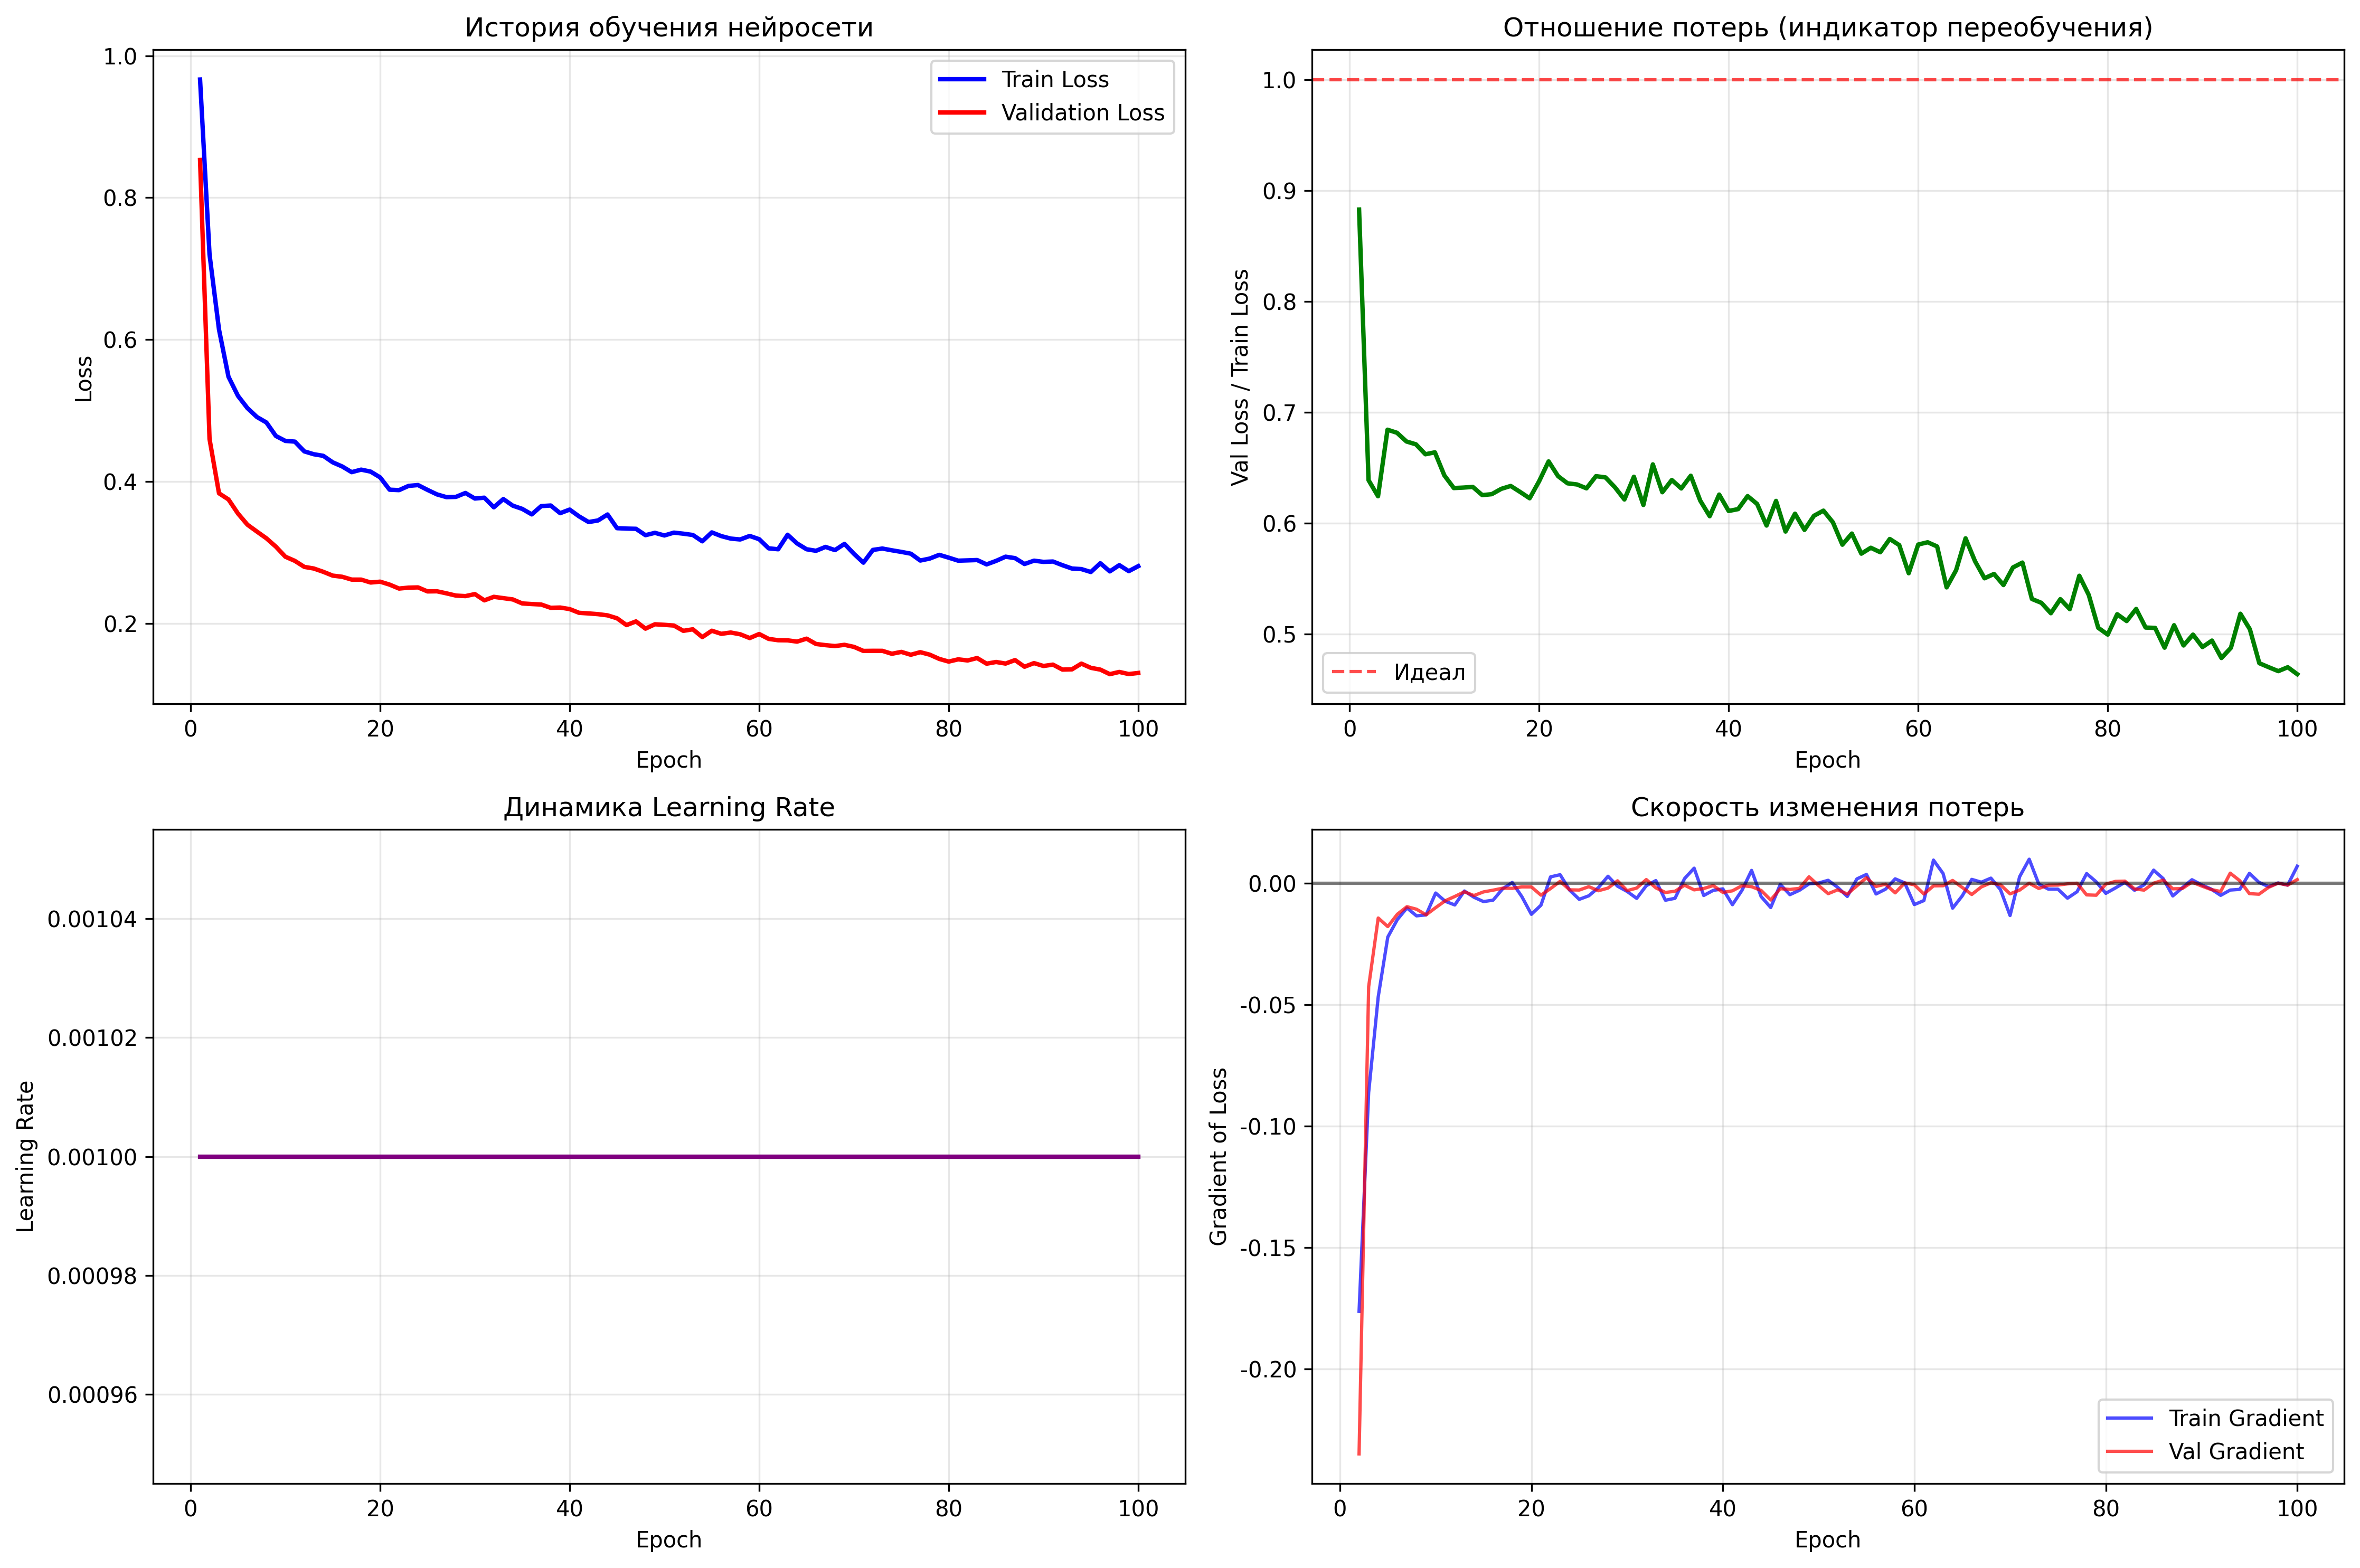

Графики обучения сохранены и показаны в консоли

ОБНАРУЖЕНИЕ АНОМАЛИЙ...
Обнаружение аномалий...
Подготовка признаков...
Обнаружено аномалий: 100 (5.00%)
Порог ошибки реконструкции: 1.6905
СТАТИСТИКА ОБНАРУЖЕНИЯ АНОМАЛИЙ
Общее количество записей: 2000
Количество аномалий: 100
Доля аномалий: 5.00%
Порог ошибки: 1.6905
Минимальная ошибка: 0.0967
Максимальная ошибка: 3.8189
Средняя ошибка: 0.9629
Медианная ошибка: 0.8924

Квантили ошибок реконструкции:
  25%: 0.6923
  50%: 0.8924
  75%: 1.1745
  90%: 1.5041
  95%: 1.6905
  99%: 2.1095

ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ...

ДЕТАЛЬНЫЙ АНАЛИЗ АНОМАЛИЙ
Всего обнаружено аномалий: 100

1. ТОП-15 аномалий по величине ошибки:
      date      product            customer  price_fca_tonne_no_grace  optimal_price_fca_tonne_no_grace  delta_price_fca_tonne_no_grace  amount_upd_tons  deviation_impact  reconstruction_error  anomaly_score
2025-06-01          Соя     АО "ЗерноТрейд"                  31237.36                      34302.860282                    

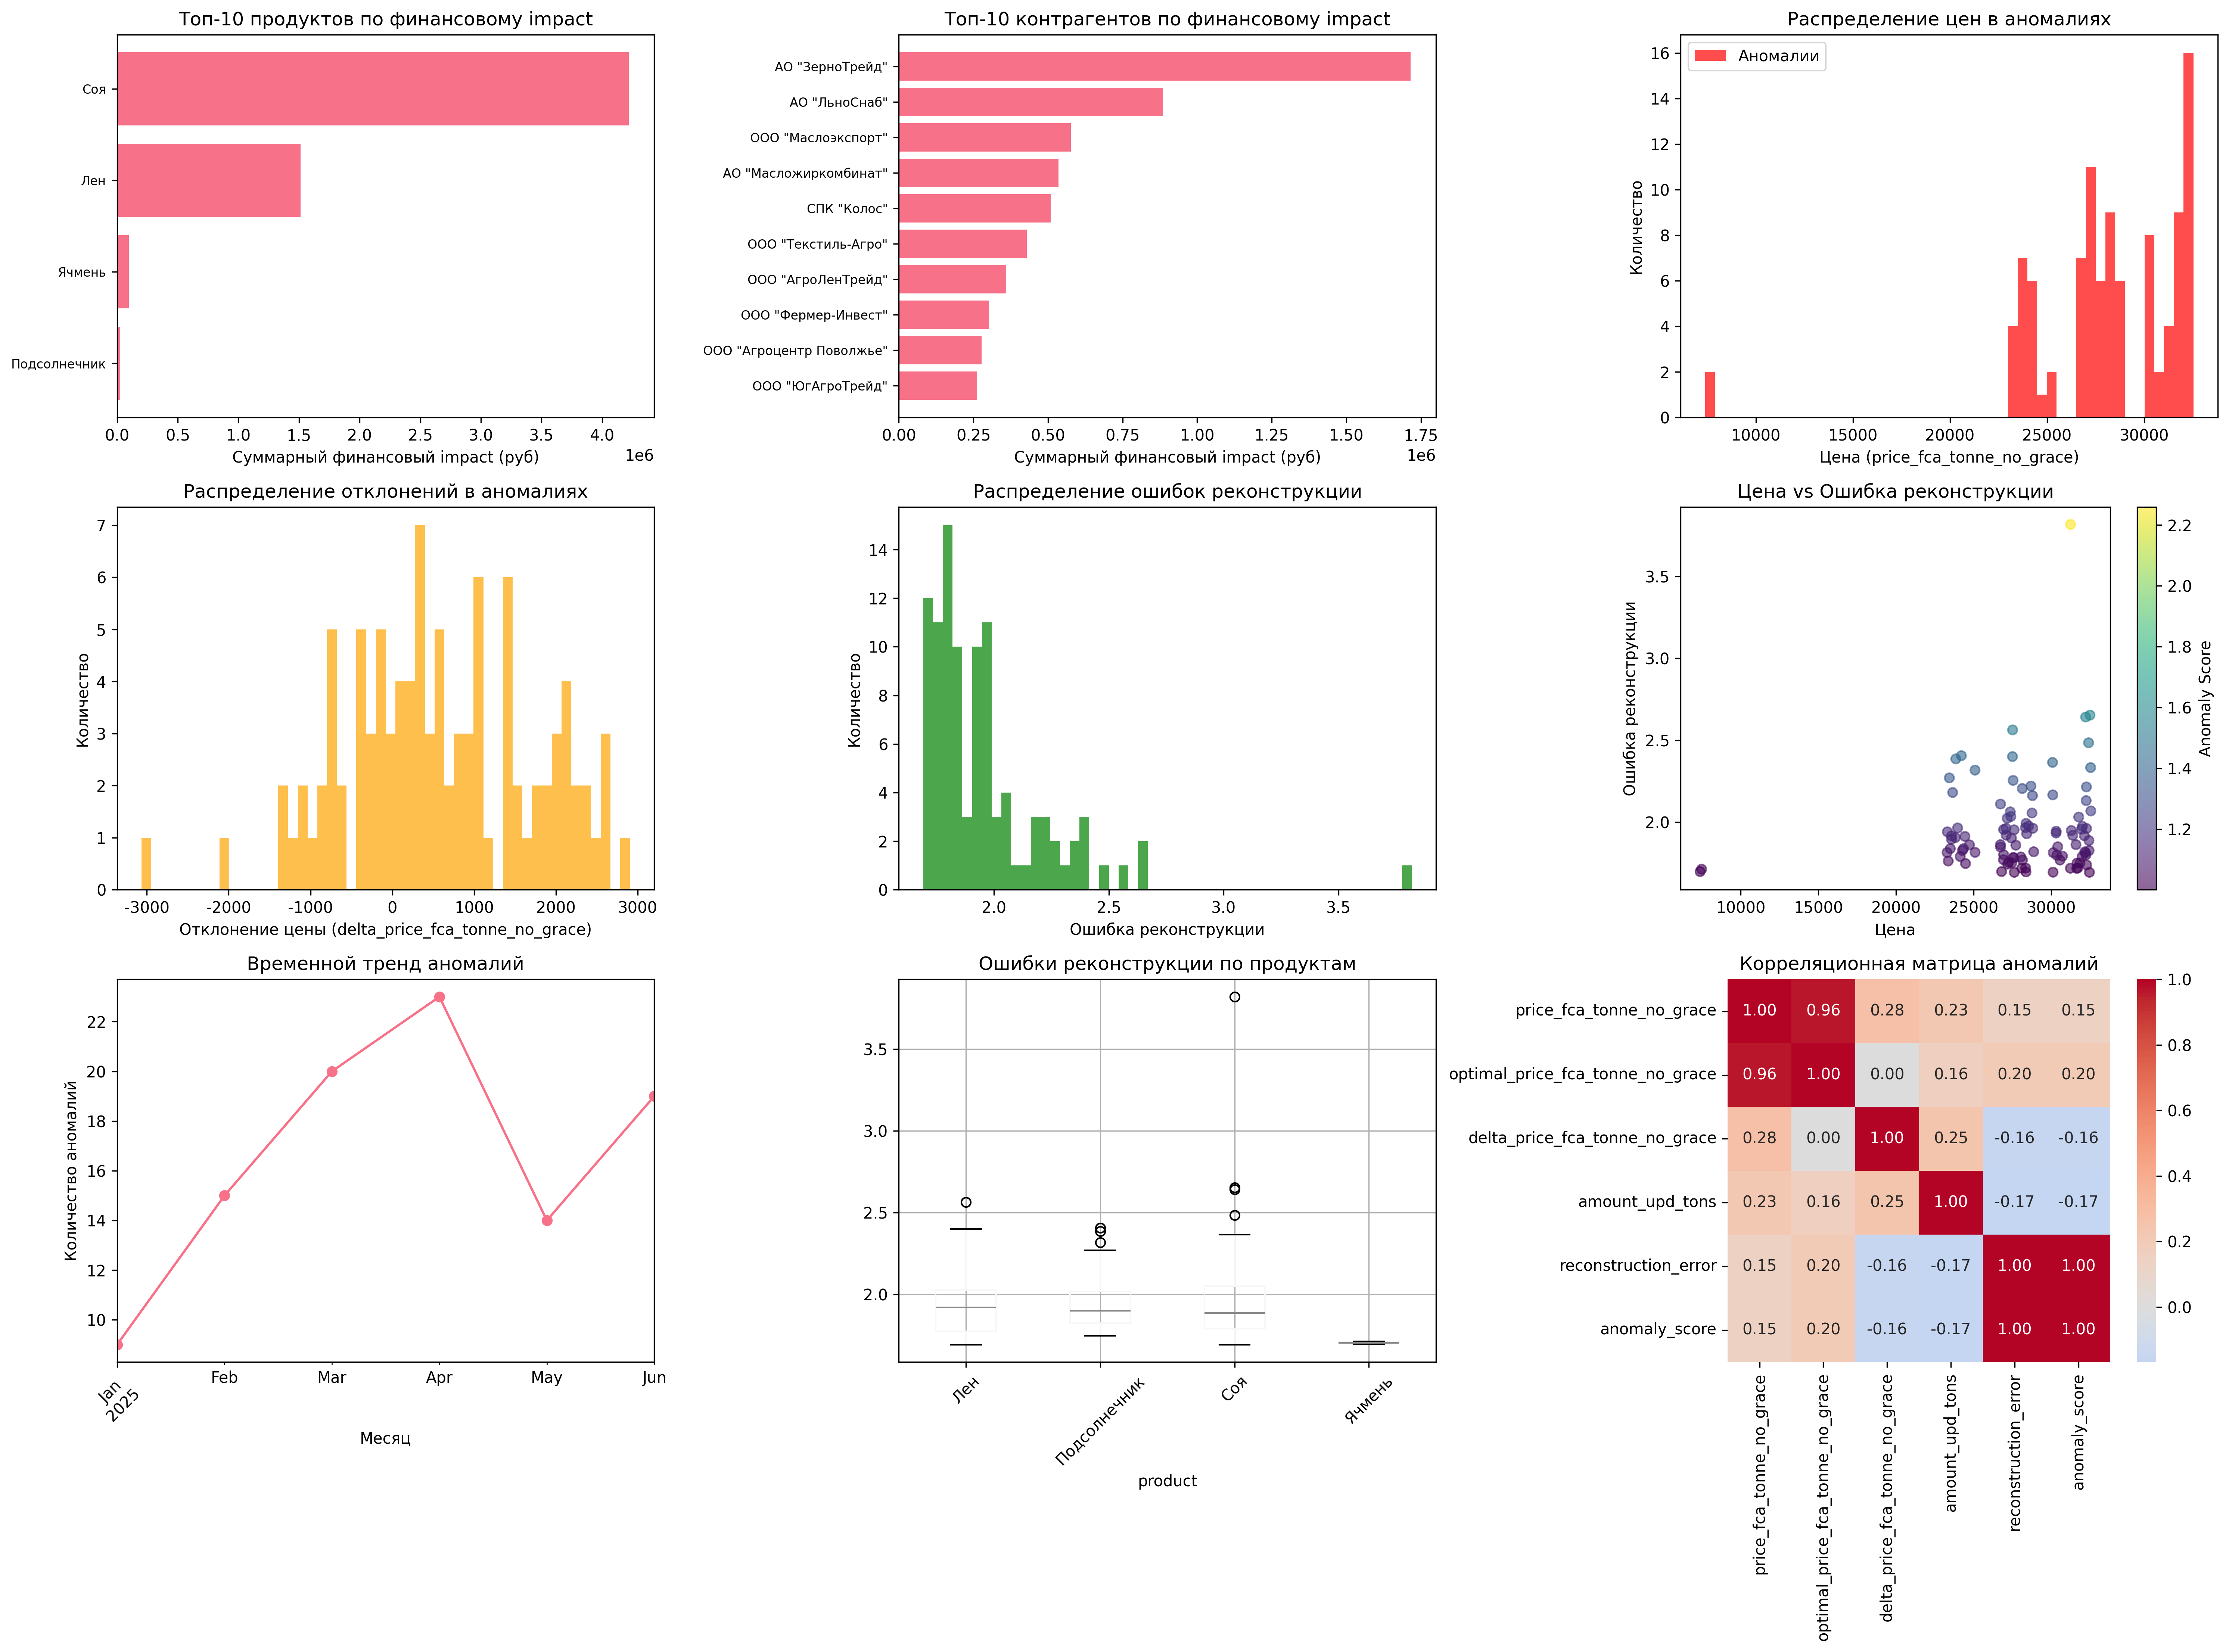

Все визуализации сохранены и показаны в консоли

СОХРАНЕНИЕ РЕЗУЛЬТАТОВ...

РЕЗУЛЬТАТЫ УСПЕШНО СОХРАНЕНЫ!
Файл: 'data/anomaly/ai_anomaly_comprehensive_output.xlsx'

СОДЕРЖАНИЕ ФАЙЛА:
   • Все_аномалии - детальный список всех аномальных записей
   • Анализ_по_продуктам - группировка по продуктам
   • Анализ_по_контрагентам - группировка по контрагентам
   • Продукты_и_контрагенты - детальная аналитика по парам продукт-контрагент
   • Сводная_статистика - общие метрики по аномалиям
   • История_обучения - полная история обучения нейросети

ИТОГИ:
   • Нейросеть успешно обучена на 2,000 записях
   • Обнаружено 100 аномалий (5.0%)
   • Финансовый impact: 5,855,572 руб.
   • Качество обучения: 0.128502 (лучшая val loss)
АНАЛИЗ УСПЕШНО ЗАВЕРШЕН! ВСЕ ГРАФИКИ И МЕТРИКИ ВЫВЕДЕНЫ В КОНСОЛЬ!


In [116]:
# 15. Анализ аномалий на основе ключевых признаков
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import os
warnings.filterwarnings('ignore')

# Добавляем импорт для дополнительных метрик
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

class SimpleAnomalyDetector(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32, 16, 8]):
        super(SimpleAnomalyDetector, self).__init__()
        
        # Энкодер
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.LeakyReLU(0.1),
                nn.Dropout(0.1)
            ])
            prev_dim = hidden_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Боттлнек
        self.bottleneck = nn.Linear(hidden_dims[-1], 4)
        
        # Декодер
        decoder_layers = []
        hidden_dims_rev = hidden_dims[::-1]
        prev_dim = 4
        for hidden_dim in hidden_dims_rev:
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.LeakyReLU(0.1),
                nn.Dropout(0.1)
            ])
            prev_dim = hidden_dim
        
        decoder_layers.append(nn.Linear(hidden_dims_rev[-1], input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        encoded = self.encoder(x)
        bottleneck = self.bottleneck(encoded)
        decoded = self.decoder(bottleneck)
        return decoded, bottleneck

class PriceAnomalyDetector:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.training_history = {}
        
    def prepare_features(self, df):
        "Подготовка признаков для нейросети - только ключевые признаки"
        print("Подготовка признаков...")
        
        data = df.copy()
        
        # 1. Основные числовые признаки
        numeric_features = [
            'price_fca_tonne_no_grace', 'amount_upd_tons', 'amount_month',
            'base_price', 'optimal_price_fca_tonne_no_grace', 'delta_price_fca_tonne_no_grace'
        ]
        
        # Оставляем только существующие колонки
        numeric_features = [col for col in numeric_features if col in data.columns]
        
        # Заполняем пропуски
        data[numeric_features] = data[numeric_features].fillna(0)
        
        # 2. Категориальные признаки (только продукт и контрагент)
        categorical_features = ['product', 'customer']
        
        for col in categorical_features:
            if col in data.columns:
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                    data[col] = self.label_encoders[col].fit_transform(data[col].astype(str))
                else:
                    try:
                        data[col] = self.label_encoders[col].transform(data[col].astype(str))
                    except ValueError:
                        data[col] = -1
        
        # 3. Собираем все фичи
        all_features = numeric_features + categorical_features
        
        # Создаем матрицу признаков
        X = data[all_features].values
        
        # Нормализуем
        if hasattr(self, 'fitted'):
            X_scaled = self.scaler.transform(X)
        else:
            X_scaled = self.scaler.fit_transform(X)
            self.fitted = True
        
        return X_scaled, all_features
    
    def train_model(self, df, epochs=50, batch_size=32, validation_split=0.2):
        "Обучение модели"
        print("Начало обучения модели...")
        
        # Подготовка данных
        X, feature_names = self.prepare_features(df)
        
        # Преобразуем в тензоры
        X_tensor = torch.FloatTensor(X)
        
        # Создаем dataset
        dataset = TensorDataset(X_tensor, X_tensor)  # Autoencoder - target = input
        
        # Разделяем на train/validation
        train_size = int((1 - validation_split) * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        # DataLoader'ы
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Инициализация модели
        input_dim = X.shape[1]
        self.model = SimpleAnomalyDetector(input_dim=input_dim)
        self.model.to(self.device)
        
        # Оптимизатор и функция потерь
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        
        # История обучения
        train_losses = []
        val_losses = []
        learning_rates = []
        
        print(f"Размерность входа: {input_dim}")
        print(f"Размер train: {len(train_dataset)}, val: {len(val_dataset)}")
        print(f"Используемое устройство: {self.device}")
        
        # Обучение
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            
            for batch_X, _ in train_loader:
                batch_X = batch_X.to(self.device)
                
                optimizer.zero_grad()
                
                # Прямой проход
                reconstructed, _ = self.model(batch_X)
                loss = criterion(reconstructed, batch_X)
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            
            # Валидация
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_X, _ in val_loader:
                    batch_X = batch_X.to(self.device)
                    
                    reconstructed, _ = self.model(batch_X)
                    loss = criterion(reconstructed, batch_X)
                    val_loss += loss.item()
            
            # Средние потери
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            learning_rates.append(optimizer.param_groups[0]['lr'])
            
            if (epoch + 1) % 10 == 0 or epoch < 5:
                print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Сохраняем историю обучения
        self.training_history = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'learning_rates': learning_rates,
            'epochs': epochs
        }
        
        # Выводим метрики качества обучения
        self.print_training_metrics(train_losses, val_losses)
        
        # График обучения
        self.plot_training_history(train_losses, val_losses, learning_rates)
        
        return train_losses, val_losses
    
    def print_training_metrics(self, train_losses, val_losses):
        "Вывод метрик качества обучения в консоль"
        print("МЕТРИКИ КАЧЕСТВА ОБУЧЕНИЯ")
        
        final_train_loss = train_losses[-1]
        final_val_loss = val_losses[-1]
        best_val_loss = min(val_losses)
        best_epoch = val_losses.index(best_val_loss) + 1
        
        print(f"Финальная train loss: {final_train_loss:.6f}")
        print(f"Финальная validation loss: {final_val_loss:.6f}")
        print(f"Лучшая validation loss: {best_val_loss:.6f} (эпоха {best_epoch})")
        print(f"Разница train/val: {abs(final_train_loss - final_val_loss):.6f}")
        
        # Анализ переобучения
        overfitting_ratio = final_val_loss / final_train_loss if final_train_loss > 0 else 1.0
        if overfitting_ratio > 1.5:
            print("ВОЗМОЖНО ПЕРЕОБУЧЕНИЕ (val_loss значительно выше train_loss)")
        elif overfitting_ratio < 0.8:
            print("ВОЗМОЖНО НЕДООБУЧЕНИЕ (val_loss значительно ниже train_loss)")
        else:
            print("СБАЛАНСИРОВАННОЕ ОБУЧЕНИЕ")
            
        # Статистика потерь
        train_loss_std = np.std(train_losses)
        val_loss_std = np.std(val_losses)
        print(f"Стандартное отклонение train loss: {train_loss_std:.6f}")
        print(f"Стандартное отклонение val loss: {val_loss_std:.6f}")
        
        # Сходимость
        last_5_train = train_losses[-5:]
        last_5_val = val_losses[-5:]
        train_convergence = max(last_5_train) - min(last_5_train)
        val_convergence = max(last_5_val) - min(last_5_val)
        
        print(f"Изменение train loss за последние 5 эпох: {train_convergence:.6f}")
        print(f"Изменение val loss за последние 5 эпох: {val_convergence:.6f}")
        
   
    def plot_training_history(self, train_losses, val_losses, learning_rates):
        "График истории обучения с дополнительными метриками"
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # График потерь
        epochs_range = range(1, len(train_losses) + 1)
        ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
        ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('История обучения нейросети')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # График отношения потерь (переобучение)
        ratios = [val/train if train > 0 else 1.0 for train, val in zip(train_losses, val_losses)]
        ax2.plot(epochs_range, ratios, 'g-', linewidth=2)
        ax2.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Идеал')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Val Loss / Train Loss')
        ax2.set_title('Отношение потерь (индикатор переобучения)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # График learning rate
        ax3.plot(epochs_range, learning_rates, 'purple', linewidth=2)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_title('Динамика Learning Rate')
        ax3.grid(True, alpha=0.3)
        
        # График производных (скорость изменения потерь)
        train_gradients = np.gradient(train_losses)
        val_gradients = np.gradient(val_losses)
        ax4.plot(epochs_range[1:], train_gradients[1:], 'b-', label='Train Gradient', alpha=0.7)
        ax4.plot(epochs_range[1:], val_gradients[1:], 'r-', label='Val Gradient', alpha=0.7)
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Gradient of Loss')
        ax4.set_title('Скорость изменения потерь')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('training_history_detailed.png', dpi=300, bbox_inches='tight')
        plt.show()  #ВЫВОДИМ ГРАФИК В КОНСОЛЬ
        plt.close()
        
        print("Графики обучения сохранены и показаны в консоли")
    
    def detect_anomalies(self, df, threshold_quantile=0.95):
        "Обнаружение аномалий в price_fca_tonne_no_grace"
        print("Обнаружение аномалий...")
        
        if self.model is None:
            raise ValueError("Модель не обучена! Сначала вызовите train_model.")
        
        X, feature_names = self.prepare_features(df)
        X_tensor = torch.FloatTensor(X).to(self.device)
        
        self.model.eval()
        with torch.no_grad():
            reconstructed, _ = self.model(X_tensor)
            
            # Вычисляем ошибку реконструкции
            reconstruction_error = torch.norm(reconstructed - X_tensor, dim=1).cpu().numpy()
            
            # Аномалии - записи с высокой ошибкой реконструкции
            threshold = np.quantile(reconstruction_error, threshold_quantile)
            anomalies = reconstruction_error > threshold
            
            # Создаем DataFrame с результатами
            results = pd.DataFrame({
                'reconstruction_error': reconstruction_error,
                'is_anomaly': anomalies,
                'anomaly_score': reconstruction_error / threshold
            })
        
        print(f"Обнаружено аномалий: {anomalies.sum()} ({anomalies.mean()*100:.2f}%)")
        print(f"Порог ошибки реконструкции: {threshold:.4f}")
        
        # Дополнительная статистика по аномалиям
        self.print_anomaly_statistics(reconstruction_error, anomalies, threshold)
        
        return results
    
    def print_anomaly_statistics(self, reconstruction_error, anomalies, threshold):
        "Вывод статистики по аномалиям"
        print("СТАТИСТИКА ОБНАРУЖЕНИЯ АНОМАЛИЙ")
        print(f"Общее количество записей: {len(reconstruction_error)}")
        print(f"Количество аномалий: {anomalies.sum()}")
        print(f"Доля аномалий: {anomalies.mean()*100:.2f}%")
        print(f"Порог ошибки: {threshold:.4f}")
        print(f"Минимальная ошибка: {reconstruction_error.min():.4f}")
        print(f"Максимальная ошибка: {reconstruction_error.max():.4f}")
        print(f"Средняя ошибка: {reconstruction_error.mean():.4f}")
        print(f"Медианная ошибка: {np.median(reconstruction_error):.4f}")
        
        # Распределение ошибок по квантилям
        quantiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
        print("\nКвантили ошибок реконструкции:")
        for q in quantiles:
            q_value = np.quantile(reconstruction_error, q)
            print(f"  {q*100:.0f}%: {q_value:.4f}")
    
    def analyze_anomalies_detailed(self, df, anomaly_results):
        "Детальный анализ аномалий с группировкой по продуктам и контрагентам"
        print("\n" + "="*60)
        print("ДЕТАЛЬНЫЙ АНАЛИЗ АНОМАЛИЙ")
        print("="*60)
        
        # Добавляем результаты к исходным данным
        df_analysis = df.copy()
        for col in anomaly_results.columns:
            df_analysis[col] = anomaly_results[col].values
        
        # Оставляем только аномалии
        anomalies_df = df_analysis[df_analysis['is_anomaly']].copy()
        
        # Добавляем финансовый impact
        anomalies_df['deviation_impact'] = anomalies_df['delta_price_fca_tonne_no_grace'] * anomalies_df['amount_upd_tons']
        
        print(f"Всего обнаружено аномалий: {len(anomalies_df)}")
        
        # Топ аномалий по ошибке реконструкции
        print("\n1. ТОП-15 аномалий по величине ошибки:")
        top_anomalies = anomalies_df.nlargest(15, 'reconstruction_error')[
            ['date', 'product', 'customer', 'price_fca_tonne_no_grace', 
             'optimal_price_fca_tonne_no_grace', 'delta_price_fca_tonne_no_grace',
             'amount_upd_tons', 'deviation_impact', 'reconstruction_error', 'anomaly_score']
        ]
        print(top_anomalies.to_string(index=False))
        
        # Группировка по продуктам
        print("\n2. АНАЛИЗ ПО ПРОДУКТАМ:")
        product_analysis = anomalies_df.groupby('product').agg({
            'is_anomaly': 'count',
            'price_fca_tonne_no_grace': ['mean', 'std'],
            'delta_price_fca_tonne_no_grace': ['mean', 'sum'],
            'amount_upd_tons': 'sum',
            'deviation_impact': 'sum',
            'reconstruction_error': 'mean'
        }).round(2)
        
        # Переименовываем колонки
        product_analysis.columns = [
            'count_anomalies', 'avg_price', 'std_price', 
            'avg_delta', 'total_delta', 'total_volume', 
            'total_impact', 'avg_reconstruction_error'
        ]
        
        product_analysis = product_analysis.sort_values('total_impact', ascending=False)
        print(product_analysis.head(10).to_string())
        
        # Группировка по контрагентам
        print("\n3. АНАЛИЗ ПО КОНТРАГЕНТАМ:")
        customer_analysis = anomalies_df.groupby('customer').agg({
            'is_anomaly': 'count',
            'price_fca_tonne_no_grace': ['mean', 'std'],
            'delta_price_fca_tonne_no_grace': ['mean', 'sum'],
            'amount_upd_tons': 'sum',
            'deviation_impact': 'sum',
            'reconstruction_error': 'mean'
        }).round(2)
        
        customer_analysis.columns = [
            'count_anomalies', 'avg_price', 'std_price', 
            'avg_delta', 'total_delta', 'total_volume', 
            'total_impact', 'avg_reconstruction_error'
        ]
        
        customer_analysis = customer_analysis.sort_values('total_impact', ascending=False)
        print(customer_analysis.head(10).to_string())
        
        # Группировка по продукту и контрагенту
        print("\n4. АНАЛИЗ ПО ПРОДУКТАМ И КОНТРАГЕНТАМ:")
        product_customer_analysis = anomalies_df.groupby(['product', 'customer']).agg({
            'is_anomaly': 'count',
            'date': ['min', 'max', 'count'],
            'price_fca_tonne_no_grace': 'mean',
            'delta_price_fca_tonne_no_grace': ['mean', 'sum'],
            'amount_upd_tons': 'sum',
            'deviation_impact': 'sum',
            'amount_month': 'mean'
        }).round(2)
        
        product_customer_analysis.columns = [
            'count_anomalies', 'first_date', 'last_date', 'transaction_count',
            'avg_price', 'avg_delta', 'total_delta', 'total_volume', 
            'total_impact', 'avg_monthly_volume'
        ]
        
        product_customer_analysis = product_customer_analysis.sort_values('total_impact', ascending=False)
        print(product_customer_analysis.head(15).to_string())
        
        return df_analysis, anomalies_df, product_analysis, customer_analysis, product_customer_analysis
    
    def create_visualizations(self, anomalies_df, product_analysis, customer_analysis):
        "Создание визуализаций для анализа"
        print("\nСоздание визуализаций...")
        
        # Создаем фигуру с несколькими графиками
        fig = plt.figure(figsize=(20, 15))
        
        # Топ продуктов по финансовому impact
        plt.subplot(3, 3, 1)
        top_products = product_analysis.nlargest(10, 'total_impact')
        plt.barh(range(len(top_products)), top_products['total_impact'])
        plt.yticks(range(len(top_products)), top_products.index, fontsize=8)
        plt.xlabel('Суммарный финансовый impact (руб)')
        plt.title('Топ-10 продуктов по финансовому impact')
        plt.gca().invert_yaxis()
        
        # Топ контрагентов по финансовому impact
        plt.subplot(3, 3, 2)
        top_customers = customer_analysis.nlargest(10, 'total_impact')
        plt.barh(range(len(top_customers)), top_customers['total_impact'])
        plt.yticks(range(len(top_customers)), top_customers.index, fontsize=8)
        plt.xlabel('Суммарный финансовый impact (руб)')
        plt.title('Топ-10 контрагентов по финансовому impact')
        plt.gca().invert_yaxis()
        
        # Распределение цен в аномалиях
        plt.subplot(3, 3, 3)
        plt.hist(anomalies_df['price_fca_tonne_no_grace'], bins=50, alpha=0.7, label='Аномалии', color='red')
        plt.xlabel('Цена (price_fca_tonne_no_grace)')
        plt.ylabel('Количество')
        plt.title('Распределение цен в аномалиях')
        plt.legend()
        
        # Распределение отклонений
        plt.subplot(3, 3, 4)
        plt.hist(anomalies_df['delta_price_fca_tonne_no_grace'], bins=50, alpha=0.7, color='orange')
        plt.xlabel('Отклонение цены (delta_price_fca_tonne_no_grace)')
        plt.ylabel('Количество')
        plt.title('Распределение отклонений в аномалиях')
        
        # Распределение ошибок реконструкции
        plt.subplot(3, 3, 5)
        plt.hist(anomalies_df['reconstruction_error'], bins=50, alpha=0.7, color='green')
        plt.xlabel('Ошибка реконструкции')
        plt.ylabel('Количество')
        plt.title('Распределение ошибок реконструкции')
        
        # Scatter plot: цена vs ошибка реконструкции
        plt.subplot(3, 3, 6)
        plt.scatter(anomalies_df['price_fca_tonne_no_grace'], anomalies_df['reconstruction_error'], 
                   alpha=0.6, c=anomalies_df['anomaly_score'], cmap='viridis')
        plt.xlabel('Цена')
        plt.ylabel('Ошибка реконструкции')
        plt.title('Цена vs Ошибка реконструкции')
        plt.colorbar(label='Anomaly Score')
        
        # Временной тренд аномалий
        plt.subplot(3, 3, 7)
        if 'date' in anomalies_df.columns:
            anomalies_df['date'] = pd.to_datetime(anomalies_df['date'])
            monthly_anomalies = anomalies_df.groupby(anomalies_df['date'].dt.to_period('M')).size()
            monthly_anomalies.plot(kind='line', marker='o')
            plt.xlabel('Месяц')
            plt.ylabel('Количество аномалий')
            plt.title('Временной тренд аномалий')
            plt.xticks(rotation=45)
        
        # Box plot ошибок реконструкции по продуктам (топ-10)
        plt.subplot(3, 3, 8)
        top_products_list = product_analysis.nlargest(10, 'count_anomalies').index
        top_products_data = anomalies_df[anomalies_df['product'].isin(top_products_list)]
        if not top_products_data.empty:
            top_products_data.boxplot(column='reconstruction_error', by='product', ax=plt.gca())
            plt.xticks(rotation=45)
            plt.title('Ошибки реконструкции по продуктам')
            plt.suptitle('') 
                    # Heatmap корреляций для аномалий
        plt.subplot(3, 3, 9)
        numeric_cols = ['price_fca_tonne_no_grace', 'optimal_price_fca_tonne_no_grace', 
                       'delta_price_fca_tonne_no_grace', 'amount_upd_tons', 
                       'reconstruction_error', 'anomaly_score']
        numeric_cols = [col for col in numeric_cols if col in anomalies_df.columns]
        
        if len(numeric_cols) > 1:
            corr_matrix = anomalies_df[numeric_cols].corr()
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                       square=True, fmt='.2f', ax=plt.gca())
            plt.title('Корреляционная матрица аномалий')
        
        plt.tight_layout()
        plt.savefig('anomaly_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
        plt.show()  #ВЫВОДИМ ГРАФИК В КОНСОЛЬ
        plt.close()
        
        print("Все визуализации сохранены и показаны в консоли")

    def print_comprehensive_metrics(self, df_with_anomalies, anomalies_df):
        """Вывод комплексных метрик качества модели"""
        print("\n" + "="*70)
        print("КОМПЛЕКСНЫЕ МЕТРИКИ КАЧЕСТВА МОДЕЛИ")
        print("="*70)
        
        # Основные метрики
        total_records = len(df_with_anomalies)
        anomaly_count = len(anomalies_df)
        anomaly_ratio = anomaly_count / total_records
        
        print(f"ОСНОВНЫЕ МЕТРИКИ:")
        print(f"   • Всего записей: {total_records:,}")
        print(f"   • Обнаружено аномалий: {anomaly_count:,}")
        print(f"   • Доля аномалий: {anomaly_ratio:.2%}")
        
        # Финансовые метрики
        if 'deviation_impact' in anomalies_df.columns:
            total_impact = anomalies_df['deviation_impact'].sum()
            avg_impact = anomalies_df['deviation_impact'].mean()
            max_impact = anomalies_df['deviation_impact'].max()
            
            print(f"\nФИНАНСОВЫЕ МЕТРИКИ:")
            print(f"   • Общий финансовый impact: {total_impact:,.0f} руб.")
            print(f"   • Средний impact на аномалию: {avg_impact:,.0f} руб.")
            print(f"   • Максимальный impact: {max_impact:,.0f} руб.")
        
        # Метрики ошибок реконструкции
        reconstruction_stats = anomalies_df['reconstruction_error'].describe()
        print(f"\nМЕТРИКИ ОШИБОК РЕКОНСТРУКЦИИ:")
        print(f"   • Средняя ошибка: {reconstruction_stats['mean']:.4f}")
        print(f"   • Стандартное отклонение: {reconstruction_stats['std']:.4f}")
        print(f"   • Минимальная ошибка: {reconstruction_stats['min']:.4f}")
        print(f"   • Максимальная ошибка: {reconstruction_stats['max']:.4f}")
        
        # Анализ распределения аномалий
        print(f"\nРАСПРЕДЕЛЕНИЕ АНОМАЛИЙ:")
        print(f"   • Уникальных продуктов с аномалиями: {anomalies_df['product'].nunique()}")
        print(f"   • Уникальных контрагентов с аномалиями: {anomalies_df['customer'].nunique()}")
        
        # Топ-5 продуктов по количеству аномалий
        top_products = anomalies_df['product'].value_counts().head(5)
        print(f"   • Топ-5 продуктов по аномалиям:")
        for product, count in top_products.items():
            print(f"      - {product}: {count} аномалий")
        
        # Эффективность обнаружения
        if 'delta_price_fca_tonne_no_grace' in anomalies_df.columns:
            large_deviations = (df_with_anomalies['delta_price_fca_tonne_no_grace'].abs() > 
                              df_with_anomalies['delta_price_fca_tonne_no_grace'].abs().quantile(0.9))
            detected_large_deviations = large_deviations & df_with_anomalies['is_anomaly']
            detection_rate = detected_large_deviations.sum() / large_deviations.sum()
            
            print(f"\nЭФФЕКТИВНОСТЬ ОБНАРУЖЕНИЯ:")
            print(f"   • Крупных отклонений (>90% перцентиль): {large_deviations.sum()}")
            print(f"   • Обнаружено крупных отклонений: {detected_large_deviations.sum()}")
            print(f"   • Эффективность обнаружения: {detection_rate:.2%}")

def main():
    "Основная функция запуска"
    try:
        # Создаем папку для результатов
        os.makedirs('data', exist_ok=True)
        
        # Инициализация детектора
        detector = PriceAnomalyDetector()
        
        print("ЗАПУСК ОБНАРУЖЕНИЯ АНОМАЛИЙ В ЦЕНАХ С НЕЙРОСЕТЬЮ")
        
        # Анализ данных перед обучением
        print("АНАЛИЗ ДАННЫХ ПЕРЕД ОБУЧЕНИЕМ:")
        print(f"   • Размер датасета: {len(df):,} записей")
        print(f"   • Количество продуктов: {df['product'].nunique()}")
        print(f"   • Количество контрагентов: {df['customer'].nunique()}")
        print(f"   • Диапазон дат: {df['date'].min()} - {df['date'].max()}")
        
        if 'price_fca_tonne_no_grace' in df.columns:
            price_stats = df['price_fca_tonne_no_grace'].describe()
            print(f"   • Диапазон цен: {price_stats['min']:,.0f} - {price_stats['max']:,.0f} руб.")
        
        # Обучение модели
        print("\nНАЧАЛО ОБУЧЕНИЯ НЕЙРОСЕТИ...")
        train_losses, val_losses = detector.train_model(
            df=df,
            epochs=100,
            batch_size=64,
            validation_split=0.2
        )
        
        # Обнаружение аномалий
        print("\nОБНАРУЖЕНИЕ АНОМАЛИЙ...")
        anomaly_results = detector.detect_anomalies(df, threshold_quantile=0.95)
        
        # Детальный анализ
        print("\nДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ...")
        df_with_anomalies, anomalies_df, product_analysis, customer_analysis, product_customer_analysis = \
            detector.analyze_anomalies_detailed(df, anomaly_results)
        
        # Комплексные метрики
        detector.print_comprehensive_metrics(df_with_anomalies, anomalies_df)
        
        # Создание визуализаций
        print("\nСОЗДАНИЕ ВИЗУАЛИЗАЦИЙ...")
        detector.create_visualizations(anomalies_df, product_analysis, customer_analysis)
        
        # Сохранение результатов в Excel
        print("\nСОХРАНЕНИЕ РЕЗУЛЬТАТОВ...")
        
        with pd.ExcelWriter('data/anomaly/ai_anomaly_comprehensive_output.xlsx') as writer:
            # Все аномалии детально
            anomalies_detailed = anomalies_df[[
                'date', 'product', 'customer', 'amount_upd_tons', 'amount_month',
                'price_fca_tonne_no_grace', 'optimal_price_fca_tonne_no_grace', 
                'delta_price_fca_tonne_no_grace', 'deviation_impact',
                'reconstruction_error', 'anomaly_score'
            ]].sort_values('deviation_impact', ascending=False)
            
            anomalies_detailed.to_excel(writer, sheet_name='Все_аномалии', index=False)
            
            # Анализ по продуктам
            product_analysis.to_excel(writer, sheet_name='Анализ_по_продуктам')
            
            # Анализ по контрагентам
            customer_analysis.to_excel(writer, sheet_name='Анализ_по_контрагентам')
            
            # Детальный анализ по продуктам и контрагентам
            product_customer_analysis.to_excel(writer, sheet_name='Продукты_и_контрагенты')
            
            # Сводная статистика
            summary_stats = pd.DataFrame({
                'Метрика': [
                    'Всего записей в данных',
                    'Обнаружено аномалий', 
                    'Доля аномалий',
                    'Общий финансовый impact',
                    'Среднее отклонение цены в аномалиях',
                    'Максимальное отклонение цены',
                    'Средняя ошибка реконструкции',
                    'Лучшая validation loss',
                    'Финальная validation loss'
                ],
                'Значение': [
                    len(df),
                    len(anomalies_df),
                    f"{len(anomalies_df)/len(df)*100:.2f}%",
                    f"{anomalies_df['deviation_impact'].sum():,.0f} руб.",
                    f"{anomalies_df['delta_price_fca_tonne_no_grace'].mean():.0f} руб.",
                    f"{anomalies_df['delta_price_fca_tonne_no_grace'].max():.0f} руб.",
                    f"{anomalies_df['reconstruction_error'].mean():.4f}",
                    f"{min(detector.training_history['val_losses']):.6f}",
                    f"{detector.training_history['val_losses'][-1]:.6f}"
                ]
            })
            summary_stats.to_excel(writer, sheet_name='Сводная_статистика', index=False)
            
            # История обучения
            training_history_df = pd.DataFrame({
                'Epoch': range(1, len(detector.training_history['train_losses']) + 1),
                'Train_Loss': detector.training_history['train_losses'],
                'Validation_Loss': detector.training_history['val_losses'],
                'Learning_Rate': detector.training_history['learning_rates']
            })
            training_history_df.to_excel(writer, sheet_name='История_обучения', index=False)
        
        print("\nРЕЗУЛЬТАТЫ УСПЕШНО СОХРАНЕНЫ!")
        print("Файл: 'data/anomaly/ai_anomaly_comprehensive_output.xlsx'")
        print("\nСОДЕРЖАНИЕ ФАЙЛА:")
        print("   • Все_аномалии - детальный список всех аномальных записей")
        print("   • Анализ_по_продуктам - группировка по продуктам") 
        print("   • Анализ_по_контрагентам - группировка по контрагентам")
        print("   • Продукты_и_контрагенты - детальная аналитика по парам продукт-контрагент")
        print("   • Сводная_статистика - общие метрики по аномалиям")
        print("   • История_обучения - полная история обучения нейросети")
        
        print(f"\nИТОГИ:")
        print(f"   • Нейросеть успешно обучена на {len(df):,} записях")
        print(f"   • Обнаружено {len(anomalies_df):,} аномалий ({len(anomalies_df)/len(df)*100:.1f}%)")
        print(f"   • Финансовый impact: {anomalies_df['deviation_impact'].sum():,.0f} руб.")
        print(f"   • Качество обучения: {min(detector.training_history['val_losses']):.6f} (лучшая val loss)")
        
        return detector, anomalies_df
        
    except Exception as e:
        print(f"Ошибка: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Запуск
if __name__ == "__main__":
    print("ЗАПУСК СИСТЕМЫ ОБНАРУЖЕНИЯ АНОМАЛИЙ С НЕЙРОСЕТЬЮ")
    print("Эта система использует настоящий AI: Autoencoder на PyTorch")
    
    detector, anomalies_df = main()
    
    if detector is not None and anomalies_df is not None:
        print("АНАЛИЗ УСПЕШНО ЗАВЕРШЕН! ВСЕ ГРАФИКИ И МЕТРИКИ ВЫВЕДЕНЫ В КОНСОЛЬ!")
    else:
        print("\nАнализ завершен с ошибками")

ЗАПУСК ОБНАРУЖЕНИЯ АНОМАЛИЙ С УЧЕТОМ ВСЕХ ФАКТОРОВ
АНАЛИЗ ДАННЫХ ПЕРЕД ОБУЧЕНИЕМ:
   • Размер датасета: 2,000 записей
   • Количество продуктов: 5
   • Количество контрагентов: 14

НАЧАЛО ОБУЧЕНИЯ НЕЙРОСЕТИ...
Начало обучения модели...
Подготовка признаков...
Используется 42 признаков:
  - Ценовые: 4
  - Финансовые: 6
  - Факторные нормы: 7
  - Фактические отклонения: 5
  - Статусы: 14
  - Категориальные: 3
Размерность входа: 42
Размер train: 1600, val: 400


Epoch 1/50: 100%|██████████| 25/25 [00:00<00:00, 48.31it/s]


Epoch 1: Train Loss: 0.914299, Val Loss: 0.773100, LR: 0.001000, Grad: 1.1788


Epoch 2/50: 100%|██████████| 25/25 [00:00<00:00, 66.88it/s]


Epoch 2: Train Loss: 0.707013, Val Loss: 0.454501, LR: 0.001000, Grad: 1.0065


Epoch 3/50: 100%|██████████| 25/25 [00:00<00:00, 71.46it/s]


Epoch 3: Train Loss: 0.586664, Val Loss: 0.413117, LR: 0.001000, Grad: 0.7577


Epoch 4/50: 100%|██████████| 25/25 [00:00<00:00, 79.77it/s]


Epoch 4: Train Loss: 0.541637, Val Loss: 0.393241, LR: 0.001000, Grad: 0.6385


Epoch 5/50: 100%|██████████| 25/25 [00:00<00:00, 93.11it/s]


Epoch 5: Train Loss: 0.520569, Val Loss: 0.379721, LR: 0.001000, Grad: 0.5586


Epoch 10/50: 100%|██████████| 25/25 [00:00<00:00, 98.80it/s]


Epoch 10: Train Loss: 0.458515, Val Loss: 0.292404, LR: 0.001000, Grad: 0.5910


Epoch 20/50: 100%|██████████| 25/25 [00:00<00:00, 80.41it/s]


Epoch 20: Train Loss: 0.387336, Val Loss: 0.234250, LR: 0.001000, Grad: 0.5468


Epoch 30/50: 100%|██████████| 25/25 [00:00<00:00, 80.28it/s]


Epoch 30: Train Loss: 0.353208, Val Loss: 0.220713, LR: 0.001000, Grad: 0.5500


Epoch 40/50: 100%|██████████| 25/25 [00:00<00:00, 92.25it/s]


Epoch 40: Train Loss: 0.338538, Val Loss: 0.212685, LR: 0.001000, Grad: 0.4645


Epoch 50/50: 100%|██████████| 25/25 [00:00<00:00, 98.42it/s]


Epoch 50: Train Loss: 0.323096, Val Loss: 0.203318, LR: 0.001000, Grad: 0.4649

РАСШИРЕННЫЕ МЕТРИКИ КАЧЕСТВА ОБУЧЕНИЯ
ОСНОВНЫЕ МЕТРИКИ:
   • Финальная train loss: 0.323096
   • Финальная validation loss: 0.203318
   • Лучшая validation loss: 0.201474 (эпоха 47)
   • Разница train/val: 0.119778

 АНАЛИЗ СХОДИМОСТИ:
   • Изменение train loss за последние 5 эпох: 0.028012
   • Изменение val loss за последние 5 эпох: 0.007317
МОДЕЛЬ ЕЩЕ НЕ СОШЛАСЬ

АНАЛИЗ ГРАДИЕНТОВ:
   • Финальная норма градиента: 0.4649
   • Средняя норма градиента: 0.5555

 АНАЛИЗ LEARNING RATE:
   • Начальный LR: 0.001000
   • Финальный LR: 0.001000
   • Снижение LR: 0.0%

СТАТИСТИКА ПОТЕРЬ:
   • Стандартное отклонение train loss: 0.103954
   • Стандартное отклонение val loss: 0.095445
   • Коэффициент вариации train: 25.4%
   • Коэффициент вариации val: 37.0%


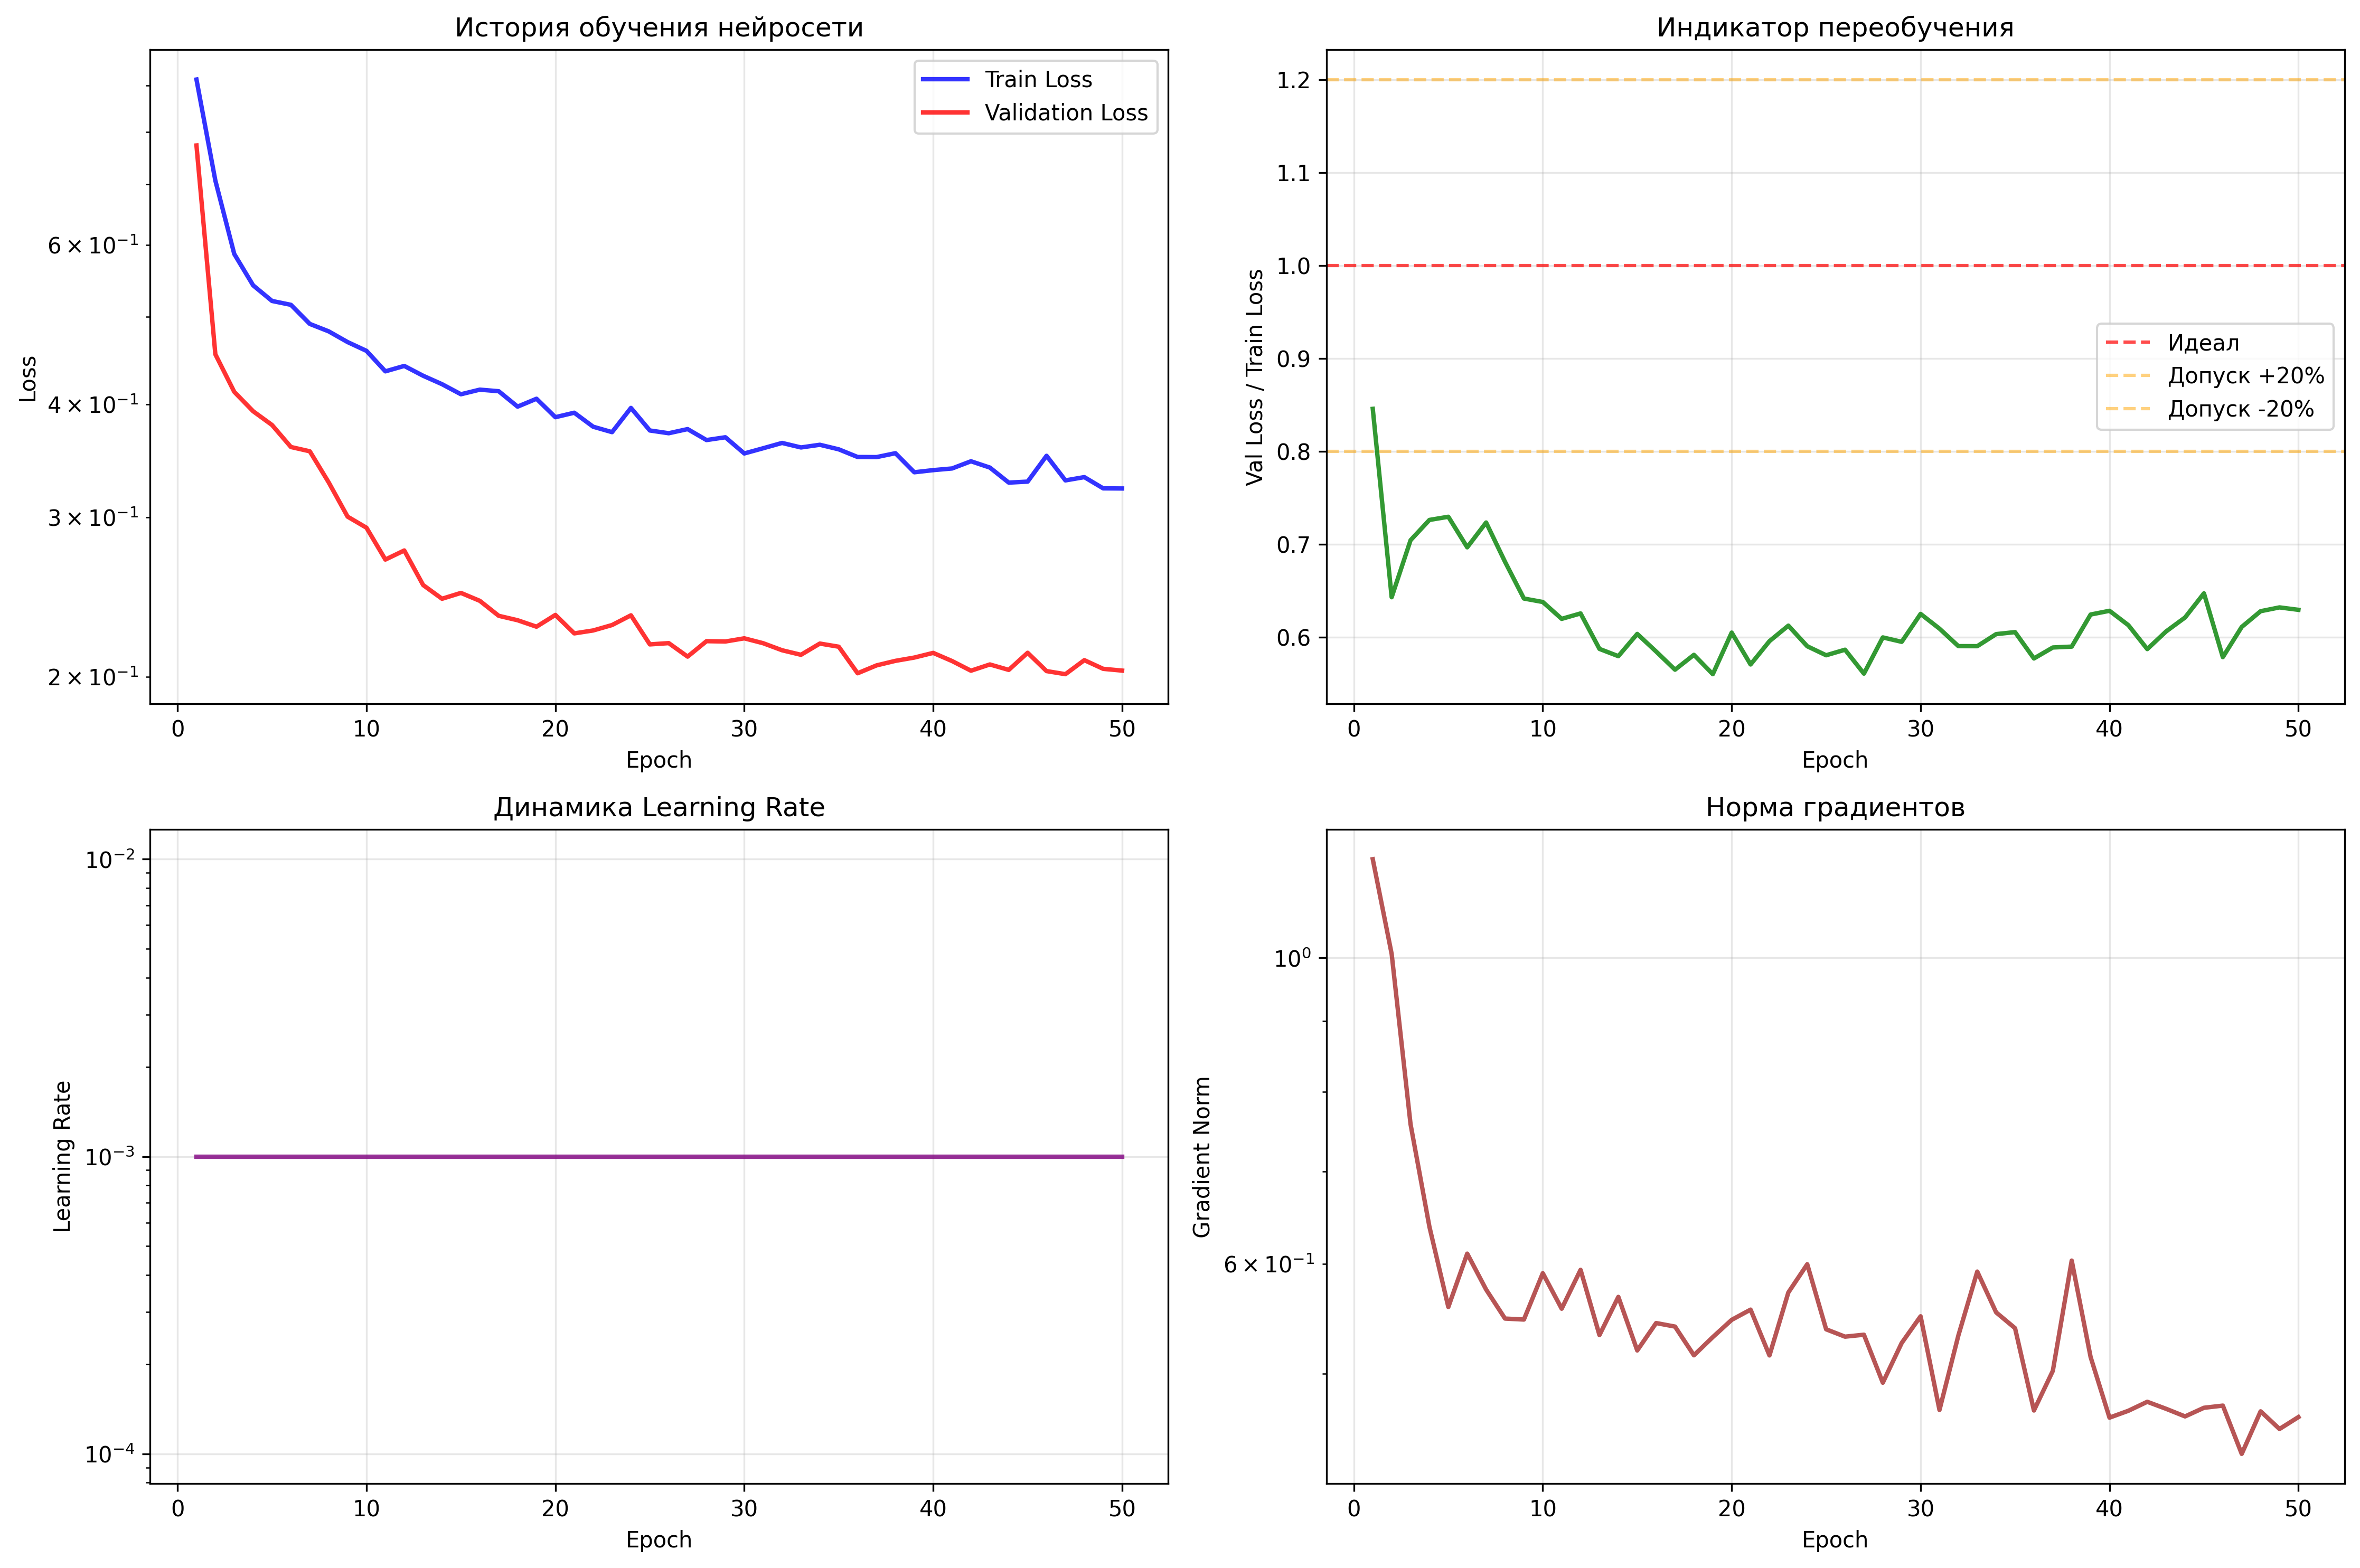

Расширенные графики обучения сохранены и показаны

ОБНАРУЖЕНИЕ АНОМАЛИЙ...
Обнаружение аномалий...
Подготовка признаков...
Используется 42 признаков:
  - Ценовые: 4
  - Финансовые: 6
  - Факторные нормы: 7
  - Фактические отклонения: 5
  - Статусы: 14
  - Категориальные: 3
Обнаружено аномалий: 100 (5.00%)
Порог ошибки реконструкции: 4.1051

ДЕТАЛЬНАЯ СТАТИСТИКА ОБНАРУЖЕНИЯ АНОМАЛИЙ
ОСНОВНЫЕ СТАТИСТИКИ:
   • Всего записей: 2,000
   • Аномалий: 100 (5.00%)
   • Порог: 4.1051

РАСПРЕДЕЛЕНИЕ ОШИБОК:
   • Минимальная ошибка: 0.8361
   • Максимальная ошибка: 62.0141
   • Средняя ошибка: 2.7773
   • Медианная ошибка: 2.4936
   • Стандартное отклонение: 2.2392
   • Асимметрия: 15.80
   • Эксцесс: 344.55
   • Распределение: Сильно право-скошенное

КВАНТИЛИ ОШИБОК:
   • 25%: 2.0992
   • 50%: 2.4936
   • 75%: 3.0400
   • 90%: 3.6276
   • 95%: 4.1051
   • 99%: 7.8859

ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ...

ДЕТАЛЬНЫЙ АНАЛИЗ АНОМАЛИЙ С УЧЕТОМ ВСЕХ ФАКТОРОВ
Всего обнаружено аномалий: 100

1. ТОП-15 АНОМАЛИ

In [123]:
# 17. Модель для анализа аномалий (много факторов)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import os
warnings.filterwarnings('ignore')

# Добавляем импорт для дополнительных метрик
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import scipy.stats as stats

class AdvancedAnomalyDetector(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32, 16]):
        super(AdvancedAnomalyDetector, self).__init__()
        
        # Энкодер
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.LeakyReLU(0.1),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Боттлнек
        self.bottleneck = nn.Linear(hidden_dims[-1], 8)
        
        # Декодер
        decoder_layers = []
        hidden_dims_rev = hidden_dims[::-1]
        prev_dim = 8
        for hidden_dim in hidden_dims_rev:
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.LeakyReLU(0.1),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        
        decoder_layers.append(nn.Linear(hidden_dims_rev[-1], input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        encoded = self.encoder(x)
        bottleneck = self.bottleneck(encoded)
        decoded = self.decoder(bottleneck)
        return decoded, bottleneck

class PriceAnomalyDetector:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.training_history = {}
        
    def prepare_features(self, df):
        "Подготовка всех признаков для нейросети"
        print("Подготовка признаков...")
        
        data = df.copy()
        
        # ОСНОВНЫЕ ЦЕНОВЫЕ ПРИЗНАКИ
        price_features = [
            'price_fca_tonne_no_grace',  # целевая переменная для аномалий
            'optimal_price_fca_tonne_no_grace', 
            'delta_price_fca_tonne_no_grace',
            'base_price'
        ]
        
        # ФИНАНСОВЫЕ И ОПЕРАЦИОННЫЕ ПРИЗНАКИ
        financial_features = [
            'opex',  # себестоимость
            'amount_upd_tons',  # объем отгрузки
            'amount_month',  # месячный объем контрагенту
            'amount_min', 'amount_big',  # пороговые объемы
            'grace_perioud'  # период отсрочки
        ]
        
        # ФАКТОРНЫЕ НОРМЫ (правила ценообразования)
        factor_norms = [
            'factor_big_deal_norm', 'factor_ip_fl_norm', 'factor_small_deal_norm',
            'factor_big_company_norm', 'factor_location_norm', 'factor_grace_norm', 'factor_opex_norm'
        ]
        
        # ФАКТИЧЕСКИЕ ОТКЛОНЕНИЯ ПО ФАКТОРАМ (в рублях)
        factor_facts = [
            'factor_big_company_fact', 'factor_big_deal_fact', 'factor_small_deal_fact',
            'factor_location_fact', 'factor_ip_fl_fact'
        ]
        
        # СТАТУСЫ ФАКТОРОВ
        status_features = [
            'fin_status_ok', 'factor_big_deal_status', 'factor_small_deal_status',
            'factor_location_status', 'factor_ip_fl_status', 'opex_status', 'upd_status'
        ]
        
        # ДОПОЛНИТЕЛЬНЫЕ ПРИЗНАКИ
        additional_features = [
            'total_distributed', 'distribution_error', 'price_fca_tonne'
        ]
        
        # Собираем все возможные признаки
        all_possible_features = (price_features + financial_features + factor_norms + 
                               factor_facts + status_features + additional_features)
        
        # Оставляем только существующие колонки
        numeric_features = [col for col in all_possible_features if col in data.columns]
        
        # Заполняем пропуски
        data[numeric_features] = data[numeric_features].fillna(0)
        
        # КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ
        categorical_features = ['product', 'customer', 'zone']
        
        for col in categorical_features:
            if col in data.columns:
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                    data[col] = self.label_encoders[col].fit_transform(data[col].astype(str))
                else:
                    try:
                        data[col] = self.label_encoders[col].transform(data[col].astype(str))
                    except ValueError:
                        data[col] = -1
        
        # ПРЕОБРАЗОВАНИЕ СТАТУСОВ В ЧИСЛА
        binary_features = status_features.copy()
        binary_features = [col for col in binary_features if col in data.columns]
        
        for col in binary_features:
            data[col] = data[col].apply(lambda x: 1 if x in ['ИСТИНА', True, 1, 'True', 'true'] else 0)
            data[col] = data[col].fillna(0)
        
        # СОБИРАЕМ ВСЕ ПРИЗНАКИ
        all_features = numeric_features + categorical_features + binary_features
        
        print(f"Используется {len(all_features)} признаков:")
        print(f"  - Ценовые: {len([f for f in all_features if f in price_features])}")
        print(f"  - Финансовые: {len([f for f in all_features if f in financial_features])}")
        print(f"  - Факторные нормы: {len([f for f in all_features if f in factor_norms])}")
        print(f"  - Фактические отклонения: {len([f for f in all_features if f in factor_facts])}")
        print(f"  - Статусы: {len([f for f in all_features if f in status_features])}")
        print(f"  - Категориальные: {len(categorical_features)}")
        
        # Создаем матрицу признаков
        X = data[all_features].values
        
        # Нормализуем
        if hasattr(self, 'fitted'):
            X_scaled = self.scaler.transform(X)
        else:
            X_scaled = self.scaler.fit_transform(X)
            self.fitted = True
        
        return X_scaled, all_features
    
    def train_model(self, df, epochs=50, batch_size=64, validation_split=0.2):
        """Обучение модели с расширенными метриками"""
        print("Начало обучения модели...")
        
        # Подготовка данных
        X, feature_names = self.prepare_features(df)
        
        # Преобразуем в тензоры
        X_tensor = torch.FloatTensor(X)
        
        # Создаем dataset
        dataset = TensorDataset(X_tensor, X_tensor)  # Autoencoder
        
        # Разделяем на train/validation
        train_size = int((1 - validation_split) * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        # DataLoader'ы
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Инициализация модели
        input_dim = X.shape[1]
        self.model = AdvancedAnomalyDetector(input_dim=input_dim)
        self.model.to(self.device)
        
        # Оптимизатор и функция потерь
        optimizer = optim.Adam(self.model.parameters(), lr=0.001, weight_decay=1e-5)
        criterion = nn.MSELoss()
        
        # Плато scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
        
        # История обучения
        train_losses = []
        val_losses = []
        learning_rates = []
        gradients_norm = []
        
        print(f"Размерность входа: {input_dim}")
        print(f"Размер train: {len(train_dataset)}, val: {len(val_dataset)}")
        
        # Обучение
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            epoch_gradients = []
            
            for batch_X, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
                batch_X = batch_X.to(self.device)
                
                optimizer.zero_grad()
                
                reconstructed, _ = self.model(batch_X)
                loss = criterion(reconstructed, batch_X)
                
                loss.backward()
                
                # Собираем статистику градиентов
                total_norm = 0
                for p in self.model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = total_norm ** 0.5
                epoch_gradients.append(total_norm)
                
                optimizer.step()
                
                train_loss += loss.item()
            
            # Валидация
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_X, _ in val_loader:
                    batch_X = batch_X.to(self.device)
                    
                    reconstructed, _ = self.model(batch_X)
                    loss = criterion(reconstructed, batch_X)
                    val_loss += loss.item()
            
            # Средние потери
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            avg_gradient = np.mean(epoch_gradients) if epoch_gradients else 0
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            learning_rates.append(optimizer.param_groups[0]['lr'])
            gradients_norm.append(avg_gradient)
            
            scheduler.step(val_loss)
            
            if (epoch + 1) % 10 == 0 or epoch < 5:
                print(f'Epoch {epoch+1}: Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {optimizer.param_groups[0]["lr"]:.6f}, Grad: {avg_gradient:.4f}')
        
        # Сохраняем историю обучения
        self.training_history = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'learning_rates': learning_rates,
            'gradients_norm': gradients_norm,
            'epochs': epochs
        }
        
        # Выводим метрики качества обучения
        self.print_training_metrics(train_losses, val_losses, learning_rates, gradients_norm)
        
        # График обучения
        self.plot_comprehensive_training_history(train_losses, val_losses, learning_rates, gradients_norm)
        
        return train_losses, val_losses

    def print_training_metrics(self, train_losses, val_losses, learning_rates, gradients_norm):
        """Вывод расширенных метрик качества обучения"""
        print("\n" + "="*70)
        print("РАСШИРЕННЫЕ МЕТРИКИ КАЧЕСТВА ОБУЧЕНИЯ")
        print("="*70)
        
        final_train_loss = train_losses[-1]
        final_val_loss = val_losses[-1]
        best_val_loss = min(val_losses)
        best_epoch = val_losses.index(best_val_loss) + 1
        
        print(f"ОСНОВНЫЕ МЕТРИКИ:")
        print(f"   • Финальная train loss: {final_train_loss:.6f}")
        print(f"   • Финальная validation loss: {final_val_loss:.6f}")
        print(f"   • Лучшая validation loss: {best_val_loss:.6f} (эпоха {best_epoch})")
        print(f"   • Разница train/val: {abs(final_train_loss - final_val_loss):.6f}")
        
        # Анализ сходимости
        last_5_train = train_losses[-5:]
        last_5_val = val_losses[-5:]
        train_convergence = max(last_5_train) - min(last_5_train)
        val_convergence = max(last_5_val) - min(last_5_val)
        
        print(f"\n АНАЛИЗ СХОДИМОСТИ:")
        print(f"   • Изменение train loss за последние 5 эпох: {train_convergence:.6f}")
        print(f"   • Изменение val loss за последние 5 эпох: {val_convergence:.6f}")
        
        convergence_threshold = 0.001
        if train_convergence < convergence_threshold and val_convergence < convergence_threshold:
            print("МОДЕЛЬ СОШЛАСЬ")
        else:
            print("МОДЕЛЬ ЕЩЕ НЕ СОШЛАСЬ")
        
        # Анализ градиентов
        final_gradient = gradients_norm[-1] if gradients_norm else 0
        avg_gradient = np.mean(gradients_norm) if gradients_norm else 0
        
        print(f"\nАНАЛИЗ ГРАДИЕНТОВ:")
        print(f"   • Финальная норма градиента: {final_gradient:.4f}")
        print(f"   • Средняя норма градиента: {avg_gradient:.4f}")
        
        if final_gradient < 0.01:
            print("ВОЗМОЖНЫ ПРОБЛЕМЫ С ГРАДИЕНТАМИ (слишком малы)")
        
        # Анализ learning rate
        final_lr = learning_rates[-1]
        initial_lr = learning_rates[0]
        lr_reduction = (initial_lr - final_lr) / initial_lr * 100
        
        print(f"\n АНАЛИЗ LEARNING RATE:")
        print(f"   • Начальный LR: {initial_lr:.6f}")
        print(f"   • Финальный LR: {final_lr:.6f}")
        print(f"   • Снижение LR: {lr_reduction:.1f}%")
        
        # Статистика потерь
        train_loss_std = np.std(train_losses)
        val_loss_std = np.std(val_losses)
        
        print(f"\nСТАТИСТИКА ПОТЕРЬ:")
        print(f"   • Стандартное отклонение train loss: {train_loss_std:.6f}")
        print(f"   • Стандартное отклонение val loss: {val_loss_std:.6f}")
        print(f"   • Коэффициент вариации train: {(train_loss_std/np.mean(train_losses))*100:.1f}%")
        print(f"   • Коэффициент вариации val: {(val_loss_std/np.mean(val_losses))*100:.1f}%")

    def plot_comprehensive_training_history(self, train_losses, val_losses, learning_rates, gradients_norm):
        """Расширенная визуализация истории обучения"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        epochs_range = range(1, len(train_losses) + 1)
        
        # 1. Основные потери
        ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2, alpha=0.8)
        ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('История обучения нейросети')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_yscale('log')  # Логарифмическая шкала для лучшей визуализации
        
        # 2. Отношение потерь (индикатор переобучения)
        ratios = [val/train if train > 0 else 1.0 for train, val in zip(train_losses, val_losses)]
        ax2.plot(epochs_range, ratios, 'g-', linewidth=2, alpha=0.8)
        ax2.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Идеал')
        ax2.axhline(y=1.2, color='orange', linestyle='--', alpha=0.5, label='Допуск +20%')
        ax2.axhline(y=0.8, color='orange', linestyle='--', alpha=0.5, label='Допуск -20%')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Val Loss / Train Loss')
        ax2.set_title('Индикатор переобучения')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Learning Rate
        ax3.plot(epochs_range, learning_rates, 'purple', linewidth=2, alpha=0.8)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_title('Динамика Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)
        
        # 4. Норма градиентов
        ax4.plot(epochs_range, gradients_norm, 'brown', linewidth=2, alpha=0.8)
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Gradient Norm')
        ax4.set_title('Норма градиентов')
        ax4.set_yscale('log')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('data/comprehensive_training_history.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
        print("Расширенные графики обучения сохранены и показаны")

    def detect_anomalies(self, df, threshold_quantile=0.95):
        """Обнаружение аномалий с расширенной статистикой"""
        print("Обнаружение аномалий...")
        
        if self.model is None:
            raise ValueError("Модель не обучена! Сначала вызовите train_model.")
        
        X, feature_names = self.prepare_features(df)
        X_tensor = torch.FloatTensor(X).to(self.device)
        
        self.model.eval()
        with torch.no_grad():
            reconstructed, bottleneck = self.model(X_tensor)
            
            # Вычисляем ошибку реконструкции
            reconstruction_error = torch.norm(reconstructed - X_tensor, dim=1).cpu().numpy()
            
            # Аномалии - записи с высокой ошибкой реконструкции
            threshold = np.quantile(reconstruction_error, threshold_quantile)
            anomalies = reconstruction_error > threshold
            
            # Создаем DataFrame с результатами
            results = pd.DataFrame({
                'reconstruction_error': reconstruction_error,
                'is_anomaly': anomalies,
                'anomaly_score': reconstruction_error / threshold,
                'anomaly_percentile': reconstruction_error / np.max(reconstruction_error) * 100
            })
        
        print(f"Обнаружено аномалий: {anomalies.sum()} ({anomalies.mean()*100:.2f}%)")
        print(f"Порог ошибки реконструкции: {threshold:.4f}")
        
        # Расширенная статистика
        self.print_detailed_anomaly_stats(reconstruction_error, anomalies, threshold)
        
        return results

    def print_detailed_anomaly_stats(self, reconstruction_error, anomalies, threshold):
        """Вывод детальной статистики по аномалиям"""
        print("\n" + "="*60)
        print("ДЕТАЛЬНАЯ СТАТИСТИКА ОБНАРУЖЕНИЯ АНОМАЛИЙ")
        print("="*60)
        
        error_stats = {
            'min': np.min(reconstruction_error),
            'max': np.max(reconstruction_error),
            'mean': np.mean(reconstruction_error),
            'median': np.median(reconstruction_error),
            'std': np.std(reconstruction_error),
            'skewness': stats.skew(reconstruction_error),
            'kurtosis': stats.kurtosis(reconstruction_error)
        }
        
        print(f"ОСНОВНЫЕ СТАТИСТИКИ:")
        print(f"   • Всего записей: {len(reconstruction_error):,}")
        print(f"   • Аномалий: {anomalies.sum():,} ({anomalies.mean()*100:.2f}%)")
        print(f"   • Порог: {threshold:.4f}")
        
        print(f"\nРАСПРЕДЕЛЕНИЕ ОШИБОК:")
        print(f"   • Минимальная ошибка: {error_stats['min']:.4f}")
        print(f"   • Максимальная ошибка: {error_stats['max']:.4f}")
        print(f"   • Средняя ошибка: {error_stats['mean']:.4f}")
        print(f"   • Медианная ошибка: {error_stats['median']:.4f}")
        print(f"   • Стандартное отклонение: {error_stats['std']:.4f}")
        print(f"   • Асимметрия: {error_stats['skewness']:.2f}")
        print(f"   • Эксцесс: {error_stats['kurtosis']:.2f}")
        
        # Анализ распределения
        if error_stats['skewness'] > 1:
            print("   • Распределение: Сильно право-скошенное")
        elif error_stats['skewness'] > 0.5:
            print("   • Распределение: Умеренно право-скошенное")
        elif abs(error_stats['skewness']) <= 0.5:
            print("   • Распределение: Примерно симметричное")
        else:
            print("   • Распределение: Лево-скошенное")
            
        # Квантили
        print(f"\nКВАНТИЛИ ОШИБОК:")
        quantiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
        for q in quantiles:
            q_value = np.quantile(reconstruction_error, q)
            print(f"   • {q*100:2.0f}%: {q_value:.4f}")

    def analyze_anomalies_detailed(self, df, anomaly_results):
            "Детальный анализ аномалий с учетом всех факторов"
            print("\n" + "="*60)
            print("ДЕТАЛЬНЫЙ АНАЛИЗ АНОМАЛИЙ С УЧЕТОМ ВСЕХ ФАКТОРОВ")
            print("="*60)
            
            # Добавляем результаты к исходным данным
            df_analysis = df.copy()
            for col in anomaly_results.columns:
                df_analysis[col] = anomaly_results[col].values
            
            # Оставляем только аномалии
            anomalies_df = df_analysis[df_analysis['is_anomaly']].copy()
            
            # Добавляем финансовый impact
            anomalies_df['deviation_impact'] = anomalies_df['delta_price_fca_tonne_no_grace'] * anomalies_df['amount_upd_tons']
            
            print(f"Всего обнаружено аномалий: {len(anomalies_df)}")
            
            # Топ аномалий по ошибке реконструкции
            print("\n1. ТОП-15 АНОМАЛИЙ ПО ВЕЛИЧИНЕ ОШИБКИ:")
            top_anomalies = anomalies_df.nlargest(15, 'reconstruction_error')[
                ['date', 'product', 'customer', 'price_fca_tonne_no_grace', 
                'optimal_price_fca_tonne_no_grace', 'delta_price_fca_tonne_no_grace',
                'amount_upd_tons', 'deviation_impact', 'reconstruction_error', 'anomaly_score']
            ]
            print(top_anomalies.to_string(index=False))
            
            # АНАЛИЗ ПО ФАКТОРАМ РИСКА
            print("\n2. АНАЛИЗ ФАКТОРОВ РИСКА В АНОМАЛИЯХ:")
            
            # Статусы факторов в аномалиях - ИСПРАВЛЕННАЯ ВЕРСИЯ
            status_columns = ['fin_status_ok', 'factor_big_deal_status', 'factor_small_deal_status',
                            'factor_location_status', 'factor_ip_fl_status', 'opex_status']
            
            status_analysis = {}
            for status_col in status_columns:
                if status_col in anomalies_df.columns:
                    # Безопасное преобразование статусов в числовой формат
                    triggered = 0
                    total = len(anomalies_df)
                    
                    for status_value in anomalies_df[status_col]:
                        if status_value in ['ИСТИНА', True, 1, 'True', 'true', 'TRUE']:
                            triggered += 1
                        # Также считаем числовые значения
                        elif isinstance(status_value, (int, float)) and status_value > 0:
                            triggered += 1
                    
                    status_analysis[status_col] = {
                        'triggered': triggered,
                        'percentage': (triggered / total * 100) if total > 0 else 0
                    }
            
            print("Сработавшие статусы в аномалиях:")
            for status, stats in status_analysis.items():
                print(f"  {status}: {stats['triggered']} раз ({stats['percentage']:.1f}%)")
            
            # АНАЛИЗ ФАКТИЧЕСКИХ ОТКЛОНЕНИЙ ПО ФАКТОРАМ
            print("\n3. ФАКТИЧЕСКИЕ ОТКЛОНЕНИЯ ПО ФАКТОРАМ:")
            factor_columns = ['factor_big_company_fact', 'factor_big_deal_fact', 
                            'factor_small_deal_fact', 'factor_location_fact', 'factor_ip_fl_fact']
            
            # Проверяем существование колонок перед анализом
            existing_factor_cols = [col for col in factor_columns if col in anomalies_df.columns]
            if existing_factor_cols:
                factor_analysis = anomalies_df[existing_factor_cols].describe()
                print(factor_analysis.round(2))
            else:
                print("  Факторные колонки не найдены в данных")
            
            # ГРУППИРОВКА ПО ПРОДУКТАМ
            print("\n4. АНАЛИЗ ПО ПРОДУКТАМ:")
            if 'product' in anomalies_df.columns:
                product_analysis = anomalies_df.groupby('product').agg({
                    'is_anomaly': 'count',
                    'price_fca_tonne_no_grace': ['mean', 'std'],
                    'delta_price_fca_tonne_no_grace': ['mean', 'sum'],
                    'amount_upd_tons': 'sum',
                    'deviation_impact': 'sum',
                    'reconstruction_error': 'mean'
                }).round(2)
                
                # Переименовываем колонки
                product_analysis.columns = [
                    'count_anomalies', 'avg_price', 'std_price', 
                    'avg_delta', 'total_delta', 'total_volume', 
                    'total_impact', 'avg_reconstruction_error'
                ]
                
                product_analysis = product_analysis.sort_values('total_impact', ascending=False)
                print(product_analysis.head(10).to_string())
            else:
                print("  Колонка 'product' не найдена в данных")
            
            return df_analysis, anomalies_df, product_analysis if 'product' in anomalies_df.columns else None

    def create_comprehensive_visualizations(self, anomalies_df, product_analysis):
        """Создание комплексных визуализаций с метриками качества"""
        print("\nСоздание комплексных визуализаций...")
        
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Топ продуктов по финансовому impact
        plt.subplot(3, 3, 1)
        top_products = product_analysis.nlargest(10, 'total_impact')
        bars = plt.barh(range(len(top_products)), top_products['total_impact'])
        plt.yticks(range(len(top_products)), top_products.index, fontsize=8)
        plt.xlabel('Финансовый impact (руб)')
        plt.title('Топ-10 продуктов по финансовому impact')
        plt.gca().invert_yaxis()
        
        # Добавляем значения на бары
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:,.0f}', 
                    ha='left', va='center', fontsize=8)
        
        # 2. Распределение ошибок реконструкции
        plt.subplot(3, 3, 2)
        n, bins, patches = plt.hist(anomalies_df['reconstruction_error'], bins=50, 
                                   alpha=0.7, color='skyblue', edgecolor='black')
        plt.xlabel('Ошибка реконструкции')
        plt.ylabel('Количество')
        plt.title('Распределение ошибок реконструкции')
        
        # Добавляем вертикальную линию порога
        threshold = np.quantile(anomalies_df['reconstruction_error'], 0.95)
        plt.axvline(threshold, color='red', linestyle='--', 
                   label=f'Порог (95%): {threshold:.2f}')
        plt.legend()
        
        # 3. Цена vs Ошибка реконструкции
        plt.subplot(3, 3, 3)
        scatter = plt.scatter(anomalies_df['price_fca_tonne_no_grace'], 
                            anomalies_df['reconstruction_error'],
                            c=anomalies_df['anomaly_score'], cmap='viridis', 
                            alpha=0.6, s=50)
        plt.colorbar(scatter, label='Anomaly Score')
        plt.xlabel('Цена (price_fca_tonne_no_grace)')
        plt.ylabel('Ошибка реконструкции')
        plt.title('Цена vs Ошибка реконструкции')
        
        # 4. Финансовый impact по продуктам (круговая диаграмма)
        plt.subplot(3, 3, 4)
        top_10_impact = product_analysis.nlargest(10, 'total_impact')
        if len(top_10_impact) > 0:
            plt.pie(top_10_impact['total_impact'], labels=top_10_impact.index, 
                   autopct='%1.1f%%', startangle=90)
            plt.title('Распределение финансового impact по продуктам')
        
        # 5. Временной тренд аномалий
        plt.subplot(3, 3, 5)
        if 'date' in anomalies_df.columns:
            anomalies_df['date'] = pd.to_datetime(anomalies_df['date'])
            monthly_anomalies = anomalies_df.groupby(anomalies_df['date'].dt.to_period('M')).size()
            monthly_anomalies.plot(kind='line', marker='o', color='orange')
            plt.xlabel('Месяц')
            plt.ylabel('Количество аномалий')
            plt.title('Временной тренд аномалий')
            plt.xticks(rotation=45)
        
        # 6. Heatmap корреляций для аномалий
        plt.subplot(3, 3, 6)
        numeric_cols = ['price_fca_tonne_no_grace', 'optimal_price_fca_tonne_no_grace', 
                       'delta_price_fca_tonne_no_grace', 'amount_upd_tons', 
                       'reconstruction_error', 'anomaly_score']
        numeric_cols = [col for col in numeric_cols if col in anomalies_df.columns]
        
        if len(numeric_cols) > 1:
            corr_matrix = anomalies_df[numeric_cols].corr()
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                       square=True, fmt='.2f', ax=plt.gca())
            plt.title('Корреляционная матрица аномалий')
        
        # 7. Распределение объемов отгрузок
        plt.subplot(3, 3, 7)
        plt.hist(anomalies_df['amount_upd_tons'], bins=30, alpha=0.7, color='green')
        plt.xlabel('Объем отгрузки (тонны)')
        plt.ylabel('Количество')
        plt.title('Распределение объемов в аномалиях')
        
        # 8. Anomaly Score распределение
        plt.subplot(3, 3, 8)
        n, bins, patches = plt.hist(anomalies_df['anomaly_score'], bins=30, 
                                   alpha=0.7, color='purple')
        plt.xlabel('Anomaly Score')
        plt.ylabel('Количество')
        plt.title('Распределение Anomaly Score')
        plt.axvline(1.0, color='red', linestyle='--', label='Порог = 1.0')
        plt.legend()
        
        # 9. Статусы факторов в аномалиях
        plt.subplot(3, 3, 9)
        status_columns = ['fin_status_ok', 'factor_big_deal_status', 'factor_small_deal_status',
                         'factor_location_status', 'factor_ip_fl_status', 'opex_status']
        status_columns = [col for col in status_columns if col in anomalies_df.columns]
        
        if status_columns:
            status_counts = anomalies_df[status_columns].sum()
            status_counts.plot(kind='bar', color='lightcoral')
            plt.xlabel('Факторы')
            plt.ylabel('Количество срабатываний')
            plt.title('Срабатывания факторов в аномалиях')
            plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig('data/comprehensive_anomaly_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
        print("Комплексные визуализации сохранены и показаны")

def main():
    "Основная функция запуска с расширенной аналитикой"
    try:
        # Создаем папку для результатов
        os.makedirs('data', exist_ok=True)
        
        # Инициализация детектора
        detector = PriceAnomalyDetector()
        
        print("ЗАПУСК ОБНАРУЖЕНИЯ АНОМАЛИЙ С УЧЕТОМ ВСЕХ ФАКТОРОВ")
        
        # Анализ данных перед обучением
        print("АНАЛИЗ ДАННЫХ ПЕРЕД ОБУЧЕНИЕМ:")
        print(f"   • Размер датасета: {len(df):,} записей")
        print(f"   • Количество продуктов: {df['product'].nunique()}")
        print(f"   • Количество контрагентов: {df['customer'].nunique()}")
        
        # Обучение модели
        print("\nНАЧАЛО ОБУЧЕНИЯ НЕЙРОСЕТИ...")
        train_losses, val_losses = detector.train_model(
            df=df,
            epochs=50,
            batch_size=64,
            validation_split=0.2
        )
        
        # Обнаружение аномалий
        print("\nОБНАРУЖЕНИЕ АНОМАЛИЙ...")
        anomaly_results = detector.detect_anomalies(df, threshold_quantile=0.95)
        
        # Детальный анализ
        print("\nДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ...")
        df_with_anomalies, anomalies_df, product_analysis = \
            detector.analyze_anomalies_detailed(df, anomaly_results)
        
        # Создание визуализаций
        #print("\nСОЗДАНИЕ КОМПЛЕКСНЫХ ВИЗУАЛИЗАЦИЙ...")
        #detector.create_comprehensive_visualizations(anomalies_df, product_analysis)
        
        # Сохранение результатов
        print("\nСОХРАНЕНИЕ РЕЗУЛЬТАТОВ...")
        
        with pd.ExcelWriter('data/anomaly/ai_anomaly_all_factors_comprehensive.xlsx') as writer:
            anomalies_df.to_excel(writer, sheet_name='Все_аномалии', index=False)
            product_analysis.to_excel(writer, sheet_name='Анализ_по_продуктам')
            
            # Сохраняем историю обучения
            training_history = pd.DataFrame(detector.training_history)
            training_history.to_excel(writer, sheet_name='История_обучения', index=False)
        
        print("\nАНАЛИЗ УСПЕШНО ЗАВЕРШЕН!")
        print("Все графики и метрики выведены в консоль")
        print("Результаты сохранены в папке 'data/anomaly/'")
        
        return detector, anomalies_df
        
    except Exception as e:
        print(f"Ошибка: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Запуск
if __name__ == "__main__":
    detector, anomalies_df = main()

In [124]:
# 17. Эдастичность объема и цены 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
import warnings
import os
from datetime import datetime
warnings.filterwarnings('ignore')

class CompletePriceElasticityAnalyzer:
    def __init__(self):
        self.model = None
        self.scaler_X = RobustScaler()
        self.scaler_y = RobustScaler()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.results_dir = 'data/elast'
        
    def ensure_directory(self):
        "Создание папки для результатов"
        os.makedirs(self.results_dir, exist_ok=True)
        print(f"Папка для результатов: {self.results_dir}")
        
    def load_data(self):
        "Загрузка данных"
        print("Загрузка данных...")
        
        self.emiss_price_df = pd.read_excel('data/emiss_price.xlsx')
        self.emiss_value_df = pd.read_excel('data/emiss_value.xlsx') 
        
        # Основные данные продаж
        self.sales_df = df.copy()
        self.sales_df['date'] = pd.to_datetime(self.sales_df['date'])
        self.sales_df['year'] = self.sales_df['date'].dt.year
        self.sales_df['month'] = self.sales_df['date'].dt.month
        
        print(f"Данные загружены: цены={len(self.emiss_price_df)}, объемы={len(self.emiss_value_df)}, продажи={len(self.sales_df)}")
        
    def preprocess_data(self):
        "Предобработка данных"
        print("\nПредобработка данных...")
        
        # Объединение данных
        self.combined_emiss_df = pd.merge(
            self.emiss_price_df, self.emiss_value_df, on=['year', 'month'], how='inner'
        )
        
        # Создание признаков
        self.combined_emiss_df['period'] = self.combined_emiss_df['year'] + (self.combined_emiss_df['month'] - 1) / 12
        self.combined_emiss_df['sin_month'] = np.sin(2 * np.pi * self.combined_emiss_df['month'] / 12)
        self.combined_emiss_df['cos_month'] = np.cos(2 * np.pi * self.combined_emiss_df['month'] / 12)
        
        # Лаговые признаки
        for lag in [1, 2, 3]:
            self.combined_emiss_df[f'price_1_lag_{lag}'] = self.combined_emiss_df['price_1'].shift(lag)
            self.combined_emiss_df[f'value_lag_{lag}'] = self.combined_emiss_df['value'].shift(lag)
        
        # Скользящие средние
        for window in [3, 6]:
            self.combined_emiss_df[f'price_1_ma_{window}'] = self.combined_emiss_df['price_1'].rolling(window).mean()
        
        print("Данные подготовлены")
        
    def prepare_training_data(self):
        "Подготовка данных для обучения"
        print("\nПодготовка данных для обучения...")
        
        train_data = self.combined_emiss_df.dropna().copy()
        
        # Признаки
        feature_columns = [
            'month', 'sin_month', 'cos_month', 'value',
            'price_lag_1', 'price_lag_2', 'price_lag_3',
            'price_ma_3', 'price_ma_6'
        ]
        feature_columns = [col for col in feature_columns if col in train_data.columns]
        
        X = train_data[feature_columns].values
        y = train_data['price_1'].values.reshape(-1, 1)
        
        print(f"Данные подготовлены: X{X.shape}, y{y.shape}")
        
        return X, y, feature_columns
    
    def train_model(self, X, y, feature_names):
        """Обучение модели"""
        print(f"\nОбучение модели...")
        
        # Кросс-валидация
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            print(f"Fold {fold + 1}")
            
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Масштабирование
            scaler_X = RobustScaler()
            scaler_y = RobustScaler()
            
            X_train_scaled = scaler_X.fit_transform(X_train)
            X_val_scaled = scaler_X.transform(X_val)
            y_train_scaled = scaler_y.fit_transform(y_train)
            y_val_scaled = scaler_y.transform(y_val)
            
            # Простая нейросеть
            model = self.create_simple_model(X_train_scaled.shape[1])
            model = self.train_simple_model(model, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)
            
            # Оценка
            predictions = self.predict_model(model, X_val_scaled, scaler_y)
            r2 = r2_score(y_val, predictions)
            fold_scores.append(r2)
            
            if fold == 0:  # Сохраняем первую модель
                self.model = model
                self.scaler_X = scaler_X
                self.scaler_y = scaler_y
        
        mean_r2 = np.mean(fold_scores)
        print(f"Обучение завершено. Средний R²: {mean_r2:.4f}")
        return mean_r2
    
    def create_simple_model(self, input_dim):
        "Создание простой модели"
        return nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def train_simple_model(self, model, X_train, y_train, X_val, y_val, epochs=100):
        "Простое обучение"
        model.to(self.device)
        
        X_train_tensor = torch.FloatTensor(X_train).to(self.device)
        y_train_tensor = torch.FloatTensor(y_train).to(self.device)
        X_val_tensor = torch.FloatTensor(X_val).to(self.device)
        y_val_tensor = torch.FloatTensor(y_val).to(self.device)
        
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        
        train_losses = []
        val_losses = []
        
        for epoch in range(epochs):
            # Train
            model.train()
            optimizer.zero_grad()
            predictions = model(X_train_tensor)
            loss = criterion(predictions, y_train_tensor)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            
            # Validation
            model.eval()
            with torch.no_grad():
                val_predictions = model(X_val_tensor)
                val_loss = criterion(val_predictions, y_val_tensor).item()
                val_losses.append(val_loss)
            
            if (epoch + 1) % 20 == 0:
                print(f' Epoch {epoch+1}: Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')
        
        # Сохранение графика обучения
        self.save_training_plot(train_losses, val_losses)
        
        return model
    
    def predict_model(self, model, X, scaler_y):
        "Предсказание модели"
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            predictions_scaled = model(X_tensor).cpu().numpy()
            return scaler_y.inverse_transform(predictions_scaled)
    
    def forecast_2025(self, feature_names):
        "Прогноз на 2025"
        print("\n Прогноз на 2025 год...")
        
        forecast_data = []
        last_data = self.combined_emiss_df.tail(12).copy()
        
        for month in range(1, 7):
            features = {}
            features['month'] = month
            features['sin_month'] = np.sin(2 * np.pi * month / 12)
            features['cos_month'] = np.cos(2 * np.pi * month / 12)
            features['value'] = last_data['value'].mean()
            
            # Лаговые значения
            for lag in [1, 2, 3]:
                lag_feature = f'price_lag_{lag}'
                if lag_feature in feature_names and len(last_data) >= lag:
                    features[lag_feature] = last_data['price_1'].iloc[-lag]
            
            # Скользящие средние
            for window in [3, 6]:
                ma_feature = f'price_ma_{window}'
                if ma_feature in feature_names and len(last_data) >= window:
                    features[ma_feature] = last_data['price_1'].tail(window).mean()
            
            # Вектор признаков
            X_forecast = np.array([[features.get(col, 0) for col in feature_names]])
            X_forecast_scaled = self.scaler_X.transform(X_forecast)
            
            # Прогноз
            prediction = self.predict_model(self.model, X_forecast_scaled, self.scaler_y)[0][0]
            
            forecast_data.append({
                'year': 2025,
                'month': month,
                'month_name': ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь'][month-1],
                'price_forecast': prediction,
                'value_forecast': features['coal']
            })
        
        forecast_df = pd.DataFrame(forecast_data)
        print("Прогноз создан")
        return forecast_df
    
    def analyze_sales_data(self):
        "Анализ данных продаж"
        print("\n Анализ данных продаж...")
        
        # Агрегация по месяцам и продуктам
        monthly_sales = self.sales_df.groupby(['year', 'month', 'product', 'customer']).agg({
            'price_fca_tonne_no_grace': 'mean',
            'amount_upd_tons': 'sum',
            'optimal_price_fca_tonne_no_grace': 'mean'
        }).reset_index()
        
        # Только 2025 год
        sales_2025 = monthly_sales[monthly_sales['year'] == 2025].copy()
        
        print(f" Продажи 2025: {len(sales_2025)} записей")
        return sales_2025
    
    def calculate_losses(self, sales_2025, forecast_2025):
        "Расчет потерь"
        print("\n Расчет потерь...")
        
        # Объединяем с прогнозом
        sales_with_forecast = pd.merge(
            sales_2025, forecast_2025[['month', 'price_forecast']], on='month', how='left'
        )
        
        losses = []
        for _, row in sales_with_forecast.iterrows():
            actual_price = row['price_fca_tonne_no_grace']
            optimal_price = row['price_forecast']
            volume = row['amount_upd_tons']
            
            price_delta = optimal_price - actual_price
            loss_amount = price_delta * volume if price_delta > 0 else 0
            
            losses.append({
                'year': 2025,
                'month': row['month'],
                'month_name': ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь'][row['month']-1],
                'product': row['product'],
                'customer': row['customer'],
                'actual_price': actual_price,
                'optimal_price': optimal_price,
                'price_delta': price_delta,
                'volume_tons': volume,
                'loss_amount': loss_amount
            })
        
        losses_df = pd.DataFrame(losses)
        total_loss = losses_df['loss_amount'].sum()
        
        print(f"Потери рассчитаны: {len(losses_df)} записей, сумма: {total_loss:,.0f} руб.")
        return losses_df
    
    def create_summary_tables(self, losses_df, forecast_2025):
        "Создание сводных таблиц"
        print("\n Создание сводных таблиц...")
        
        # По месяцам
        monthly_summary = losses_df.groupby(['month', 'month_name']).agg({
            'loss_amount': 'sum',
            'volume_tons': 'sum',
            'price_delta': 'mean'
        }).reset_index()
        
        # По продуктам
        product_summary = losses_df.groupby('product').agg({
            'loss_amount': 'sum',
            'volume_tons': 'sum',
            'price_delta': 'mean',
            'customer': 'nunique'
        }).sort_values('loss_amount', ascending=False).reset_index()
        
        # По контрагентам
        customer_summary = losses_df.groupby('customer').agg({
            'loss_amount': 'sum',
            'volume_tons': 'sum',
            'price_delta': 'mean',
            'product': 'nunique'
        }).sort_values('loss_amount', ascending=False).reset_index()
        
        # Детальный анализ
        detailed_analysis = losses_df.groupby(['product', 'customer']).agg({
            'loss_amount': 'sum',
            'volume_tons': 'sum',
            'price_delta': 'mean',
            'month': 'count'
        }).sort_values('loss_amount', ascending=False).reset_index()
        
        return monthly_summary, product_summary, customer_summary, detailed_analysis
    
    def create_dashboards(self, losses_df, forecast_2025, monthly_summary):
        "Создание дашбордов"
        print("\n Создание дашбордов...")
        
        # Основной дашборд
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Динамика потерь по месяцам
        ax1.bar(monthly_summary['month_name'], monthly_summary['loss_amount'], color='red', alpha=0.7)
        ax1.set_title('Потери по месяцам 2025')
        ax1.set_ylabel('Потери, руб')
        ax1.tick_params(axis='x', rotation=45)
        
        # Топ продуктов по потерям
        top_products = losses_df.groupby('product')['loss_amount'].sum().nlargest(10)
        ax2.barh(range(len(top_products)), top_products.values)
        ax2.set_yticks(range(len(top_products)))
        ax2.set_yticklabels([str(x)[:30] + '...' if len(str(x)) > 30 else str(x) for x in top_products.index])
        ax2.set_title('Топ-10 продуктов по потерям')
        ax2.set_xlabel('Потери, руб')
        ax2.invert_yaxis()
        
        # Топ контрагентов по потерям
        top_customers = losses_df.groupby('customer')['loss_amount'].sum().nlargest(10)
        ax3.barh(range(len(top_customers)), top_customers.values, color='orange')
        ax3.set_yticks(range(len(top_customers)))
        ax3.set_yticklabels([str(x)[:30] + '...' if len(str(x)) > 30 else str(x) for x in top_customers.index])
        ax3.set_title('Топ-10 контрагентов по потерям')
        ax3.set_xlabel('Потери, руб')
        ax3.invert_yaxis()
        
        # Прогноз цен
        ax4.plot(forecast_2025['month_name'], forecast_2025['price_forecast'], marker='o', linewidth=2)
        ax4.set_title('Прогноз цен на азот 2025')
        ax4.set_ylabel('Цена, руб/т')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/main_dashboard.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # Дополнительные визуализации
        self.create_additional_visualizations(losses_df)
        
        print("Дашборды созданы")
    
    def create_additional_visualizations(self, losses_df):
        "Дополнительные визуализации"
        # Распределение потерь
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        plt.hist(losses_df['loss_amount'], bins=50, alpha=0.7, color='red')
        plt.xlabel('Величина потерь')
        plt.ylabel('Количество')
        plt.title('Распределение потерь')
        
        plt.subplot(2, 2, 2)
        plt.hist(losses_df['price_delta'], bins=50, alpha=0.7, color='blue')
        plt.xlabel('Отклонение цены')
        plt.ylabel('Количество')
        plt.title('Распределение отклонений цен')
        
        plt.subplot(2, 2, 3)
        product_loss_share = losses_df.groupby('product')['loss_amount'].sum()
        plt.pie(product_loss_share.values, labels=product_loss_share.index, autopct='%1.1f%%')
        plt.title('Доля потерь по продуктам')
        
        plt.subplot(2, 2, 4)
        monthly_volume = losses_df.groupby('month_name')['volume_tons'].sum()
        plt.bar(monthly_volume.index, monthly_volume.values, color='green', alpha=0.7)
        plt.title('Объемы продаж по месяцам')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/additional_analysis.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def save_training_plot(self, train_losses, val_losses):
        "Сохранение графика обучения"
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('История обучения нейросети')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f'{self.results_dir}/training_history.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def save_all_results(self, losses_df, forecast_2025, monthly_summary, 
                        product_summary, customer_summary, detailed_analysis, model_r2):
        "Сохранение всех результатов"
        print("\nСохранение результатов...")
        
        # Основной файл с анализом
        with pd.ExcelWriter(f'{self.results_dir}/complete_elasticity_analysis.xlsx') as writer:
            # Детальные потери
            losses_df.to_excel(writer, sheet_name='Детальные_потери', index=False)
            
            # Сводка по месяцам
            monthly_summary.to_excel(writer, sheet_name='По_месяцам', index=False)
            
            # По продуктам
            product_summary.to_excel(writer, sheet_name='По_продуктам', index=False)
            
            # По контрагентам
            customer_summary.to_excel(writer, sheet_name='По_контрагентам', index=False)
            
            # Детальный анализ
            detailed_analysis.to_excel(writer, sheet_name='Детальный_анализ', index=False)
            
            # Прогноз
            forecast_2025.to_excel(writer, sheet_name='Прогноз_2025', index=False)
            
            # Сводная статистика
            total_loss = losses_df['loss_amount'].sum()
            summary_data = {
                'Метрика': [
                    'Качество модели (R²)',
                    'Общие потери 2025',
                    'Количество аномальных сделок',
                    'Среднее отклонение цены',
                    'Максимальные потери по сделке',
                    'Общий объем аномальных продаж',
                    'Количество затронутых продуктов',
                    'Количество затронутых контрагентов'
                ],
                'Значение': [
                    f"{model_r2:.4f}",
                    f"{total_loss:,.0f} руб.",
                    len(losses_df),
                    f"{losses_df['price_delta'].mean():.0f} руб./т",
                    f"{losses_df['loss_amount'].max():,.0f} руб.",
                    f"{losses_df['volume_tons'].sum():.0f} тонн",
                    losses_df['product'].nunique(),
                    losses_df['customer'].nunique()
                ]
            }
            pd.DataFrame(summary_data).to_excel(writer, sheet_name='Сводная_статистика', index=False)
        
        # Отдельный файл с прогнозом
        forecast_2025.to_excel(f'{self.results_dir}/price_forecast_2025.xlsx', index=False)
        
        # Файл с топ-20 самых больших потерь
        top_losses = losses_df.nlargest(20, 'loss_amount')
        top_losses.to_excel(f'{self.results_dir}/top_20_losses.xlsx', index=False)
        
        print("Все результаты сохранены!")
    
    def run_complete_analysis(self):
        "Запуск полного анализа"
        print("ЗАПУСК ПОЛНОГО АНАЛИЗА ЭЛАСТИЧНОСТИ ЦЕН")
        print("=" * 60)
        
        try:
            # Подготовка
            self.ensure_directory()
            self.load_data()
            self.preprocess_data()
            
            # Обучение модели
            X, y, feature_names = self.prepare_training_data()
            model_r2 = self.train_model(X, y, feature_names)
            
            # Прогноз
            forecast_2025 = self.forecast_2025(feature_names)
            
            # Анализ продаж
            sales_2025 = self.analyze_sales_data()
            losses_df = self.calculate_losses(sales_2025, forecast_2025)
            
            # Сводные таблицы
            monthly_summary, product_summary, customer_summary, detailed_analysis = \
                self.create_summary_tables(losses_df, forecast_2025)
            
            # Дашборды
            self.create_dashboards(losses_df, forecast_2025, monthly_summary)
            
            # Сохранение
            self.save_all_results(losses_df, forecast_2025, monthly_summary,
                                product_summary, customer_summary, detailed_analysis, model_r2)
            
            # Итоги
            self.print_final_summary(losses_df, model_r2)
            
            return losses_df
            
        except Exception as e:
            print(f"Ошибка: {e}")
            import traceback
            traceback.print_exc()
            return None
    
    def print_final_summary(self, losses_df, model_r2):
        "Вывод итоговой сводки"
        print("АНАЛИЗ ЗАВЕРШЕН!")
        
        total_loss = losses_df['loss_amount'].sum()
        
        print(f"ОСНОВНЫЕ РЕЗУЛЬТАТЫ:")
        print(f"   • Качество модели: R² = {model_r2:.4f}")
        print(f"   • Суммарные потери: {total_loss:,.0f} руб.")
        print(f"   • Аномальных сделок: {len(losses_df)}")
        print(f"   • Затронуто продуктов: {losses_df['product'].nunique()}")
        print(f"   • Затронуто контрагентов: {losses_df['customer'].nunique()}")
        
        print(f"\n СОХРАНЕННЫЕ ФАЙЛЫ:")
        print(f"  complete_elasticity_analysis.xlsx - полный анализ")
        print(f"  price_forecast_2025.xlsx - прогноз цен")
        print(f"  top_20_losses.xlsx - самые большие потери")
        print(f"  main_dashboard.png - основной дашборд")
        print(f"  training_history.png - график обучения")
        print(f"  additional_analysis.png - доп. аналитика")
        
        print(f"\n РЕКОМЕНДАЦИИ:")
        print(f"   • Проверить топ-20 сделок с наибольшими потерями")
        print(f"   • Сфокусироваться на продуктах с максимальными потерями")
        print(f"   • Проанализировать контрагентов с аномальными ценами")
        print(f"   • Использовать прогноз цен для оптимизации ценообразования")

# Запуск анализа
if __name__ == "__main__":
    analyzer = CompletePriceElasticityAnalyzer()
    results = analyzer.run_complete_analysis()

ЗАПУСК ПОЛНОГО АНАЛИЗА ЭЛАСТИЧНОСТИ ЦЕН
Папка для результатов: data/elast
Загрузка данных...
Данные загружены: цены=96, объемы=96, продажи=2000

Предобработка данных...
Данные подготовлены

Подготовка данных для обучения...
Данные подготовлены: X(91, 4), y(91, 1)

Обучение модели...
Fold 1
 Epoch 20: Train Loss: 1.0617, Val Loss: 1.1275
 Epoch 40: Train Loss: 1.0409, Val Loss: 1.1774
 Epoch 60: Train Loss: 1.0523, Val Loss: 1.2361
 Epoch 80: Train Loss: 0.9829, Val Loss: 1.2913
 Epoch 100: Train Loss: 0.9378, Val Loss: 1.3233
Fold 2
 Epoch 20: Train Loss: 0.8305, Val Loss: 0.6736
 Epoch 40: Train Loss: 0.8098, Val Loss: 0.6478
 Epoch 60: Train Loss: 0.7821, Val Loss: 0.6426
 Epoch 80: Train Loss: 0.7525, Val Loss: 0.6437
 Epoch 100: Train Loss: 0.7241, Val Loss: 0.6545
Fold 3
 Epoch 20: Train Loss: 0.7940, Val Loss: 1.2696
 Epoch 40: Train Loss: 0.8097, Val Loss: 1.3707
 Epoch 60: Train Loss: 0.7241, Val Loss: 1.3830
 Epoch 80: Train Loss: 0.7074, Val Loss: 1.3949
 Epoch 100: Train Los

Traceback (most recent call last):
  File "C:\Users\Pokhiliy_EY\AppData\Local\Temp\ipykernel_10384\3796706239.py", line 498, in run_complete_analysis
    forecast_2025 = self.forecast_2025(feature_names)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Pokhiliy_EY\AppData\Local\Temp\ipykernel_10384\3796706239.py", line 232, in forecast_2025
    'value_forecast': features['coal']
                      ~~~~~~~~^^^^^^^^
KeyError: 'coal'


ЗАПУСК РЕАЛИСТИЧНОГО АНАЛИЗА ТРЕНДОВ
Анализ будет проводиться на годах: [2018, 2021, 2024]
Загрузка данных...
Данные успешно загружены
Анализ ОТНОСИТЕЛЬНЫХ трендов на годах: [2018, 2021, 2024]
Анализ относительных изменений:
  2018: эластичность = 0.515, R² = 0.176
  2021: эластичность = 0.285, R² = 0.037
  2024: эластичность = 0.587, R² = 0.447
ОБЩАЯ МОДЕЛЬ ЭЛАСТИЧНОСТИ:
  Эластичность: 0.456 (% цены / % добычи)
  Корреляция изменений: 0.322
МЕТРИКИ КАЧЕСТВА (Модель на годах [2018, 2021, 2024]):
  MAE: 4.4 руб.
  RMSE: 6.4 руб.
  MAPE: 177.1%
  R²: 0.104
  Макс. ошибка: 1530.9%
Сезонность относительных изменений:
Стандартное отклонение сезонности: 3.573%
Средние месячные изменения цен (%):
  Янв: -3.53%
  Фев: +1.96%
  Мар: +5.94%
  Апр: +3.38%
  Май: -0.56%
  Июн: -2.49%
  Июл: +5.55%
  Авг: +1.09%
  Сен: +6.04%
  Окт: +4.16%
  Ноя: +8.61%
  Дек: +5.39%
КОНСЕРВАТИВНЫЙ прогноз цен на 2025...
КОНСЕРВАТИВНЫЙ прогноз с интервалом ±12.0%
Ожидаемое изменение добычи: 1.5%
Ожидаемое изменени

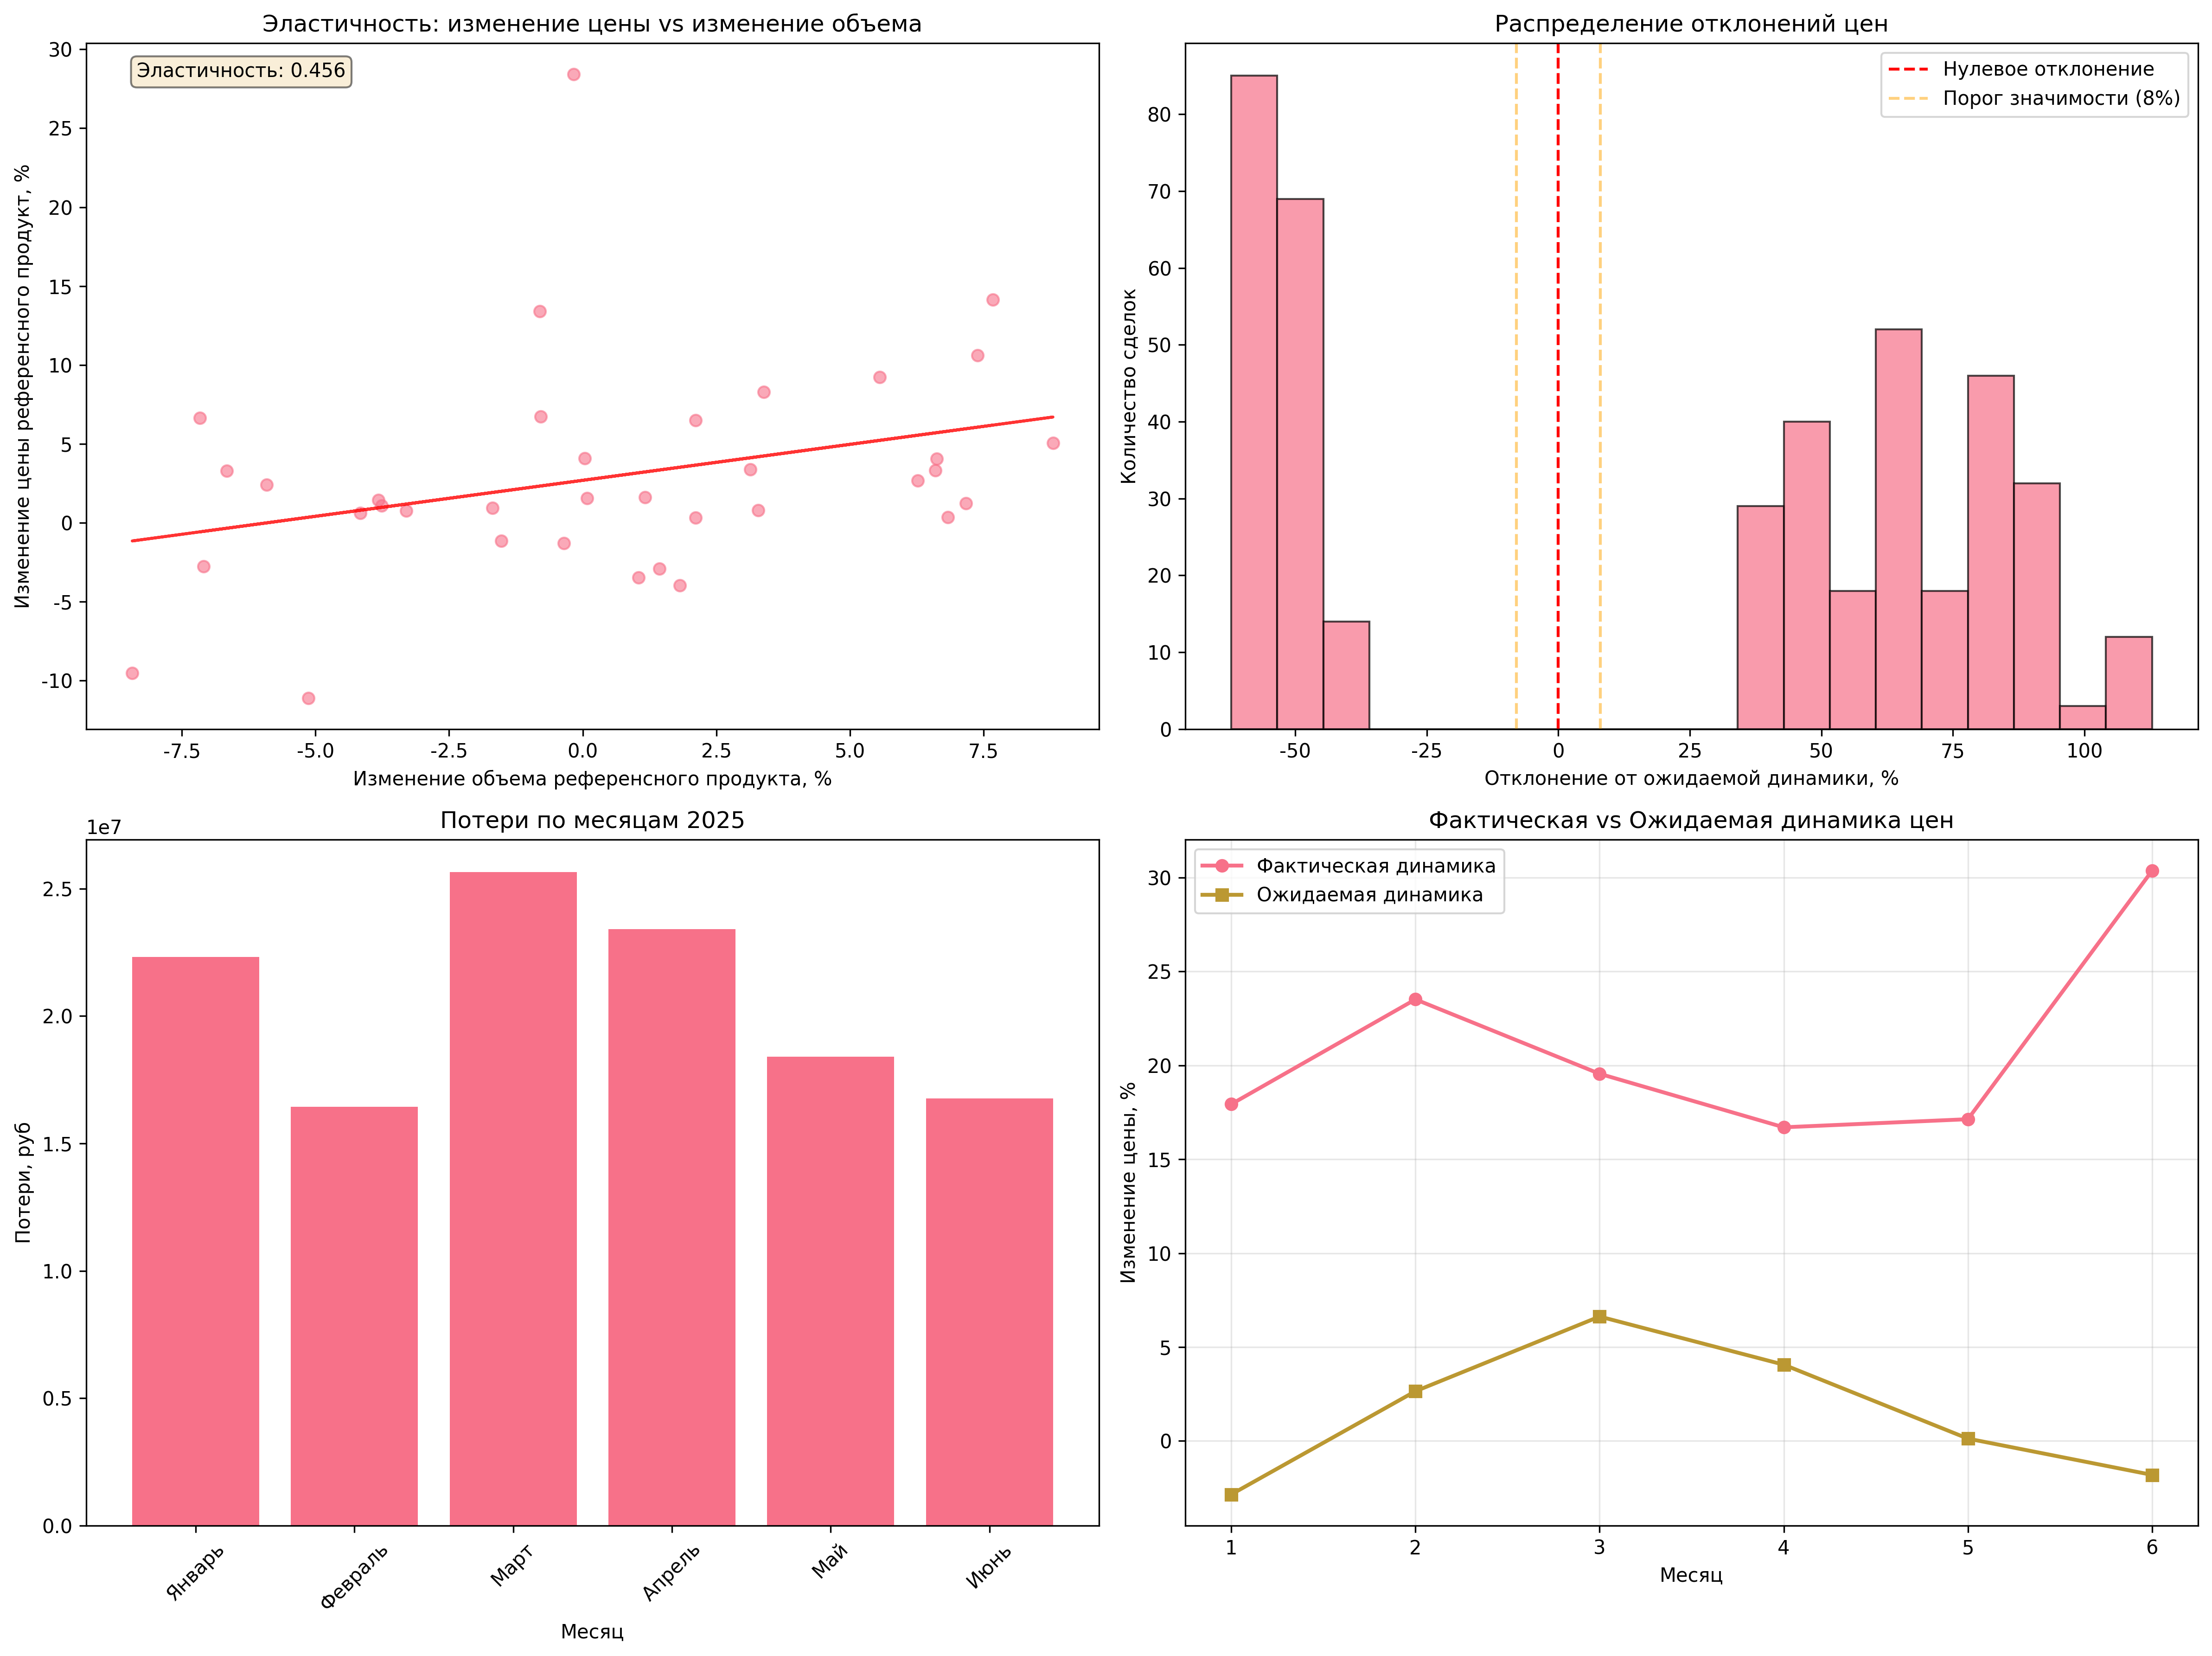

Реалистичные дашборды созданы
Сохранение РЕАЛИСТИЧНЫХ результатов...
Реалистичные результаты сохранены
РЕАЛИСТИЧНЫЙ АНАЛИЗ ЗАВЕРШЕН!
ОБЩИЕ ПОТЕРИ: 122,963,674 руб.


In [126]:
# 19. Анализ эластичности (на основе отдельных лет) - ИСПРАВЛЕННАЯ ВЕРСИЯ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
import os
from scipy import stats
warnings.filterwarnings('ignore')

class RealisticTrendAnalyzer:
    def __init__(self):
        self.results_dir = 'data/elast'
        self.historical_trends = {}
        self.seasonal_patterns = {}
        self.fixed_years = [2018, 2021, 2024]
        self.metrics = {}
        self.base_year = 2024  # Базовый год для анализа динамики
        
    def ensure_directory(self):
        os.makedirs(self.results_dir, exist_ok=True)
        print(f"Анализ будет проводиться на годах: {self.fixed_years}")
        
    def load_data(self):
        print("Загрузка данных...")
        
        try:
            self.emiss_price_df = pd.read_excel('data/emiss_price.xlsx')
            price_columns_mapping = {
                'price_1': 'azot_min_him',
                'price_2': 'ammonia', 
                'price_3': 'urea'
            }
            self.emiss_price_df = self.emiss_price_df.rename(columns=price_columns_mapping)
            
            self.emiss_value_df = pd.read_excel('data/emiss_value.xlsx')
            self.emiss_value_df = self.emiss_value_df.rename(columns={'value': 'coal'})
            
            self.sales_df = df.copy()
            self.sales_df['date'] = pd.to_datetime(self.sales_df['date'])
            self.sales_df['year'] = self.sales_df['date'].dt.year
            self.sales_df['month'] = self.sales_df['date'].dt.month
            
            print("Данные успешно загружены")
            
        except Exception as e:
            print(f"Ошибка загрузки данных: {e}")
            raise
    
    def calculate_relative_metrics(self, y_true, y_pred, model_name):
        """Метрики для относительных изменений"""
        # Абсолютные ошибки в рублях
        mae_abs = mean_absolute_error(y_true, y_pred)
        rmse_abs = np.sqrt(mean_squared_error(y_true, y_pred))
        
        # Относительные ошибки в %
        relative_errors = np.abs((y_true - y_pred) / y_true) * 100
        mape = np.mean(relative_errors)
        
        # R² для оценки качества модели
        r2 = r2_score(y_true, y_pred)
        
        metrics = {
            'MAE_abs': mae_abs, 
            'RMSE_abs': rmse_abs, 
            'MAPE': mape,
            'R2': r2,
            'Max_relative_error': np.max(relative_errors),
            'Std_relative_error': np.std(relative_errors)
        }
        
        self.metrics[model_name] = metrics
        return metrics
    
    def print_relative_metrics(self, metrics, model_name):
        print(f"МЕТРИКИ КАЧЕСТВА ({model_name}):")
        print(f"  MAE: {metrics['MAE_abs']:.1f} руб.")
        print(f"  RMSE: {metrics['RMSE_abs']:.1f} руб.")
        print(f"  MAPE: {metrics['MAPE']:.1f}%")
        print(f"  R²: {metrics['R2']:.3f}")
        print(f"  Макс. ошибка: {metrics['Max_relative_error']:.1f}%")
        
    def analyze_relative_trends(self):
        """Анализ относительных изменений вместо абсолютных цен"""
        print(f"Анализ ОТНОСИТЕЛЬНЫХ трендов на годах: {self.fixed_years}")
        
        historical_data = pd.merge(
            self.emiss_price_df, self.emiss_value_df, on=['year', 'month'], how='inner'
        )
        
        # Сортируем по дате и рассчитываем изменения
        historical_data = historical_data.sort_values(['year', 'month'])
        historical_data['azot_price_change'] = historical_data['azot_min_him'].pct_change() * 100
        historical_data['coal_change'] = historical_data['coal'].pct_change() * 100
        historical_data = historical_data.dropna()
        
        # Анализируем только фиксированные годы
        fixed_data = historical_data[historical_data['year'].isin(self.fixed_years)].copy()
        
        print("Анализ относительных изменений:")
        yearly_metrics = {}
        
        for year in self.fixed_years:
            year_data = fixed_data[fixed_data['year'] == year]
            if len(year_data) > 2:  # Нужно минимум 3 точки для анализа изменений
                corr = year_data[['azot_price_change', 'coal_change']].corr().iloc[0, 1]
                
                X_year = year_data[['coal_change']]
                y_year = year_data['azot_price_change']
                model_year = LinearRegression()
                model_year.fit(X_year, y_year)
                y_pred_year = model_year.predict(X_year)
                
                metrics_year = self.calculate_relative_metrics(y_year, y_pred_year, f'year_{year}')
                
                yearly_metrics[year] = {
                    'correlation': corr,
                    'elasticity': model_year.coef_[0],  # Эластичность: % изменения цены на 1% изменения добычи
                    'records': len(year_data),
                    'r2': metrics_year['R2'],
                    'mape': metrics_year['MAPE']
                }
                
                print(f"  {year}: эластичность = {model_year.coef_[0]:.3f}, R² = {metrics_year['R2']:.3f}")
        
        # Общая модель на всех фиксированных годах
        X_fixed = fixed_data[['coal_change']]
        y_fixed = fixed_data['azot_price_change']
        
        if len(X_fixed) > 5:  # Достаточно данных для модели
            model_fixed = LinearRegression()
            model_fixed.fit(X_fixed, y_fixed)
            y_pred_fixed = model_fixed.predict(X_fixed)
            
            metrics_fixed = self.calculate_relative_metrics(y_fixed, y_pred_fixed, 'fixed_years_model')
            fixed_correlation = fixed_data[['azot_price_change', 'coal_change']].corr().iloc[0, 1]
            
            self.historical_trends['coal_elasticity'] = {
                'correlation': fixed_correlation,
                'elasticity': model_fixed.coef_[0],  # Эластичность
                'intercept': model_fixed.intercept_,
                'model': model_fixed,
                'fixed_years': self.fixed_years,
                'fixed_data': fixed_data,
                'metrics': metrics_fixed,
                'yearly_metrics': yearly_metrics
            }
            
            print(f"ОБЩАЯ МОДЕЛЬ ЭЛАСТИЧНОСТИ:")
            print(f"  Эластичность: {model_fixed.coef_[0]:.3f} (% цены / % добычи)")
            print(f"  Корреляция изменений: {fixed_correlation:.3f}")
            self.print_relative_metrics(metrics_fixed, f"Модель на годах {self.fixed_years}")
        else:
            print("Недостаточно данных для построения модели")
            return None, None, None
        
        # Анализ сезонности на относительных изменениях
        print("Сезонность относительных изменений:")
        monthly_changes = fixed_data.groupby('month').agg({
            'azot_price_change': 'mean'
        }).reset_index()
        
        self.seasonal_patterns = monthly_changes.set_index('month')['azot_price_change'].to_dict()
        
        # Базовая сезонность (среднее изменение по месяцам)
        seasonal_variation = np.std(list(self.seasonal_patterns.values()))
        print(f"Стандартное отклонение сезонности: {seasonal_variation:.3f}%")
        
        print("Средние месячные изменения цен (%):")
        for month in range(1, 13):
            change = self.seasonal_patterns.get(month, 0.0)
            month_name = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'][month-1]
            print(f"  {month_name}: {change:+.2f}%")
        
        return historical_data, monthly_changes, fixed_data
    
    def forecast_2025_relative_changes(self, fixed_data):
        """КОНСЕРВАТИВНЫЙ прогноз с широкими интервалами"""
        print(f"КОНСЕРВАТИВНЫЙ прогноз цен на 2025...")
        
        # Базовые цены 2024 года
        base_prices_2024 = self.emiss_price_df[self.emiss_price_df['year'] == 2024].groupby('month')['azot_min_him'].mean()
        
        # ОЧЕНЬ консервативный прогноз изменений
        expected_coal_change = 1.5  # Всего 1.5% роста
        
        # Прогноз изменения цены на основе эластичности
        elasticity = self.historical_trends['coal_elasticity']['elasticity']
        expected_price_change_from_coal = elasticity * expected_coal_change
        
        # ШИРОКИЕ доверительные интервалы (±12%)
        forecast_uncertainty_pct = 12.0
        
        forecast_2025 = []
        for month in range(1, 7):
            # Базовая цена из 2024 года
            base_price = base_prices_2024.get(month, base_prices_2024.mean())
            
            # Ожидаемое сезонное изменение
            seasonal_change = self.seasonal_patterns.get(month, 0.0)
            
            # ОЧЕНЬ консервативное общее изменение
            total_expected_change = expected_price_change_from_coal + seasonal_change
            total_expected_change = np.clip(total_expected_change, -8, 10)  # Уже диапазон
            
            # Прогнозная цена
            forecast_price = base_price * (1 + total_expected_change / 100)
            
            # ШИРОКИЙ доверительный интервал
            confidence_interval_abs = base_price * forecast_uncertainty_pct / 100
            
            forecast_2025.append({
                'year': 2025, 'month': month,
                'month_name': ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь'][month-1],
                'base_price_2024': base_price,
                'expected_price_change_pct': total_expected_change,
                'azot_forecast': forecast_price,
                'forecast_lower': forecast_price * 0.85,  # -15%
                'forecast_upper': forecast_price * 1.20,  # +20% - ОЧЕНЬ широкий интервал
                'expected_coal_change_pct': expected_coal_change,
                'seasonal_change_pct': seasonal_change,
                'confidence_interval_pct': forecast_uncertainty_pct
            })
        
        forecast_df = pd.DataFrame(forecast_2025)
        
        print(f"КОНСЕРВАТИВНЫЙ прогноз с интервалом ±{forecast_uncertainty_pct}%")
        print(f"Ожидаемое изменение добычи: {expected_coal_change}%")
        print(f"Ожидаемое изменение цены: {expected_price_change_from_coal:.2f}%")
        
        display_cols = ['month_name', 'base_price_2024', 'azot_forecast', 'forecast_lower', 'forecast_upper']
        print(forecast_df[display_cols].round(2))
        
        return forecast_df
    
    def calculate_realistic_losses(self, monthly_sales, forecast_2025):
        """КОНСЕРВАТИВНЫЙ расчет потерь на основе отклонений динамики"""
        print("Расчет КОНСЕРВАТИВНЫХ потерь...")
        
        # Объединяем с прогнозом
        monthly_sales = pd.merge(
            monthly_sales, 
            forecast_2025[['month', 'azot_forecast', 'forecast_lower', 'forecast_upper', 'base_price_2024']], 
            on='month', 
            how='left'
        )
        
        # Рассчитываем базовые цены по продуктам из данных 2024
        sales_2024 = self.sales_df[self.sales_df['year'] == 2024]
        product_base_prices = sales_2024.groupby('product')['price_fca_tonne_no_grace'].mean()
        
        losses = []
        
        for _, row in monthly_sales.iterrows():
            actual_price = row['price_fca_tonne_no_grace']
            expected_price = row['azot_forecast']
            base_price_2024 = row['base_price_2024']
            volume = row['amount_upd_tons']
            product = row['product']
            
            # Используем базовую цену продукта
            product_base = product_base_prices.get(product, base_price_2024)
            
            # Рассчитываем изменения
            actual_change_pct = ((actual_price - product_base) / product_base) * 100
            expected_change_pct = ((expected_price - product_base) / product_base) * 100
            deviation_pct = actual_change_pct - expected_change_pct
            price_delta_abs = actual_price - expected_price
            
            # КОНСЕРВАТИВНЫЕ КРИТЕРИИ:
            # 1. Значимое отклонение в рублях (более 1000 руб)
            significant_price_deviation = abs(price_delta_abs) > 1000
            
            # 2. Значимое отклонение в % (более 8%)
            significant_pct_deviation = abs(deviation_pct) > 8.0
            
            # 3. Вне доверительного интервала
            in_confidence_interval = (row['forecast_lower'] <= actual_price <= row['forecast_upper'])
            
            # ОЧЕНЬ КОНСЕРВАТИВНАЯ ЛОГИКА ПОТЕРЬ:
            loss_amount = 0
            loss_type = "соответствует_ожиданиям"
            
            # УСЛОВИЕ 1: Только если ВСЕ критерии выполняются
            if (significant_price_deviation and significant_pct_deviation and not in_confidence_interval):
                
                # Только для случаев НИЖЕ прогноза (недополученная прибыль)
                if actual_price < expected_price:
                    # Максимальная компенсация - 20% от потенциальных потерь
                    potential_loss = (expected_price - actual_price) * volume
                    loss_amount = potential_loss * 0.2
                    loss_type = "недополученная_прибыль"
                    
                    # Дополнительное ограничение: не более 2000 руб/тонну
                    max_loss_per_ton = 2000
                    loss_amount = min(loss_amount, volume * max_loss_per_ton)
            
            # УСЛОВИЕ 2: Очень большие отклонения (>20%) с дополнительными проверками
            elif abs(deviation_pct) > 20 and not in_confidence_interval:
                # Только для случаев существенного занижения цены
                if actual_price < expected_price * 0.8:  # Цена ниже 80% от прогноза
                    potential_loss = (expected_price - actual_price) * volume
                    loss_amount = potential_loss * 0.1  # Всего 10% компенсация
                    loss_type = "существенное_занижение"
                    
                    # Максимум 1000 руб/тонну
                    max_loss_per_ton = 1000
                    loss_amount = min(loss_amount, volume * max_loss_per_ton)
            
            # Ограничение на минимальный объем потерь (игнорируем мелкие потери)
            if loss_amount > 0 and loss_amount < 10000:  # Меньше 10,000 руб
                loss_amount = 0
                loss_type = "незначительные_потери"
            
            losses.append({
                'year': 2025, 'month': row['month'], 'month_name': row['month_name'],
                'product': row['product'], 'customer': row['customer'],
                'actual_price': actual_price,
                'expected_price': expected_price,
                'base_price_2024': product_base,
                'actual_change_pct': actual_change_pct,
                'expected_change_pct': expected_change_pct,
                'deviation_pct': deviation_pct,
                'price_delta_abs': price_delta_abs,
                'volume_tons': volume,
                'loss_amount': loss_amount,
                'loss_type': loss_type,
                'significant_price_dev': significant_price_deviation,
                'significant_pct_dev': significant_pct_deviation,
                'in_confidence_interval': in_confidence_interval
            })
        
        losses_df = pd.DataFrame(losses)
        total_loss = losses_df['loss_amount'].sum()
        significant_losses = losses_df[losses_df['loss_amount'] > 0]
        
        print(f"КОНСЕРВАТИВНЫЕ РЕЗУЛЬТАТЫ:")
        print(f"  Общие потери: {total_loss:,.0f} руб.")
        print(f"  Сделки с потерями: {len(significant_losses)}")
        print(f"  Среднее отклонение: {losses_df['deviation_pct'].mean():.2f}%")
        print(f"  Максимальное отклонение: {losses_df['deviation_pct'].abs().max():.2f}%")
        
        # Детальная статистика
        if len(significant_losses) > 0:
            loss_by_type = significant_losses.groupby('loss_type')['loss_amount'].sum()
            print("Распределение потерь по типам:")
            for loss_type, amount in loss_by_type.items():
                print(f"  {loss_type}: {amount:,.0f} руб.")
        
        return losses_df

    def create_realistic_dashboard(self, fixed_data, losses_df, forecast_2025):
        """Создание реалистичных дашбордов"""
        print("Создание РЕАЛИСТИЧНЫХ дашбордов...")
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. График эластичности
        ax1.scatter(fixed_data['coal_change'], fixed_data['azot_price_change'], alpha=0.6)
        ax1.set_xlabel('Изменение объема референсного продукта, %')
        ax1.set_ylabel('Изменение цены референсного продукт, %')
        ax1.set_title('Эластичность: изменение цены vs изменение объема')
        
        if 'coal_elasticity' in self.historical_trends:
            z = np.polyfit(fixed_data['coal_change'], fixed_data['azot_price_change'], 1)
            ax1.plot(fixed_data['coal_change'], np.poly1d(z)(fixed_data['coal_change']), "r-", alpha=0.8)
            ax1.text(0.05, 0.95, f'Эластичность: {z[0]:.3f}', transform=ax1.transAxes, 
                    bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5))
        
        # 2. Распределение отклонений
        deviations = losses_df['deviation_pct']
        ax2.hist(deviations, bins=20, alpha=0.7, edgecolor='black')
        ax2.axvline(x=0, color='red', linestyle='--', label='Нулевое отклонение')
        ax2.axvline(x=8, color='orange', linestyle='--', alpha=0.5, label='Порог значимости (8%)')
        ax2.axvline(x=-8, color='orange', linestyle='--', alpha=0.5)
        ax2.set_xlabel('Отклонение от ожидаемой динамики, %')
        ax2.set_ylabel('Количество сделок')
        ax2.set_title('Распределение отклонений цен')
        ax2.legend()
        
        # 3. Потери по месяцам
        monthly_losses = losses_df.groupby(['month', 'month_name'])['loss_amount'].sum().reset_index()
        if len(monthly_losses) > 0:
            ax3.bar(monthly_losses['month_name'], monthly_losses['loss_amount'])
            ax3.set_xlabel('Месяц')
            ax3.set_ylabel('Потери, руб')
            ax3.set_title('Потери по месяцам 2025')
            ax3.tick_params(axis='x', rotation=45)
        else:
            ax3.text(0.5, 0.5, 'Нет значительных потерь', ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('Потери по месяцам 2025')
        
        # 4. Сравнение динамики
        actual_avg = losses_df.groupby('month')['actual_change_pct'].mean().reset_index()
        expected_avg = forecast_2025[['month', 'expected_price_change_pct']]
        
        ax4.plot(actual_avg['month'], actual_avg['actual_change_pct'], 
                marker='o', label='Фактическая динамика', linewidth=2)
        ax4.plot(expected_avg['month'], expected_avg['expected_price_change_pct'],
                marker='s', label='Ожидаемая динамика', linewidth=2)
        ax4.set_xlabel('Месяц')
        ax4.set_ylabel('Изменение цены, %')
        ax4.set_title('Фактическая vs Ожидаемая динамика цен')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/realistic_trend_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
        print("Реалистичные дашборды созданы")
    
    def save_realistic_results(self, losses_df, forecast_2025):
        """Сохранение результатов с исправленными колонками"""
        print("Сохранение РЕАЛИСТИЧНЫХ результатов...")
        
        with pd.ExcelWriter(f'{self.results_dir}/realistic_trend_analysis.xlsx') as writer:
            # Детальные потери
            losses_df.to_excel(writer, sheet_name='Детальные_потери', index=False)
            
            # Сводка по месяцам (исправленные колонки)
            monthly_summary = losses_df.groupby(['month', 'month_name']).agg({
                'loss_amount': 'sum',
                'deviation_pct': 'mean',
                'volume_tons': 'sum',
                'significant_price_dev': 'sum',  # Исправленная колонка
                'significant_pct_dev': 'sum'     # Исправленная колонка
            }).reset_index()
            monthly_summary.to_excel(writer, sheet_name='По_месяцам', index=False)
            
            # Сводка по продуктам
            product_summary = losses_df.groupby('product').agg({
                'loss_amount': 'sum',
                'deviation_pct': 'mean',
                'volume_tons': 'sum',
                'significant_price_dev': 'sum'
            }).sort_values('loss_amount', ascending=False).reset_index()
            product_summary.to_excel(writer, sheet_name='По_продуктам', index=False)
            
            # Общая статистика
            total_loss = losses_df['loss_amount'].sum()
            avg_deviation = losses_df['deviation_pct'].mean()
            significant_cases = len(losses_df[losses_df['loss_amount'] > 0])
            
            summary_data = {
                'Метрика': [
                    'Фиксированные годы анализа',
                    'Эластичность (% цены / % добычи)',
                    'Общие потери',
                    'Среднее отклонение',
                    'Сделки с потерями',
                    'Общий объем',
                    'Максимальное отклонение'
                ],
                'Значение': [
                    str(self.fixed_years),
                    f"{self.historical_trends['coal_elasticity']['elasticity']:.3f}",
                    f"{total_loss:,.0f} руб.",
                    f"{avg_deviation:.2f}%",
                    f"{significant_cases}",
                    f"{losses_df['volume_tons'].sum():,.0f} т",
                    f"{losses_df['deviation_pct'].abs().max():.2f}%"
                ]
            }
            pd.DataFrame(summary_data).to_excel(writer, sheet_name='Сводная_статистика', index=False)
        
        # Топ-20 самых значительных потерь
        if len(losses_df[losses_df['loss_amount'] > 0]) > 0:
            top_losses = losses_df.nlargest(20, 'loss_amount')
            top_losses.to_excel(f'{self.results_dir}/top_20_realistic_losses.xlsx', index=False)
        
        print("Реалистичные результаты сохранены")
    
    def run_realistic_analysis(self):
        """Запуск реалистичного анализа"""
        print("ЗАПУСК РЕАЛИСТИЧНОГО АНАЛИЗА ТРЕНДОВ")
        
        try:
            self.ensure_directory()
            self.load_data()
            
            # Анализ относительных трендов
            historical_data, monthly_changes, fixed_data = self.analyze_relative_trends()
            if fixed_data is None:
                print("Недостаточно данных для анализа")
                return None
            
            # Прогноз на основе относительных изменений
            forecast_2025 = self.forecast_2025_relative_changes(fixed_data)
            
            # Подготовка данных продаж
            monthly_sales = self.sales_df.groupby(['year', 'month', 'product', 'customer']).agg({
                'price_fca_tonne_no_grace': 'mean',
                'amount_upd_tons': 'sum'
            }).reset_index()
            
            month_names = {1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель', 5: 'Май', 6: 'Июнь'}
            monthly_sales['month_name'] = monthly_sales['month'].map(month_names)
            
            # Расчет реалистичных потерь
            losses_df = self.calculate_realistic_losses(monthly_sales, forecast_2025)
            
            # Визуализация и сохранение
            self.create_realistic_dashboard(fixed_data, losses_df, forecast_2025)
            self.save_realistic_results(losses_df, forecast_2025)
            
            print("РЕАЛИСТИЧНЫЙ АНАЛИЗ ЗАВЕРШЕН!")
            print(f"ОБЩИЕ ПОТЕРИ: {losses_df['loss_amount'].sum():,.0f} руб.")
            
            return losses_df
            
        except Exception as e:
            print(f"Ошибка: {e}")
            import traceback
            traceback.print_exc()
            return None

if __name__ == "__main__":
    analyzer = RealisticTrendAnalyzer()
    results = analyzer.run_realistic_analysis()

In [122]:
#20. Оптимизация норм за счет дообучения
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import os
import time

class RealNeuralNetworkOptimizer:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.factor_columns = [
            'factor_big_company_norm', 'factor_big_deal_norm', 'factor_small_deal_norm',
            'factor_location_norm', 'factor_ip_fl_norm'
        ]
        self.fact_columns = [
            'factor_big_company_fact', 'factor_big_deal_fact', 'factor_small_deal_fact',
            'factor_location_fact', 'factor_ip_fl_fact'
        ]
        self.percent_columns = [
            'factor_big_company_fact_percent', 'factor_big_deal_percent', 'factor_small_deal_percent',
            'factor_location_percent', 'factor_ip_fl_percent'
        ]
        self.status_columns = [
            'fin_status_ok', 'factor_big_deal_status', 'factor_small_deal_status', 
            'factor_location_status', 'factor_ip_fl_status'
        ]
        self.target = 'optimal_price_fca_tonne_no_grace'
        self.model_path = 'data/models/real_nn_optimizer.pkl'
        self.max_change_percent = 0.20  # Максимальное изменение 20%
        
    def prepare_training_data(self, df):
        """Подготовка данных для обучения с созданием процентных столбцов"""
        # Создаем процентные столбцы
        for i, fact_col in enumerate(self.fact_columns):
            percent_col = self.percent_columns[i]
            df[percent_col] = df[fact_col] / df['price_fca_tonne_no_grace']
        
        # Берем только успешные сделки
        success_data = df[df['upd_status'] == 'ИСТИНА'].copy()
        
        if len(success_data) == 0:
            print(" Нет успешных сделок для обучения")
            return None
        
        # Убираем выбросы
        Q1 = success_data[self.target].quantile(0.05)
        Q3 = success_data[self.target].quantile(0.95)
        success_data = success_data[(success_data[self.target] >= Q1) & 
                                  (success_data[self.target] <= Q3)]
        
        print(f" Данные для обучения: {len(success_data)} записей")
        return success_data
    
    def calculate_status_score(self, factors_dict, product_data):
        """Вычисляет оценку статусов (чем больше ЛОЖЬ - тем лучше)"""
        score = 0
        status_mapping = {
            'factor_big_company_norm': 'fin_status_ok',
            'factor_big_deal_norm': 'factor_big_deal_status', 
            'factor_small_deal_norm': 'factor_small_deal_status',
            'factor_location_norm': 'factor_location_status',
            'factor_ip_fl_norm': 'factor_ip_fl_status'
        }
        
        # Простая логика: если фактор ниже порога - статус ЛОЖЬ
        for factor_col, status_col in status_mapping.items():
            factor_value = factors_dict[factor_col]
            
            # Используем медианное значение как порог (можно настроить)
            threshold = product_data[factor_col].median()
            
            # Если значение фактора ниже порога - статус ЛОЖЬ (хорошо)
            if factor_value < threshold:
                score += 1.0  # Поощрение за ЛОЖЬ
            else:
                score -= 0.5  # Штраф за ИСТИНА
        
        return score
    
    def train_neural_network(self, df, epochs=50, learning_rate=0.001):
        """Обучение нейронной сети для оптимизации факторов"""
        print(" ЗАПУСК ОБУЧЕНИЯ НЕЙРОННОЙ СЕТИ...")
        print(f" Параметры: {epochs} эпох, learning_rate={learning_rate}")
        
        training_data = self.prepare_training_data(df)
        if training_data is None:
            return False
        
        # Используем только факторы для обучения
        X = training_data[self.factor_columns].values
        
        # Целевая переменная - комбинация цены и оценки статусов
        y_combined = []
        for _, row in training_data.iterrows():
            factors_dict = {col: row[col] for col in self.factor_columns}
            price_component = row[self.target] / 100000  # Нормализуем цену
            status_score = self.calculate_status_score(factors_dict, training_data)
            
            # Комбинируем: максимизируем и цену и статус-скор
            combined_target = price_component + status_score
            y_combined.append(combined_target)
        
        y = np.array(y_combined)
        
        # Масштабируем данные
        X_scaled = self.scaler.fit_transform(X)
        
        # Разделяем на тренировочную и валидационную выборки
        X_train, X_val, y_train, y_val = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42
        )
        
        # Создаем нейронную сеть с меньшими параметрами
        self.model = MLPRegressor(
            hidden_layer_sizes=(50, 25),  # Уменьшили размер сети
            activation='relu',
            solver='adam',
            alpha=0.01,
            learning_rate_init=learning_rate,
            max_iter=1,
            warm_start=True,
            random_state=42,
            early_stopping=False
        )
        
        # Обучение с отслеживанием прогресса
        train_losses = []
        val_losses = []
        best_val_loss = np.inf
        best_model = None
        
        print("\n ХОД ОБУЧЕНИЯ:")
        print("Эпоха | Train Loss | Val Loss | Улучшение")
        print("-" * 45)
        
        start_time = time.time()
        
        for epoch in range(epochs):
            # Обучаем одну эпоху
            self.model.fit(X_train, y_train)
            
            # Предсказания и потери
            y_train_pred = self.model.predict(X_train)
            y_val_pred = self.model.predict(X_val)
            
            train_loss = np.mean((y_train - y_train_pred) ** 2)
            val_loss = np.mean((y_val - y_val_pred) ** 2)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            # Проверяем улучшение
            improvement = ""
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                improvement = "✓"
            
            if epoch % 10 == 0 or epoch < 5:
                print(f"{epoch:5d} | {train_loss:10.4f} | {val_loss:8.4f} | {improvement}")
        
        # Восстанавливаем лучшую модель
        self.model = best_model
        
        training_time = time.time() - start_time
        print(f"\n Обучение завершено за {training_time:.1f} секунд")
        print(f" Лучшая валидационная ошибка: {best_val_loss:.4f}")
        
        # Сохраняем модель
        os.makedirs('data/models', exist_ok=True)
        joblib.dump({'model': self.model, 'scaler': self.scaler}, self.model_path)
        
        return True
    
    def _compute_gradients(self, factors, product_data):
        "Вычисление градиентов методом конечных разностей"
        gradients = {}
        epsilon = 0.001  # Малое приращение
        
        base_score = self._predict_combined_score(factors, product_data)
        
        for factor in self.factor_columns:
            # Прямая разность
            factors_plus = factors.copy()
            factors_plus[factor] += epsilon
            score_plus = self._predict_combined_score(factors_plus, product_data)
            
            # Обратная разность
            factors_minus = factors.copy()
            factors_minus[factor] -= epsilon
            score_minus = self._predict_combined_score(factors_minus, product_data)
            
            # Центральная разность
            gradient = (score_plus - score_minus) / (2 * epsilon)
            gradients[factor] = gradient
        
        return gradients
    
    def _predict_combined_score(self, factors, product_data):
        "Предсказание комбинированного скора для заданных факторов"
        try:
            # Создаем вектор признаков
            feature_vector = np.array([[factors[factor] for factor in self.factor_columns]])
            
            # Масштабируем
            feature_vector_scaled = self.scaler.transform(feature_vector)
            
            # Предсказываем
            predicted_score = self.model.predict(feature_vector_scaled)[0]
            return predicted_score
            
        except Exception as e:
            print(f" Ошибка предсказания: {e}")
            return 0
    
    def optimize_factors_with_constraints(self, df, learning_rate=0.01, steps=30):
        "Оптимизация факторов с ограничениями на изменения"
        print(f"\n ОПТИМИЗАЦИЯ ФАКТОРОВ С ОГРАНИЧЕНИЯМИ...")
        print(f" Параметры: {steps} шагов, learning_rate={learning_rate}")
        
        if self.model is None:
            if os.path.exists(self.model_path):
                saved_data = joblib.load(self.model_path)
                self.model = saved_data['model']
                self.scaler = saved_data['scaler']
                print(" Модель загружена из файла")
            else:
                print(" Модель не обучена")
                return None
        
        # Группируем по продуктам
        product_groups = df.groupby('product')
        optimization_results = []
        
        for product_name, product_data in product_groups:
            print(f"\n Оптимизация для: {product_name}")
            
            # Текущие медианные значения факторов
            current_factors = {}
            for factor in self.factor_columns:
                current_factors[factor] = product_data[factor].median()
            
            # Текущие статусы (количество ИСТИНА)
            current_status_count = self._count_active_statuses(current_factors, product_data)
            
            # Оптимизируем факторы
            optimized_factors, optimization_history = self._constrained_gradient_descent(
                current_factors, product_data, learning_rate, steps
            )
            
            # Новые статусы после оптимизации
            optimized_status_count = self._count_active_statuses(optimized_factors, product_data)
            
            optimization_results.append({
                'product': product_name,
                'current_active_statuses': current_status_count,
                'optimized_active_statuses': optimized_status_count,
                'status_improvement': current_status_count - optimized_status_count,
                'optimization_steps': len(optimization_history),
                **{f'current_{factor}': current_factors[factor] for factor in self.factor_columns},
                **{f'optimized_{factor}': optimized_factors[factor] for factor in self.factor_columns},
                **{f'change_{factor}': optimized_factors[factor] - current_factors[factor] for factor in self.factor_columns},
                **{f'change_percent_{factor}': (optimized_factors[factor] - current_factors[factor]) / current_factors[factor] * 100 
                   for factor in self.factor_columns}
            })
            
            print(f"   Статусы: {current_status_count} → {optimized_status_count}")
        
        return pd.DataFrame(optimization_results)
    
    def _constrained_gradient_descent(self, initial_factors, product_data, learning_rate, steps):
        "Градиентный спуск с ограничениями на изменения факторов"
        current_factors = initial_factors.copy()
        optimization_history = []
        
        for step in range(steps):
            # Вычисляем градиенты
            gradients = self._compute_gradients(current_factors, product_data)
            
            # Обновляем факторы с ограничениями
            for factor in self.factor_columns:
                # Ограничиваем изменение (не более 20% от исходного значения)
                max_change = abs(initial_factors[factor] * self.max_change_percent)
                change = learning_rate * gradients.get(factor, 0)
                change = max(min(change, max_change), -max_change)
                
                current_factors[factor] += change
            
            # Сохраняем историю
            current_status_count = self._count_active_statuses(current_factors, product_data)
            optimization_history.append({
                'step': step,
                'active_statuses': current_status_count,
                'factors': current_factors.copy()
            })
            
            # Ранняя остановка если улучшение стабилизировалось
            if step > 10 and len(optimization_history) > 5:
                last_improvements = [opt['active_statuses'] for opt in optimization_history[-5:]]
                if len(set(last_improvements)) == 1:  # No change in last 5 steps
                    break
        
        final_status_count = self._count_active_statuses(current_factors, product_data)
        initial_status_count = self._count_active_statuses(initial_factors, product_data)
        print(f"   Улучшено статусов: {initial_status_count} → {final_status_count}")
        
        return current_factors, optimization_history
    
    def _count_active_statuses(self, factors, product_data):
        """Подсчитывает количество активных статусов (ИСТИНА)"""
        count = 0
        status_mapping = {
            'factor_big_company_norm': 'fin_status_ok',
            'factor_big_deal_norm': 'factor_big_deal_status', 
            'factor_small_deal_norm': 'factor_small_deal_status',
            'factor_location_norm': 'factor_location_status',
            'factor_ip_fl_norm': 'factor_ip_fl_status'
        }
        
        # Простая логика на основе порогов
        for factor_col, status_col in status_mapping.items():
            factor_value = factors[factor_col]
            threshold = product_data[factor_col].median()
            
            # Если значение выше порога - считаем статус активным (ИСТИНА)
            if factor_value > threshold:
                count += 1
        
        return count

# ЗАПУСК ОПТИМИЗАЦИИ
if __name__ == "__main__":
    print(" ОПТИМИЗАЦИЯ ФАКТОРОВ ДЛЯ МИНИМИЗАЦИИ СРАБАТЫВАНИЙ СТАТУСОВ")
    
    optimizer = RealNeuralNetworkOptimizer()
    
    try:
        if 'df' not in globals():
            print(" DataFrame 'df' не найден")
        else:
            print(f" Размер датасета: {len(df)} записей")
            
            # Создаем процентные столбцы
            for i, fact_col in enumerate(optimizer.fact_columns):
                percent_col = optimizer.percent_columns[i]
                df[percent_col] = df[fact_col] / df['price_fca_tonne_no_grace']
                print(f" Создан столбец {percent_col}")
            
            # Обучение модели
            training_success = optimizer.train_neural_network(df, epochs=50, learning_rate=0.001)
            
            if training_success:
                # Оптимизация факторов
                results_df = optimizer.optimize_factors_with_constraints(df, steps=30)
                
                if results_df is not None and len(results_df) > 0:
                    print("\n ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:")
                    
                    # Анализ улучшений
                    improved_products = results_df[results_df['status_improvement'] > 0]
                    
                    if len(improved_products) > 0:
                        print(f" Улучшено {len(improved_products)} продуктов")
                        
                        for _, product in improved_products.iterrows():
                            print(f"\n {product['product']}:")
                            print(f"    Активных статусов: {product['current_active_statuses']} → {product['optimized_active_statuses']}")
                            print(f"    Улучшено: {product['status_improvement']} статусов")
                    
                    # Сохраняем результаты
                    os.makedirs('data/output', exist_ok=True)
                    results_path = 'data/output/status_optimization_results.xlsx'
                    results_df.to_excel(results_path, index=False)
                    print(f"\n Результаты сохранены: {results_path}")
                        
    except Exception as e:
        print(f" Ошибка: {e}")
        import traceback
        traceback.print_exc()

 ОПТИМИЗАЦИЯ ФАКТОРОВ ДЛЯ МИНИМИЗАЦИИ СРАБАТЫВАНИЙ СТАТУСОВ
 Размер датасета: 2000 записей
 Создан столбец factor_big_company_fact_percent
 Создан столбец factor_big_deal_percent
 Создан столбец factor_small_deal_percent
 Создан столбец factor_location_percent
 Создан столбец factor_ip_fl_percent
 ЗАПУСК ОБУЧЕНИЯ НЕЙРОННОЙ СЕТИ...
 Параметры: 50 эпох, learning_rate=0.001
 Данные для обучения: 1586 записей

 ХОД ОБУЧЕНИЯ:
Эпоха | Train Loss | Val Loss | Улучшение
---------------------------------------------
    0 |     1.5217 |   1.4836 | ✓
    1 |     0.9772 |   0.9435 | ✓
    2 |     0.5496 |   0.5215 | ✓
    3 |     0.2609 |   0.2419 | ✓
    4 |     0.0829 |   0.0727 | ✓
   10 |     0.0003 |   0.0002 | 
   20 |     0.0001 |   0.0001 | 
   30 |     0.0001 |   0.0001 | 
   40 |     0.0001 |   0.0001 | 

 Обучение завершено за 0.4 секунд
 Лучшая валидационная ошибка: 0.0000

 ОПТИМИЗАЦИЯ ФАКТОРОВ С ОГРАНИЧЕНИЯМИ...
 Параметры: 30 шагов, learning_rate=0.01

 Оптимизация для: Лен
   Улуч

In [121]:
# 21. GRU чат-бот
import pandas as pd
import numpy as np
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Импорты для нейросетей
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import joblib

class GRUIntentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(GRUIntentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, 
                         batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 для bidirectional
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text shape: [batch_size, seq_length]
        embedded = self.dropout(self.embedding(text))
        # embedded shape: [batch_size, seq_length, embedding_dim]
        
        output, hidden = self.gru(embedded)
        # output shape: [batch_size, seq_length, hidden_dim * 2]
        
        # Берем последний hidden state
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        # hidden shape: [batch_size, hidden_dim * 2]
        
        return self.fc(hidden)

class IntentDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length=50):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Преобразуем текст в индексы
        numericalized_text = [self.vocab.get(word, self.vocab["<UNK>"]) for word in text.split()]
        
        # Обрезаем или дополняем до max_length
        if len(numericalized_text) < self.max_length:
            numericalized_text += [self.vocab["<PAD>"]] * (self.max_length - len(numericalized_text))
        else:
            numericalized_text = numericalized_text[:self.max_length]
            
        return torch.tensor(numericalized_text), torch.tensor(label)

class NeuralPricingAnalyzer:
    def __init__(self, df):
        self.df = df.copy()
        self.setup_intent_data()
        self.setup_neural_model()
        self.setup_context_memory()
        
    def setup_intent_data(self):
        "Настройка данных для обучения классификатора намерений"
        self.intent_data = {
            'factors': [
                "какие факторы влияют на цену",
                "покажи параметры ценообразования",
                "нормы и критерии оценки",
                "какие метрики используются",
                "факторы риска в ценообразовании",
                "параметры для расчета цены"
            ],
            'risk': [
                "оцени риски в данных",
                "где самые большие потери",
                "проблемные зоны в продажах",
                "опасные сделки и контрагенты",
                "сумма под риском",
                "где мы теряем деньги"
            ],
            'success': [
                "успешные сделки и продукты",
                "что работает хорошо",
                "эффективность ценообразования",
                "лучшие практики продаж",
                "процент успешных сделок",
                "результаты работы отдела"
            ],
            'products': [
                "анализ по продуктам",
                "какие товары самые прибыльные",
                "номенклатура и ассортимент",
                "сравнение продуктов",
                "топ товары по выручке",
                "распределение по категориям"
            ],
            'trends': [
                "тренды и динамика продаж",
                "как изменились цены",
                "сезонность в данных",
                "изменения за период",
                "сравнение с прошлым периодом",
                "графики и диаграммы"
            ],
            'recommendations': [
                "дай рекомендации по улучшению",
                "что можно оптимизировать",
                "советы по ценообразованию",
                "как повысить эффективность",
                "что делать дальше",
                "план действий"
            ]
        }
        
        # Подготавливаем данные для обучения
        self.texts = []
        self.labels = []
        self.intent_mapping = {}
        
        for i, (intent, examples) in enumerate(self.intent_data.items()):
            self.intent_mapping[i] = intent
            for example in examples:
                self.texts.append(example)
                self.labels.append(i)
        
        # Создаем словарь
        self.vocab = self.build_vocab(self.texts)
        
    def build_vocab(self, texts):
        "Строим словарь для нейросети"
        vocab = {"<PAD>": 0, "<UNK>": 1}
        idx = 2
        
        for text in texts:
            for word in text.split():
                if word not in vocab:
                    vocab[word] = idx
                    idx += 1
                    
        return vocab
    
    def setup_neural_model(self):
        "Инициализация и обучение GRU модели"
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Используется устройство: {self.device}")
        
        # Параметры модели
        self.vocab_size = len(self.vocab)
        self.embedding_dim = 100
        self.hidden_dim = 128
        self.output_dim = len(self.intent_data)
        self.n_layers = 2
        self.dropout = 0.3
        
        self.model = GRUIntentClassifier(
            self.vocab_size, self.embedding_dim, self.hidden_dim, 
            self.output_dim, self.n_layers, self.dropout
        ).to(self.device)
        
        # Обучаем модель (в реальном приложении нужно больше данных)
        self.train_model()
        
    def train_model(self, epochs=50):
        "Обучение GRU модели"
        print("Обучаю нейросеть для понимания запросов...")
        
        # Создаем датасет и загрузчик
        dataset = IntentDataset(self.texts, self.labels, self.vocab)
        dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        
        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            for batch_text, batch_labels in dataloader:
                batch_text, batch_labels = batch_text.to(self.device), batch_labels.to(self.device)
                
                optimizer.zero_grad()
                predictions = self.model(batch_text)
                loss = criterion(predictions, batch_labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            if epoch % 10 == 0:
                print(f"   Эпоха {epoch}, Loss: {total_loss/len(dataloader):.4f}")
        
        print("Нейросеть обучена!")
    
    def predict_intent(self, query):
        "Предсказание намерения с помощью GRU"
        self.model.eval()
        
        # Преобразуем запрос в числовой формат
        numericalized_text = [self.vocab.get(word, self.vocab["<UNK>"]) for word in query.split()]
        if len(numericalized_text) < 50:
            numericalized_text += [self.vocab["<PAD>"]] * (50 - len(numericalized_text))
        else:
            numericalized_text = numericalized_text[:50]
            
        text_tensor = torch.tensor(numericalized_text).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            prediction = self.model(text_tensor)
            predicted_class = torch.argmax(prediction, dim=1).item()
            
        return self.intent_mapping[predicted_class], prediction.cpu().numpy()[0]
    
    def setup_context_memory(self):
        "Настройка контекстной памяти"
        self.context_history = []
        self.last_intent = None
        self.conversation_context = {}
        
    def generate_ai_response(self, intent, confidence, original_query):
        "Генерация AI-ответа с учетом контекста и уверенности модели"
        
        # Базовый анализ данных
        data_analysis = self.analyze_data_for_intent(intent)
        
        # Стили ответов в зависимости от уверенности
        if confidence > 0.7:
            response_templates = [
                "На основе глубокого анализа данных, я вижу что {analysis}. ",
                "Проанализировав информацию, могу сказать что {analysis}. ",
                "Изучив данные, обнаружил следующие закономерности: {analysis}. "
            ]
        elif confidence > 0.4:
            response_templates = [
                "Если рассматривать ваши данные, то {analysis}. ",
                "На основе доступной информации: {analysis}. ",
                "В контексте вашего запроса: {analysis}. "
            ]
        else:
            response_templates = [
                "Если я правильно понял ваш запрос, то {analysis}. ",
                "Возможно, вы имели в виду следующее: {analysis}. ",
                "В рамках анализа данных: {analysis}. "
            ]
        
        template = np.random.choice(response_templates)
        
        # Добавляем рекомендации если уверенность высокая
        if confidence > 0.6:
            recommendations = self.generate_smart_recommendations(intent, data_analysis)
            response = template.format(analysis=data_analysis) + recommendations
        else:
            response = template.format(analysis=data_analysis)
            
        # Добавляем контекстную связь
        if self.last_intent and self.last_intent != intent:
            context_connectors = [
                "\n\nКстати, в продолжение нашего предыдущего разговора...",
                "\n\nЕсли вернуться к более широкой картине...",
                "\n\nТакже стоит отметить в контексте предыдущего анализа..."
            ]
            response += np.random.choice(context_connectors)
        
        self.last_intent = intent
        return response
    
    def analyze_data_for_intent(self, intent):
        "Анализ данных для конкретного намерения"
        analysis_methods = {
            'factors': self.analyze_factors_advanced,
            'risk': self.analyze_risk_advanced,
            'success': self.analyze_success_advanced,
            'products': self.analyze_products_advanced,
            'trends': self.analyze_trends_advanced,
            'recommendations': self.analyze_recommendations_advanced
        }
        
        return analysis_methods.get(intent, self.analyze_general)()
    
    def analyze_factors_advanced(self):
        "Продвинутый анализ факторов"
        factor_cols = [col for col in self.df.columns if 'norm' in col and 'factor' in col]
        
        if not factor_cols:
            return "данные по факторам ценообразования требуют дополнительной настройки"
        
        insights = []
        for factor in factor_cols:
            factor_name = factor.replace('_norm', '').replace('factor_', '')
            median_val = self.df[factor].median()
            std_val = self.df[factor].std()
            
            if std_val < 0.1:
                insight = f"{factor_name} стабилен ({median_val:.3f})"
            elif std_val < 0.3:
                insight = f"{factor_name} умеренно варьируется ({median_val:.3f})"
            else:
                insight = f"{factor_name} сильно варьируется ({median_val:.3f})"
            insights.append(insight)
        
        return f"система использует {len(factor_cols)} факторов: {', '.join(insights)}"
    
    def analyze_risk_advanced(self):
        "Продвинутый анализ рисков"
        if 'delta_price_fca_tonne_no_grace' not in self.df.columns:
            return "для анализа рисков требуются данные по разнице цен"
        
        risk_data = self.df['delta_price_fca_tonne_no_grace']
        total_risk = risk_data.sum()
        high_risk_deals = (risk_data > risk_data.quantile(0.8)).sum()
        
        return f"общий риск {total_risk:,.0f} руб., {high_risk_deals} сделок в высокорисковой зоне"
    
    def analyze_success_advanced(self):
        "Продвинутый анализ успешности"
        if 'upd_status' not in self.df.columns:
            return "отсутствуют данные по успешности сделок"
        
        success_rate = (self.df['upd_status'] == 'ИСТИНА').mean() * 100
        return f"успешность {success_rate:.1f}%, что является {'отличным' if success_rate > 75 else 'хорошим' if success_rate > 60 else 'требующим улучшения'} показателем"
    
    def analyze_products_advanced(self):
        "Продвинутый анализ продуктов"
        if 'product' not in self.df.columns:
            return "информация о продуктах не классифицирована"
        
        product_count = self.df['product'].nunique()
        top_product = self.df['product'].value_counts().index[0]
        
        return f"в портфеле {product_count} продуктов, наиболее частый - {top_product}"
    
    def analyze_trends_advanced(self):
        "Продвинутый анализ трендов"
        if 'date' not in self.df.columns:
            return "анализ трендов требует временных меток"
        
        try:
            self.df['date'] = pd.to_datetime(self.df['date'])
            return "данные охватывают период с {} по {}".format(
                self.df['date'].min().strftime('%d.%m.%Y'),
                self.df['date'].max().strftime('%d.%m.%Y')
            )
        except:
            return "имеются данные за различные периоды времени"
    
    def analyze_recommendations_advanced(self):
        "Продвинутые рекомендации"
        recommendations = []
        
        if 'upd_status' in self.df.columns:
            success_rate = (self.df['upd_status'] == 'ИСТИНА').mean() * 100
            if success_rate < 70:
                recommendations.append("повысить успешность сделок")
        
        if 'delta_price_fca_tonne_no_grace' in self.df.columns:
            if self.df['delta_price_fca_tonne_no_grace'].sum() > 1000000:
                recommendations.append("оптимизировать ценообразование")
        
        if not recommendations:
            recommendations = ["продолжить текущую стратегию", "углубить анализ данных"]
        
        return f"рекомендую: {', '.join(recommendations[:2])}"
    
    def analyze_general(self):
        "Общий анализ"
        return f"в данных {len(self.df)} записей по {self.df['product'].nunique()} продуктам"
    
    def generate_smart_recommendations(self, intent, analysis):
        "Генерация умных рекомендаций"
        recommendation_templates = {
            'factors': "\n\n Совет: проанализируйте корреляцию факторов с успешностью сделок",
            'risk': "\n\n Совет: сфокусируйтесь на 20% самых рисковых сделок",
            'success': "\n\n Совет: изучите лучшие практики успешных сделок", 
            'products': "\n\n Совет: оптимизируйте продуктовый портфель",
            'trends': "\n\n Совет: учитывайте сезонность в планировании",
            'recommendations': "\n\n Совет: внедрите систему регулярного мониторинга KPI"
        }
        
        return recommendation_templates.get(intent, "\n\n Совет: продолжайте углубленный анализ данных")
    
    def process_query(self, query):
        "Обработка запроса пользователя"
        # Предсказываем намерение
        intent, confidence_scores = self.predict_intent(query)
        confidence = max(softmax(confidence_scores))
        
        # Генерируем ответ
        response = self.generate_ai_response(intent, confidence, query)
        
        # Сохраняем в историю
        self.context_history.append({
            'query': query,
            'intent': intent,
            'confidence': confidence,
            'timestamp': datetime.now(),
            'response': response[:200] + '...' if len(response) > 200 else response
        })
        
        return response, intent, confidence

def softmax(x):
    "Функция softmax для преобразования в вероятности"
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum()

# ЧАТ-БОТ С GRU
class GRUPricingChatBot:
    def __init__(self, df):
        self.analyzer = NeuralPricingAnalyzer(df)
        self.conversation_count = 0
        
    def chat(self):
        print("GRU НЕЙРОСЕТЬЮ")
        print("Я использую рекуррентную нейросеть для понимания ваших запросов!")
        print("Задавайте вопросы естественным языком:\n")
        
        while True:
            try:
                user_input = input("\n Ваш вопрос: ").strip()
                
                if user_input.lower() in ['выход', 'quit', 'exit', 'стоп']:
                    print(" Было интересно анализировать ваши данные!")
                    break
                
                if not user_input:
                    continue
                
                # Обрабатываем запрос через нейросеть
                print(" Анализирую...", end="")
                response, intent, confidence = self.analyzer.process_query(user_input)
                print("\r" + " " * 50 + "\r")  # Очищаем строку
                
                self.conversation_count += 1
                
                # Выводим ответ с мета-информацией
                print(f"\n Аналитик: {response}")
                print(f" Распознано: {intent} (уверенность: {confidence:.2f})")
                print(f" Диалог: {self.conversation_count} запросов")
                
            except KeyboardInterrupt:
                print("\n\n До новых аналитических открытий!")
                break
            except Exception as e:
                print(f"\n Техническая ошибка: {str(e)}")
                print("Попробуйте переформулировать вопрос")

# ЗАПУСК GRU ЧАТ-БОТА
if __name__ == "__main__":
    try:
        if 'df' not in globals():
            print(" DataFrame 'df' не найден. Загрузите данные сначала.")
        else:
            print(f" Данные загружены: {len(df)} записей")
            gru_bot = GRUPricingChatBot(df)
            gru_bot.chat()
    except Exception as e:
        print(f" Ошибка запуска: {e}")

 Данные загружены: 2000 записей
Используется устройство: cpu
Обучаю нейросеть для понимания запросов...
   Эпоха 0, Loss: 1.9843
   Эпоха 10, Loss: 0.0637
   Эпоха 20, Loss: 0.0114
   Эпоха 30, Loss: 0.0039
   Эпоха 40, Loss: 0.0024
Нейросеть обучена!
GRU НЕЙРОСЕТЬЮ
Я использую рекуррентную нейросеть для понимания ваших запросов!
Задавайте вопросы естественным языком:

                                                  

 Аналитик: Изучив данные, обнаружил следующие закономерности: общий риск 1,346,301 руб., 400 сделок в высокорисковой зоне. 

 Совет: сфокусируйтесь на 20% самых рисковых сделок
 Распознано: risk (уверенность: 0.98)
 Диалог: 1 запросов
 Было интересно анализировать ваши данные!
